<a href="https://colab.research.google.com/github/tony-pitchblack/finrl-dt/blob/custom-backtesting/finrl_dt_replicate_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installs

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
%%capture
!pip install git+https://github.com/tony-pitchblack/FinRL.git@benchmarking --no-deps \
    # --force-reinstall

In [ ]:
%%capture
# Install the dependencies listed in the requirements.txt file
!wget https://raw.githubusercontent.com/tony-pitchblack/FinRL/benchmarking/requirements.txt -O requirements.txt
!pip install -r requirements.txt

In [ ]:
# %%capture
# !pip install ray[rllib]

# Installs (old)

In [ ]:
# %%capture
# !pip install -q yfinance==0.2.50
# !pip install stable-baselines3
# !pip install finrl
# !pip install alpaca_trade_api
# !pip install exchange_calendars
# !pip install stockstats
# !pip install wrds

In [ ]:
# %%capture
# import numpy as np

# if np.__version__ != '1.26.4':
#     !pip install -q numpy==1.26.4 --force-reinstall

# import pandas as pd

# if pd.__version__ != '2.2.2':
#     !pip install -q pandas==2.2.2 --force-reinstall

In [ ]:
# %%capture
# !pip install ray[rllib]

# Imports

In [ ]:
# %load_ext autoreload
# %autoreload 2

In [ ]:
import pandas as pd

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl import config_tickers
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import torch
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
os.environ["WANDB_API_KEY"] = "aee284a72205e2d6787bd3ce266c5b9aefefa42c"

PROJECT = 'finrl-dt-replicate'
ENTITY = "overfit1010"

# General funcs

In [ ]:
#@title YahooDownloader (compatible with original FinRL)

from __future__ import annotations

import pandas as pd
import yfinance as yf


class YahooDownloader:
    """Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from neofinrl_config.py)
        end_date : str
            end date of the data (modified from neofinrl_config.py)
        ticker_list : list
            a list of stock tickers (modified from neofinrl_config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API

    """

    def __init__(self, start_date: str, end_date: str, ticker_list: list):
        self.start_date = start_date
        self.end_date = end_date
        self.ticker_list = ticker_list

    def fetch_data(self, proxy=None) -> pd.DataFrame:
        """Fetches data from Yahoo API
        Parameters
        ----------

        Returns
        -------
        `pd.DataFrame`
            7 columns: A date, open, high, low, close, volume and tick symbol
            for the specified stock ticker
        """
        # Download and save the data in a pandas DataFrame:
        data_df = pd.DataFrame()
        num_failures = 0
        for tic in self.ticker_list:
            temp_df = yf.download(
                tic, start=self.start_date, end=self.end_date, proxy=proxy
            )
            temp_df["tic"] = tic
            if len(temp_df) > 0:
                # data_df = data_df.append(temp_df)
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                num_failures += 1
        if num_failures == len(self.ticker_list):
            raise ValueError("no data is fetched.")
        # reset the index, we want to use numbers as index instead of dates
        data_df = data_df.reset_index()

        try:
            # Convert wide to long format
            # print(f"DATA COLS: {data_df.columns}")
            data_df = data_df.sort_index(axis=1).set_index(['Date']).drop(columns=['tic']).stack(level='Ticker', future_stack=True)
            data_df.reset_index(inplace=True)
            data_df.columns.name = ''

            # convert the column names to standardized names
            data_df.rename(columns={'Ticker': 'Tic', 'Adj Close': 'Adjcp'}, inplace=True)
            data_df.rename(columns={col: col.lower() for col in data_df.columns}, inplace=True)

            columns = [
                "date",
                "tic",
                "open",
                "high",
                "low",
                "close",
                # "adjcp",
                "volume",
            ]

            data_df = data_df[columns]
            if 'adjcp' in data_df.columns:
                # use adjusted close price instead of close price
                data_df["close"] = data_df["adjcp"]
                # drop the adjusted close price column
                data_df = data_df.drop(labels="adjcp", axis=1)

        except NotImplementedError:
            print("the features are not supported currently")

        # create day of the week column (monday = 0)
        data_df["day"] = data_df["date"].dt.dayofweek
        # convert date to standard string format, easy to filter
        data_df["date"] = data_df.date.apply(lambda x: x.strftime("%Y-%m-%d"))
        # drop missing data
        data_df = data_df.dropna()
        data_df = data_df.reset_index(drop=True)
        print("Shape of DataFrame: ", data_df.shape)
        # print("Display DataFrame: ", data_df.head())

        data_df = data_df.sort_values(by=["date", "tic"]).reset_index(drop=True)

        return data_df

    def select_equal_rows_stock(self, df):
        df_check = df.tic.value_counts()
        df_check = pd.DataFrame(df_check).reset_index()
        df_check.columns = ["tic", "counts"]
        mean_df = df_check.counts.mean()
        equal_list = list(df.tic.value_counts() >= mean_df)
        names = df.tic.value_counts().index
        select_stocks_list = list(names[equal_list])
        df = df[df.tic.isin(select_stocks_list)]
        return df

In [ ]:
#@title fix_daily_index

def make_daily_index(data_df, date_column='date', new_index_name='date_index'):
    # Get unique dates and create a mapping to daily indices
    total_dates = data_df[date_column].unique()
    date_to_index = {date: idx for idx, date in enumerate(sorted(total_dates))}
    return data_df[date_column].map(date_to_index)

def set_daily_index(data_df, date_column='date', new_index_name='date_index'):
    """
    Constructs a daily index from unique dates in the specified column.

    Parameters:
        data_df (pd.DataFrame): The input DataFrame.
        date_column (str): The name of the column containing dates.
        new_index_name (str): The name for the new index.

    Returns:
        pd.DataFrame: DataFrame with a daily index.
    """

    # Map dates to daily indices and set as index
    data_df[new_index_name] = make_daily_index(data_df, date_column='date', new_index_name='date_index')

    data_df.set_index(new_index_name, inplace=True)
    data_df.index.name = ''  # Remove the index name for simplicity

    return data_df

def fix_daily_index(df):
    if df.index.name == 'date':
        df.reset_index(inplace=True)

    daily_index = make_daily_index(df, date_column='date', new_index_name='date_index')
    if (df.index.values != daily_index.values).any():

        df.index = daily_index
        df.index.name = ''

    return df

# trade = fix_daily_index(trade)
# trade.index

In [ ]:
#@title get dataset name

get_quarter = lambda date: f'Q{(date.month - 1) // 3 + 1}'

def get_quarterly_dataset_name(prefix, train_start_date, val_start_date, test_start_date):
    val_quarter = get_quarter(val_start_date)
    test_quarter = get_quarter(test_start_date)

    # Extract year and month
    train_start = f"{train_start_date.year}-{train_start_date.month:02}"
    val_start = f"{val_start_date.year}"
    test_start = f"{test_start_date.year}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start} | {val_start} {val_quarter} | {test_start} {test_quarter}"

    return dataset_name

def get_yearly_dataset_name(prefix, train_start, test_start, test_end):
    # Extract year and month
    train_start_str = f"{train_start.year}-{train_start.month:02}"
    test_start_str = f"{test_start.year}-{test_start.month:02}"
    test_end_str = f"{test_end.year}-{test_end.month:02}"

    # Construct the dataset name
    dataset_name = f"{prefix} | {train_start_str} | {test_start_str} | {test_end_str}"
    return dataset_name


In [ ]:
#@title add_dataset

def add_dataset(stock_index_name, train_df, test_df):
    if 'datasets' not in globals():
        global datasets
        datasets = {}

    # Ensure datetime format
    if 'date' in train_df.columns:
        train_df.set_index('date', inplace=True)
    train_df.index = pd.to_datetime(train_df.index)

    if 'date' in test_df.columns:
        test_df.set_index('date', inplace=True)
    test_df.index = pd.to_datetime(test_df.index)

    train_start_date = train_df.index[0]
    test_start_date = test_df.index[0]
    test_end_date = test_df.index[-1]

    dataset_name = get_yearly_dataset_name(
        stock_index_name,
        train_start_date, test_start_date, test_end_date
    )

    train_df.reset_index(inplace=True)
    test_df.reset_index(inplace=True)

    train_df = set_daily_index(train_df)
    test_df = set_daily_index(test_df)

    ticker_list = train_df.tic.unique().tolist()

    datasets[dataset_name] = {
        'train': train_df,
        'test': test_df,
        'metadata': dict(
            stock_index_name = stock_index_name,
            train_start_date = train_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
            num_tickers = len(ticker_list),
            ticker_list = ticker_list,
        )
    }

# Load data

## DATA: DOW-30 (rolling yearly windows)

In [ ]:
#@title download full data
%%capture

min_test_start_year = 2020
max_test_start_year = 2025

train_years_count = 10
test_years_count = 1.5

min_date = \
    pd.Timestamp(year=min_test_start_year, month=1, day=1) - \
    pd.Timedelta(days=int(train_years_count * 365.2425))

max_date = \
    pd.Timestamp(year=max_test_start_year, month=1, day=1) + \
    pd.Timedelta(days=int(test_years_count * 365.2425))

# data_df = YahooDownloader(
#     start_date=min_date,
#     end_date=max_date,
#     ticker_list=config_tickers.DOW_30_TICKER
# ).fetch_data()

# data_df['date'] = pd.to_datetime(data_df['date'])

# # clip max year w.r.t. to available data
# max_data_date = data_df['date'].max()
# max_test_start_year = min(max_test_start_year, max_data_date.year)

In [ ]:
#@title add features

# from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# fe = FeatureEngineer(use_turbulence=True, use_vix=True)
# preprocessed_data_df = fe.preprocess_data(data_df.astype({'date': str}))
# preprocessed_data_df.head()

In [ ]:
#@title get_train_test_split
def get_train_test_split(data_df, train_years_count, test_years_count, test_start_year):
    test_start_date = pd.Timestamp(year=test_start_year, month=1, day=1)

    train_start_date = \
        test_start_date - \
        pd.Timedelta(days=int(train_years_count * 365.2425))

    test_end_date = \
        test_start_date + \
        pd.Timedelta(days=int(test_years_count * 365.2425))

    # Filter using the 'date' column
    train_df = data_df[(data_df['date'] >= train_start_date) & (data_df['date'] < test_start_date)]
    test_df = data_df[(data_df['date'] >= test_start_date) & (data_df['date'] < test_end_date)]

    return train_df, test_df

In [ ]:
# preprocessed_data_df['date'] = pd.to_datetime(preprocessed_data_df['date'])

# for test_start_year in range(min_test_start_year, max_test_start_year + 1):
#     train_df, test_df = get_train_test_split(
#         # data_df,
#         preprocessed_data_df,

#         train_years_count, test_years_count, test_start_year
#     )

#     add_dataset('DOW_30', train_df, test_df)

#     print(f"Train start: {train_df['date'].min()}, Train end: {train_df['date'].max()}")
#     print(f"Test start: {test_df['date'].min()}, Test end: {test_df['date'].max()}")
#     print()

#     # break

# print(*list(datasets.keys()), sep='\n')

## DATA: DOW-30 (quarterly train/val/test)

In [ ]:
# train_start_date = '2015-01-01'
# min_test_start_date = '2016-01-01'
# max_test_end_date = '2016-10-01'

train_start_date = '2009-01-01'
min_test_start_date = '2016-01-01'
max_test_end_date = '2020-08-01'

In [ ]:
%%capture
#@title download

# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

# ########################

# data_df = YahooDownloader(
#     start_date= pd.Timestamp(train_start_date),
#     end_date= pd.Timestamp(max_test_end_date),
#     ticker_list=config_tickers.DOW_30_TICKER
# ).fetch_data()

# data_df['date'] = pd.to_datetime(data_df['date'])

In [ ]:
#@title add features

# from finrl.meta.preprocessor.preprocessors import FeatureEngineer

# fe = FeatureEngineer(use_turbulence=True, use_vix=True)
# preproc_df = fe.preprocess_data(data_df.astype({'date': str}))
# preproc_df['date'] = pd.to_datetime(preproc_df['date'])
# # preproc_df.head()

In [ ]:
#@title generate_quarterly_date_ranges (old)
from calendar import monthrange

def generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df, return_strings=False):
    is_quarter_start = lambda date: date.month in [1, 4, 7, 10] and date.day == 1

    min_test_start_date = pd.Timestamp(min_test_start_date)
    train_start_date = pd.Timestamp(train_start_date)
    max_test_end_date = pd.Timestamp(max_test_end_date)

    assert is_quarter_start(train_start_date), f"train_start_date {train_start_date} is not a quarter start date."
    assert is_quarter_start(min_test_start_date), f"min_test_start_date {min_test_start_date} is not a quarter start date."

    assert max_test_end_date + pd.DateOffset(month=3) <= preproc_df['date'].max()
    assert train_start_date + pd.DateOffset(days=1) >= preproc_df['date'].min()

    test_start_date = min_test_start_date
    date_ranges = []
    while True:
        val_start_date = test_start_date - pd.DateOffset(months=3)
        test_end_date = test_start_date + pd.DateOffset(months=3)

        if test_end_date > max_test_end_date:
            break

        date_range = (dict(
            train_start_date = train_start_date,
            val_start_date = val_start_date,
            test_start_date = test_start_date,
            test_end_date = test_end_date,
        ))

        if return_strings:
            date_range = {k: str(v) for k, v in date_range.items()}

        date_ranges.append(date_range)

        test_start_date = test_end_date


    return date_ranges

# date_ranges = generate_quarterly_date_ranges(train_start_date, min_test_start_date, max_test_end_date, preproc_df)
# print(*date_ranges[:2], sep='\n')

In [ ]:
#@title generate_quarterly_date_ranges

def generate_quarterly_date_ranges(
    train_start_date,
    min_test_start_date,
    max_test_end_date,
    return_strings=False,
    finetune_previous_val=False
):
    is_quarter_start = lambda date: date.month in [1, 4, 7, 10] and date.day == 1

    min_test_start_date = pd.Timestamp(min_test_start_date)
    train_start_date = pd.Timestamp(train_start_date)
    max_test_end_date = pd.Timestamp(max_test_end_date)

    assert is_quarter_start(train_start_date), f"train_start_date {train_start_date} is not a quarter start date."
    assert is_quarter_start(min_test_start_date), f"min_test_start_date {min_test_start_date} is not a quarter start date."

    test_start_date = min_test_start_date
    date_ranges = []
    full_train_start_date = train_start_date

    while True:
        val_start_date = test_start_date - pd.DateOffset(months=3)
        test_end_date = test_start_date + pd.DateOffset(months=3)

        if test_end_date > max_test_end_date:
            break

        if len(date_ranges) == 0:
            # The first date_range contains the full training period
            train_start_date = full_train_start_date
        elif finetune_previous_val:
            # Use the previous validation range as the training range
            train_start_date = date_ranges[-1]['val_start_date']

        date_range = dict(
            train_start_date=train_start_date,
            val_start_date=val_start_date,
            test_start_date=test_start_date,
            test_end_date=test_end_date,
        )

        if return_strings:
            date_range = {k: str(v) for k, v in date_range.items()}

        date_ranges.append(date_range)

        test_start_date = test_end_date

    return date_ranges

In [ ]:
train_start_date = '2015-01-01'
min_test_start_date = '2016-01-01'
max_test_end_date = '2016-10-01'

# train_start_date = '2009-01-01'
# min_test_start_date = '2016-01-01'
# max_test_end_date = '2020-08-01'

# train_start_date = '2009-01-01'
# min_test_start_date = '2016-01-01'
# max_test_end_date = '2025-01-01'

date_ranges = generate_quarterly_date_ranges(
    train_start_date,
    min_test_start_date,
    max_test_end_date,
    finetune_previous_val=True
)

# print(*date_ranges, sep='\n')
len(date_ranges), date_ranges[-1]

(3,
 {'train_start_date': Timestamp('2016-01-01 00:00:00'),
  'val_start_date': Timestamp('2016-04-01 00:00:00'),
  'test_start_date': Timestamp('2016-07-01 00:00:00'),
  'test_end_date': Timestamp('2016-10-01 00:00:00')})

In [ ]:
#@title split_data

def split_data(data_df, date_range):
    def subset_date_range(df, start_date, end_date):
        df = df[(df['date'] >= start_date) & (df['date'] < end_date)]
        df = fix_daily_index(df)
        return df

    return {
        'train': subset_date_range(data_df, date_range['train_start_date'], date_range['val_start_date']),
        'val': subset_date_range(data_df, date_range['val_start_date'], date_range['test_start_date']),
        'test': subset_date_range(data_df, date_range['test_start_date'], date_range['test_end_date']),
    }

# data_splits = split_data(preproc_df, date_ranges[0])
# data_splits['train'].head()

# Wandb funcs

In [ ]:
#@title update_artifact

def update_artifact(folder_path, name_prefix, type):
    """
    Create or update a W&B artifact consisting of a folder.

    Args:
        run: The current W&B run.
        folder_path (str): Path to the folder to upload.
        artifact_name (str): Name of the artifact.
        artifact_type (str): Type of the artifact.
    """
    run = wandb.run
    artifact_name = f'{name_prefix}-{wandb.run.id}'

    # Create a new artifact
    artifact = wandb.Artifact(name=artifact_name, type=type)

    # Add the folder to the artifact
    artifact.add_dir(folder_path)

    # Log the artifact to W&B
    run.log_artifact(artifact)
    print(f"Artifact '{artifact_name}' has been updated and uploaded.")

In [ ]:
#@title update_model_artifacts

def update_model_artifacts(log_results_folder=True):
    if log_results_folder:
        update_artifact(
            folder_path = RESULTS_DIR,
            name_prefix = 'results',
            type = 'results'
        )

    update_artifact(
        folder_path = TRAINED_MODEL_DIR,
        name_prefix = 'trained_models',
        type = 'trained_models'
    )

# Train SB3 models

## Init config & dataset

In [ ]:
# period_idx = -1
# train, val, test = quarterly_dataset[period_idx]

In [ ]:
config = {}

In [ ]:
#@title Config: dataset

# config.update(dict(
#     # dataset_name =  'DOW_30 | 2009-01 | 2020-07 | 2021-10',
#     dataset_name =  'DOW-30 (FinRL 2021) | 2009-01 | 2020-07 | 2021-10',
# ))

# dataset = datasets[config['dataset_name']]
# config.update(dataset['metadata'])
# train = dataset['train']

In [ ]:
#@title Get reference price interval

# %%capture

# REFERENCE_PRICE_END_DATE = '2024-12-21'
# REFERNCE_PRICE_WINDOW_DAYS = 30

# ref_price_start_date = pd.Timestamp(REFERENCE_PRICE_END_DATE) - pd.Timedelta(days=REFERNCE_PRICE_WINDOW_DAYS)
# ref_price_df = YahooDownloader(
#         start_date=ref_price_start_date,
#         end_date=REFERENCE_PRICE_END_DATE,
#         ticker_list=train.tic.unique().tolist(),
#         # ticker_list=config_tickers.DOW_30_TICKER
#     ).fetch_data()

In [ ]:
#@title Calculate fee percent based on average price for past N days

def cost_pct_from_avg_price(df, cost_abs, price_avg_days, verbose=False):
    df['date'] = pd.to_datetime(df['date'])
    avg_price_dict = {}
    for tic, _df in df.groupby('tic'):
        last_date = _df['date'].max()
        _df = _df[_df.date >= last_date - pd.Timedelta(days=price_avg_days)]
        avg_price = ((_df.high + _df.low) / 2).mean()
        avg_price_dict.update({tic: avg_price})

    avg_price_df = pd.DataFrame(avg_price_dict, index=[f'cost_avg']).T
    cost_pct_df = (cost_abs / avg_price_df).rename(columns={'cost_avg': 'cost_pct'})

    if verbose:
        display(avg_price_df.head())
        print()
        display(cost_pct_df.head())

    return cost_pct_df.values.flatten().tolist()

In [ ]:
# COST_ABS = 2.5
# COST_PCT = cost_pct_from_avg_price(
#     df=ref_price_df,
#     cost_abs=COST_ABS,
#     price_avg_days=REFERNCE_PRICE_WINDOW_DAYS,
#     verbose=True
# )

In [ ]:
# config.update({
#     'env_params': {
#         'initial_amount': 50000,

#         # 'cost_abs': COST_ABS,
#         # 'cost_pct': COST_PCT

#         'cost_abs': None,
#         'cost_pct': 0.001
#     }
# })


config.update({
    'initial_amount': 50000,

    # 'cost_abs': COST_ABS,
    # 'cost_pct': COST_PCT

    'cost_abs': None,
    'cost_pct': 0.001
})

config.keys()

dict_keys(['initial_amount', 'cost_abs', 'cost_pct'])

In [ ]:
#@title Init env
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

cost_pct = config['cost_pct']
if isinstance(cost_pct, list):
    assert len(cost_pct) == stock_dimension
    buy_cost_pct = sell_cost_pct = cost_pct
elif isinstance(cost_pct, (int, float)):
    buy_cost_pct = sell_cost_pct = [ config['cost_pct'] ] * stock_dimension
else:
    raise ValueError

num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": config['initial_amount'],
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_pct,
    "sell_cost_pct": sell_cost_pct,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,

    "print_verbosity": 1,
    "make_plots": True
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

NameError: name 'train' is not defined

## Init wandb

In [ ]:
# !rm -rf ./*

In [ ]:
#@title init run
import wandb
import random
import string

def generate_run_name(prefix, n=5):
    random_str = ''.join(random.choices(string.ascii_letters + string.digits, k=n))
    return f"{prefix} | {random_str}"


wandb.finish()
wandb.init(
    project=PROJECT,
    name=generate_run_name(config['dataset_name'])
)

wandb.config.update(config)

In [ ]:
#@title update_artifact

def update_artifact(folder_path, name_prefix, type):
    """
    Create or update a W&B artifact consisting of a folder.

    Args:
        run: The current W&B run.
        folder_path (str): Path to the folder to upload.
        artifact_name (str): Name of the artifact.
        artifact_type (str): Type of the artifact.
    """
    run = wandb.run
    artifact_name = f'{name_prefix}-{wandb.run.id}'

    # Create a new artifact
    artifact = wandb.Artifact(name=artifact_name, type=type)

    # Add the folder to the artifact
    artifact.add_dir(folder_path)

    # Log the artifact to W&B
    run.log_artifact(artifact)
    print(f"Artifact '{artifact_name}' has been updated and uploaded.")

In [ ]:
#@title update_model_artifacts

def update_model_artifacts():
    update_artifact(
        folder_path = RESULTS_DIR,
        name_prefix = 'results',
        type = 'results'
    )

    update_artifact(
        folder_path = TRAINED_MODEL_DIR,
        name_prefix = 'trained_models',
        type = 'trained_models'
    )

In [ ]:
#@title update_dataset_artifact

from pathlib import Path

DATASET_DIR = Path('./dataset')
os.makedirs(DATASET_DIR, exist_ok=True)

dataset = datasets[config['dataset_name']]
dataset['train'].to_csv(DATASET_DIR / 'train_data.csv')
dataset['test'].to_csv(DATASET_DIR / 'test_data.csv')

update_artifact(
    folder_path = DATASET_DIR,
    name_prefix = 'dataset',
    type = 'dataset'
)

## Train FinRL models

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir ./results/

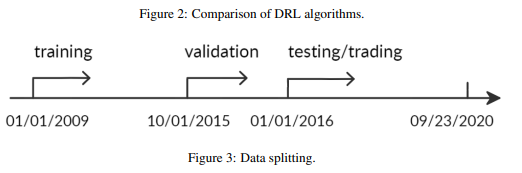

In [ ]:
#@title Define metric functions

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [ ]:
#@title compute metrics
import wandb
from typing import List
import numpy as np

def compute_metrics(account_values: List[pd.DataFrame, pd.Series, np.array], use_round=True):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, np.ndarray):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    metrics = {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

    if use_round:
        metrics = {k: round(v, 2) for k, v in metrics.items()}

    return metrics

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [ ]:
#@title log_metrics

def log_metrics_to_wandb(metrics, model_name, split_label, step=None):
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{key}/{model_name}": value for key, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [ ]:
#@title WandbLoggerCallback
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import pandas as pd
import numpy as np

class MetricLoggerCallback(BaseCallback):
    def __init__(self, model_name, split_label, verbose=0):
        super(MetricLoggerCallback, self).__init__(verbose)

        self.split_label = split_label
        self.model_name = model_name

    def _on_step(self) -> bool:
        env = self.training_env.envs[0]

        # Unwrap from Monitor if needed
        while isinstance(env, Monitor):
            env = env.env

        # Check if the episode is terminal
        env.terminal = env.day >= len(env.df.index.unique()) - 1
        if env.terminal:
            df_account_value = pd.DataFrame({
                self.model_name: env.asset_memory,
                'date': env.date_memory
            })

            # Compute metrics
            metrics = compute_metrics(df_account_value)
            # env_metrics = get_env_metrics(env)
            # metrics.update(env_metrics)

            # Log current model metrics
            log_metrics_to_wandb(metrics, self.model_name, self.split_label)

        return True

In [ ]:
#@title Custom DRLAgent (w/ wandb callback)
from finrl.agents.stablebaselines3.models import DRLAgent, TensorboardCallback
from stable_baselines3.common.callbacks import CallbackList
import wandb

class DRLAgent(DRLAgent):
    @staticmethod
    def train_model(
        model,
        tb_log_name,
        total_timesteps=5000,
        custom_callbacks=[],
        log_to_wandb=False
    ):
        # Ensure TensorboardCallback is always included
        tensorboard_callback = TensorboardCallback()

        # Initialize default callbacks
        metric_logger_callback = MetricLoggerCallback(
            model_name=tb_log_name,
            split_label='train',
            verbose=1,
            log_to_wandb=log_to_wandb
        )

        # Combine all callbacks (always include Tensorboard, SharpeRatio, and MaxSharpeRatio by default)
        callbacks_to_use = [
            tensorboard_callback,
            metric_logger_callback,
        ]

        if custom_callbacks:
            callbacks_to_use.extend(custom_callbacks)

        # Wrap all callbacks into a CallbackList
        combined_callback = CallbackList(callbacks_to_use)

        # Train the model with the combined callbacks
        model = model.learn(
            total_timesteps=total_timesteps,
            tb_log_name=tb_log_name,
            callback=combined_callback,
        )
        return model

In [ ]:
#@title train models

check_and_make_directories([TRAINED_MODEL_DIR])

env_train, _ = e_train_gym.get_sb_env()

# Set the corresponding values to 'True' for the algorithms that you want to use

# if_using_a2c = True
if_using_a2c = False

# if_using_ddpg = True
if_using_ddpg = False

# if_using_ppo = True
if_using_ppo = False

# if_using_td3 = True
if_using_td3 = False

# if_using_sac = True
if_using_sac = False

if if_using_a2c:
    print("training A2C agent")
    agent = DRLAgent(env = env_train)
    model_a2c = agent.get_model("a2c")

    # set up logger
    tmp_path = RESULTS_DIR + '/a2c'
    !rm -rf {tmp_path}/*
    new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_a2c.set_logger(new_logger_a2c)

    trained_a2c = agent.train_model(model=model_a2c,
                                    tb_log_name='a2c',
                                    # total_timesteps=50_000,
                                    total_timesteps=3500,
                                    ) if if_using_a2c else None

    trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
    update_model_artifacts()

if if_using_ddpg:
    print("training DDPG agent")
    agent = DRLAgent(env = env_train)
    model_ddpg = agent.get_model("ddpg")

    # set up logger
    tmp_path = RESULTS_DIR + '/ddpg'
    !rm -rf {tmp_path}/*
    new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_ddpg.set_logger(new_logger_ddpg)

    trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                            #  total_timesteps=50_000,
                             total_timesteps=3500
                            ) if if_using_ddpg else None

    trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
    update_model_artifacts()

if if_using_td3:
    print("training TD3 agent")
    agent = DRLAgent(env = env_train)
    TD3_PARAMS = {"batch_size": 100,
                "buffer_size": 1000000,
                "learning_rate": 0.001}

    model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/td3'
    !rm -rf {tmp_path}/*
    new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_td3.set_logger(new_logger_td3)

    trained_td3 = agent.train_model(model=model_td3,
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

    trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
    update_model_artifacts()

if if_using_sac:
    print("training SAC agent")
    agent = DRLAgent(env = env_train)
    SAC_PARAMS = {
        "batch_size": 128,
        "buffer_size": 100000,
        "learning_rate": 0.0001,
        "learning_starts": 100,
        "ent_coef": "auto_0.1",
    }

    model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

    # set up logger
    tmp_path = RESULTS_DIR + '/sac'
    !rm -rf {tmp_path}/*
    new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_sac.set_logger(new_logger_sac)

    trained_sac = agent.train_model(model=model_sac,
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None
    trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None
    update_model_artifacts()

if if_using_ppo:
    agent = DRLAgent(env = env_train)
    PPO_PARAMS = {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.00025,
        "batch_size": 128,
    }
    algo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
    # set up logger
    tmp_path = RESULTS_DIR + '/ppo'
    !rm -rf {tmp_path}/*
    new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    algo.set_logger(new_logger_ppo)

    trained_ppo = agent.train_model(model=algo,
                             tb_log_name='ppo',
                             total_timesteps=200000) if if_using_ppo else None

    trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None
    update_model_artifacts()

In [ ]:
# wandb.finish()

# Train SB3 vs RLLib models (np env)

## Init np env

In [ ]:
run_config = {
    'cost_pct': 0.001,
    'initial_amount': 50_000,
    'turbulence_threshold': 99,
    'if_vix': True
}

In [ ]:
#@title Init data
# date_range = date_ranges[1]

# #####################

# data_splits = split_data(preproc_df, date_range)
# train = data_splits['train']
# val = data_splits['val']
# print(train['date'].max() - train['date'].min())
# val.head()

In [ ]:
#@title Init StockTradingEnv (custom vectorization)

from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from copy import deepcopy

class StockTradingEnv(StockTradingEnv):
    def __init__(self, *args, if_async=False, n_envs=1, **kwargs, ):
        super().__init__(*args, **kwargs)
        self.n_envs = n_envs
        if if_async:
            self.vec_env_cls = SubprocVecEnv
            self.vec_env_kwargs = dict(start_method='fork')
        else:
            self.vec_env_cls = DummyVecEnv
            self.vec_env_kwargs = {}

    def get_sb_env(self):
        e = self.vec_env_cls([deepcopy(self) for _ in range(self.n_envs)], **self.vec_env_kwargs)
        # e = make_vec_env(deepcopy(self), n_envs=self.n_envs, vec_env_cls=self.vec_env_cls)
        obs = e.reset()
        return e, obs

def init_env(df, run_config, mode="", previous_state=None,
             if_async=False, n_envs=1):
    assert mode in ['train', 'val', 'test', ""]
    if mode:
        print(f"Initializing '{mode}' env.")

    stock_dimension = len(df.tic.unique())
    state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
    print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

    cost_pct = run_config['cost_pct']
    if isinstance(cost_pct, list):
        assert len(cost_pct) == stock_dimension
        buy_cost_pct = sell_cost_pct = cost_pct
    elif isinstance(cost_pct, (int, float)):
        buy_cost_pct = sell_cost_pct = [ run_config['cost_pct'] ] * stock_dimension
    else:
        raise ValueError

    num_stock_shares = [0] * stock_dimension

    print(f"Initializing env with initial amount: {previous_state[0] if previous_state is not None else run_config['initial_amount']}")
    env_kwargs = {
        "hmax": 100,
        "initial_amount": previous_state[0] if previous_state is not None else run_config['initial_amount'],
        "num_stock_shares": num_stock_shares,
        "buy_cost_pct": buy_cost_pct,
        "sell_cost_pct": sell_cost_pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "turbulence_threshold": run_config['turbulence_threshold'] if 'turbulence_threshold' in run_config else None,
        "print_verbosity": 1,
        "mode": mode,

        "initial": False if previous_state is not None else True,
        "previous_state": previous_state if previous_state is not None else [],
    }

    env_kwargs.update({
        'if_async': if_async,
        'n_envs': n_envs
    })

    e_train_gym = StockTradingEnv(df = df, **env_kwargs)
    # e_train_gym = e_train_gym.get_sb_env()
    return e_train_gym

In [ ]:
#@title load_cached_data
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.data_processor import DataProcessor
import hashlib

NY = "America/New_York"

CACHE_DIR = './cache'
os.makedirs(CACHE_DIR, exist_ok=True)

def stable_hash(data):
    return hashlib.sha256(str(data).encode()).hexdigest()

def load_cached_data(
    start_date,
    end_date,
    ticker_list=DOW_30_TICKER,
    technical_indicator_list=INDICATORS,
    time_interval='1d',
    if_vix=True,
    ignore_cache=False,
):

    data_hash = stable_hash(tuple(sorted(ticker_list) + sorted(technical_indicator_list) + [if_vix]))
    file_path = Path(CACHE_DIR) / f"{start_date}_{end_date}_{time_interval}_{data_hash}.csv"

    dp = DataProcessor(
        data_source='yahoofinance',
        tech_indicator=technical_indicator_list,
        vix=if_vix,
    )

    if os.path.isfile(file_path) and not ignore_cache:
        print(f"Using cached data: {file_path}")
        data = pd.read_csv(file_path, index_col=0)
        data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True) \
            .dt.tz_convert(NY).dt.tz_localize(None)

        return data, dp
    else:
        print("Creating new data.")

    data = dp.download_data(ticker_list, start_date, end_date, time_interval)
    data = dp.clean_data(data)
    if if_vix:
        data = dp.add_vix(data)
    else:
        data = dp.add_turbulence(data)
    data = dp.add_technical_indicator(data, technical_indicator_list)

    data.to_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'], utc=True) \
        .dt.tz_convert(NY).dt.tz_localize(None)
    return data, dp

In [ ]:
# date_range=date_ranges[0]
# data, data_processor = load_cached_data(
#     start_date=date_range['train_start_date'],
#     end_date=date_range['test_end_date'],
#     technical_indicator_list=INDICATORS + ['vix_63_sma'],
#     ignore_cache=False,
# )

In [ ]:
#@title load_cached_data (w/ tech indicator padding)
from pathlib import Path
from bisect import bisect_left
import pandas as pd

def load_cached_data(
    start_date: str,
    end_date: str,
    ticker_list=DOW_30_TICKER,
    technical_indicator_list=INDICATORS,
    extra_indicator_list=None,
    time_interval='1d',
    if_vix=True,
    ignore_cache=False,
    tech_indicator_padding=60,
):

    """
    Load data with a buffer of N trading days before start_date, so that
    rolling tech indicators can be computed properly within the environment.

    tech_indicator_padding: how many extra timestamps to load for correct tech indicators calculation
    """

    # Create the DataProcessor first so we can use .get_trading_days(...)
    dp = DataProcessor(
        data_source='yahoofinance',
        tech_indicator=technical_indicator_list,
        extra_indicator=extra_indicator_list,
        vix=if_vix,
    )

    # 1) Define a big offset (e.g. 6 months) before start_date to gather trading days
    #    (We assume 6 months is enough to include all desired tech_indicator_padding.)
    raw_buffer_start = pd.Timestamp(start_date) - pd.DateOffset(months=6)

    # 2) Get *all* trading days from that offset up to the real end_date
    all_trading_days = dp.processor.get_trading_days(
        start=str(raw_buffer_start.date()),
        end=str(pd.Timestamp(end_date).date())
    )

    # 3) Find the index of the first trading day >= start_date
    #    We compare strings "YYYY-MM-DD", so make sure to align formats.
    target_str = str(pd.Timestamp(start_date).date())
    i = bisect_left(all_trading_days, target_str)

    # 4) Subtract tech_indicator_padding from that index (clamp to zero)
    earliest_idx = max(0, i - tech_indicator_padding)
    actual_start_date = all_trading_days[earliest_idx]

    # Build a stable hash for caching
    data_hash = stable_hash(tuple(sorted(ticker_list)
                                  + sorted(technical_indicator_list)
                                  + sorted(extra_indicator_list) if extra_indicator_list else []
                                  + [if_vix, time_interval]))

    # File path includes the actual_start_date so we pick up correct caching
    file_path = Path(CACHE_DIR) / (
        f"{actual_start_date}_{end_date}_{time_interval}_{data_hash}.csv"
    )

    if file_path.is_file() and not ignore_cache:
        print(f"Using cached data: {file_path}")
        data = pd.read_csv(file_path, index_col=0)
        data['timestamp'] = (
            pd.to_datetime(data['timestamp'], utc=True)
              .dt.tz_convert(NY)
              .dt.tz_localize(None)
        )
        return data, dp
    else:
        print("Creating new data (no suitable cache).")
        # 5) Download from the earlier (buffered) start date
        data = dp.download_data(
            ticker_list=ticker_list,
            start_date=actual_start_date,
            end_date=end_date,
            time_interval=time_interval
        )

        data = dp.clean_data(data)
        # Add VIX or turbulence
        if if_vix:
            data = dp.add_vix(data)
        else:
            data = dp.add_turbulence(data)

        data = dp.add_technical_indicator(data, technical_indicator_list, extra_indicator_list)

        # -------------------------------------------
        # (6) Trim out rows before the *original* start_date
        # so that the final returned DataFrame is the "original size".
        start_ts = pd.Timestamp(start_date).tz_localize(NY)
        data = data[data["timestamp"] >= start_ts]
        data.reset_index(drop=True, inplace=True)
        # -------------------------------------------

        # Save to cache
        data.to_csv(file_path)

        # Convert timestamps
        data['timestamp'] = (
            pd.to_datetime(data['timestamp'], utc=True)
              .dt.tz_convert(NY)
              .dt.tz_localize(None)
        )

        return data, dp

In [ ]:
date_range=date_ranges[0]

# lookback_window = 63
# data, data_processor = load_cached_data(
#     start_date=date_range['train_start_date'],
#     end_date=date_range['test_end_date'],
#     technical_indicator_list=INDICATORS + [f'vix_{lookback_window}_sma'],
#     ignore_cache=False,
#     tech_indicator_padding=lookback_window,  # << in terms of trading days
# )

# # moving average should be different from the source value at each timestamp
# # so if padding was correctly applied, the first differing index should be 0
# data[data['vix'] == data['vix_63_sma']]
# first_diff_idx = (data['vix'] != data['vix_63_sma']).reset_index(drop=True).idxmax()
# print(f"first_diff_idx: {first_diff_idx}")
# data.iloc[first_diff_idx][['vix', 'vix_63_sma']]

In [159]:
#@title get_env_config

def get_env_config(
    data: pd.DataFrame,
    data_processor: DataProcessor,
    start_date,
    end_date,
    if_train,
    use_extra_indicators=False,
    if_extra_indicators_tech=False
):
    """
    Uses data_processor to convert data to array.
    WARNING: data_processor should be same as the one that was used to create the data.
    """

    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)

    data = data[(data['timestamp'] >= start_date) & (data['timestamp'] < end_date)]

    print(f'use_extra_indicators: {use_extra_indicators}')
    (
        price_array,
        tech_array,
        turbulence_array,
        timestamp_array,
        *extra_arrays
    ) = data_processor.df_to_array(
        data,
        return_timestamps=True,
        use_extra_indicators=use_extra_indicators,
        if_extra_indicators_tech=if_extra_indicators_tech
    )

    env_config = {
        "price_array": price_array,
        "tech_array": tech_array,
        "turbulence_array": turbulence_array,
        "timestamp_array": timestamp_array,
        "if_train": if_train
    }

    extra_cols = data_processor.extra_indicator_list
    env_config.update({
        col: array for col, array in zip(extra_cols, extra_arrays)
    })

    return env_config

In [ ]:
# train_np_env_config = get_env_config(
#     data,
#     data_processor,
#     start_date=date_range['train_start_date'],
#     end_date=date_range['val_start_date'],
#     if_train=True,
# )

# val_np_env_config = get_env_config(
#     data,
#     data_processor,
#     start_date=date_range['val_start_date'],
#     end_date=date_range['test_start_date'],
#     if_train=False,
# )

# for k, v in val_np_env_config.items():
#     if isinstance(v, np.ndarray):
#         print(k, v.shape)

# test_np_env_config = get_env_config(
#     data,
#     data_processor,
#     start_date=date_range['test_start_date'],
#     end_date=date_range['test_end_date'],
#     if_train=False,
# )

# train_np_env_config.keys()

In [ ]:
#@title Init StockTradingEnv (numpy)

from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
from finrl.meta.data_processor import DataProcessor
from finrl.config_tickers import DOW_30_TICKER
from finrl.config import INDICATORS
# from finrl.config import CACHE_DIR

def init_env(
    np_env_config,

    # run_config,
    initial_amount,
    cost_pct,

    mode,
    turbulence_threshold=99,
    initial_stocks=None
):
    assert mode in ['train', 'val', 'test']

    print(f"Initializing {'train' if np_env_config['if_train'] else 'eval'} env...", end=' ')
    env = StockTradingEnv(
        config=np_env_config,
        initial_capital=initial_amount,
        buy_cost_pct=cost_pct,
        sell_cost_pct=cost_pct,
        turbulence_thresh=turbulence_threshold,
        initial_stocks=np.array(initial_stocks) if isinstance(initial_stocks, list) else initial_stocks
    )
    print('Done.')

    return env

def create_stock_trading_env(env_config):
    return init_env(**env_config)

In [ ]:
# turbulence_thresh = 20
# turbulence_thresh = np.ones(len(val_np_env_config['turbulence_array'])) * turbulence_thresh

# env = init_env(
#     val_np_env_config,
#     initial_amount=run_config['initial_amount'],
#     cost_pct=run_config['cost_pct'],
#     turbulence_threshold=turbulence_thresh,
#     mode='val'
# )

# env.turbulence_bool

## Metric funcs

In [ ]:
#@title define metrics

def calculate_mdd(asset_values):
    """
    Calculate the Maximum Drawdown (MDD) of a portfolio.
    """
    running_max = asset_values.cummax()
    drawdown = (asset_values - running_max) / running_max
    mdd = drawdown.min() * 100  # Convert to percentage
    return mdd

def calculate_sharpe_ratio(asset_values, risk_free_rate=0.0):
    """
    Calculate the Sharpe Ratio of a portfolio.
    """
    # Calculate daily returns
    returns = asset_values.pct_change().dropna()
    excess_returns = returns - risk_free_rate / 252  # Assuming 252 trading days

    if excess_returns.std() == 0:
        return 0.0
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized
    return sharpe_ratio

def calculate_annualized_return(asset_values):
    """
    Calculate the annualized return of a portfolio.
    """
    # Assume `asset_values` is indexed by date or trading day
    total_return = (asset_values.iloc[-1] / asset_values.iloc[0] - 1) * 100
    num_days = (asset_values.index[-1] - asset_values.index[0]).days
    annualized_return = (1 + total_return) ** (365 / num_days) - 1
    return annualized_return

In [ ]:
#@title compute metrics
import wandb
from typing import List, Union
import numpy as np


def compute_metrics(account_values: List[Union[pd.DataFrame, pd.Series, np.array]]):
    """
    If DataFrame then should contain two columns - 'date' and name of algo, e.g. 'a2c'.
    """

    if isinstance(account_values, pd.DataFrame):
        assert isinstance(account_values, pd.DataFrame)
        if 'date' not in account_values.columns:
            if account_values.index.name == 'date':
                account_values.reset_index(inplace=True)
            else:
                raise ValueError("should contain 'date' column or index")
        account_values = account_values.dropna().set_index('date').iloc[:, 0]
    elif isinstance(account_values, (np.ndarray, list)):
        account_values = pd.Series(account_values)

    sharpe = calculate_sharpe_ratio(account_values)
    mdd = calculate_mdd(account_values)
    cum_ret = (account_values.iloc[-1] - account_values.iloc[0]) / account_values.iloc[0] * 100
    # num_days = (account_values.index.max() - account_values.index.min()).days
    num_days = len(account_values)
    ann_ret = ((1 + cum_ret / 100) ** (365 / num_days) - 1) * 100

    return {
            f'sharpe_ratio': sharpe,
            f'mdd': mdd,
            f'ann_return': ann_ret,
            f'cum_return': cum_ret,
        }

def get_env_metrics(env):
    end_total_asset = env.state[0] + sum(
        np.array(env.state[1 : (env.stock_dim + 1)])
        * np.array(env.state[(env.stock_dim + 1) : (env.stock_dim * 2 + 1)])
    )

    return {
        'begin_total_asset': env.asset_memory[0],
        'end_total_asset': end_total_asset,
        'total_cost': env.cost,
        'total_trades': env.trades,
    }

In [ ]:
#@title log_metrics_to_wandb

def log_metrics_to_wandb(
        metrics,
        model_name,
        split_label,
        step=None,
        metric_prefix=''
    ):

    print(f'log_metrics for {model_name}')
    assert model_name in ['a2c', 'ddpg', 'sac', 'ppo', 'td3', 'best_model', 'chosen_model']

    rename_metrics = lambda model_name: {
        f"{metric_prefix}{metric_name}/{model_name}": value for metric_name, value in metrics.items()
    }

    renamed_metrics = rename_metrics(model_name)
    wandb.log({split_label: renamed_metrics}, step=step)
    # wandb.run.save()

In [ ]:
#@title benchmark_exec_time
import pandas as pd
from time import perf_counter
from functools import wraps

def benchmark_exec_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):

        start = perf_counter()
        output = func(*args, **kwargs)
        end = perf_counter()

        exec_time_sec = end - start

        data = {
            "func_name": func.__name__,
            "exec_time_sec": exec_time_sec,
        }
        print(f'\nBenchmark results: {data}')
        return output, exec_time_sec

    return wrapper

## Train SB3

In [ ]:
#@title (SB3) MetricLoggerCallback (np env)
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor

import pandas as pd
import numpy as np

class MetricLoggerCallback(BaseCallback):
    def __init__(self, model_name, split_label, verbose=0, log_to_wandb=False):
        super(MetricLoggerCallback, self).__init__(verbose)

        self.split_label = split_label
        self.model_name = model_name
        self.log_to_wandb = log_to_wandb

    def _on_step(self) -> bool:
        if self.training_env is not None:
            env = self.training_env.envs[0]
        elif self.eval_env is not None:
            env = self.eval_env.envs[0]

        # Unwrap from Monitor if needed
        while isinstance(env, Monitor):
            env = env.env

        # Check if the episode is terminal
        env_terminal = env.day >= env.price_ary.shape[0] - 2
        if env_terminal:
            df_account_value = env.save_asset_memory()
            metrics = compute_metrics(df_account_value)

            # Log current model metrics
            if self.log_to_wandb:
                log_metrics_to_wandb(metrics, self.model_name, self.split_label)

        return True

In [ ]:
#@title EvalMetricLoggerCallback (using evaluate_policy)

from stable_baselines3.common.callbacks import EvalCallback, BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np

def metric_logger_callback(locals_, globals_):
    """
    Function-based callback for evaluate_policy() that logs metrics once
    an episode finishes. Supports both single and multi-environment setups.

    :param locals_: dict of local variables in evaluate_policy (contains 'env', 'done', etc.)
    :param globals_: dict of global variables in evaluate_policy
    :return: (bool) If the evaluation loop should continue (always True here)
    """
    env = locals_["env"]         # Vectorized or single environment
    n_envs = locals_["n_envs"]   # Number of parallel environments
    done = locals_["done"]       # Bool or array of bool if n_envs > 1

    # For single environment, done is just a bool
    # For multiple environments, done is an array of bool of length n_envs
    if n_envs == 1:
        # Unwrap any DummyVecEnv or Monitor wrappers
        base_env = env

        # Unwrap DummyVecEnv
        while hasattr(base_env, "envs"):
            base_env = base_env.envs[0]

        # print(f"Done env day: {base_env.day}")
        done = base_env.day >= base_env.price_ary.shape[0] - 2
        if done:
            # print(f"Env finished on day: {base_env.day}")

            # Now we have the real environment
            df_account_value = base_env.save_asset_memory()
            metrics = compute_metrics(df_account_value)
            print("[metric_logger_callback] Single-env metrics:", metrics)
    else:
        # Multi-env case
        # We may accumulate metrics for each env that just finished
        # and optionally average them after all are done
        finished_env_indices = np.where(done)[0]  # Indices of envs that are done
        if len(finished_env_indices) > 0:
            metrics_list = []
            for i in finished_env_indices:
                df_account_value = env.get_attr("save_asset_memory", indices=i)[0]
                metrics_i = compute_metrics(df_account_value)
                metrics_list.append(metrics_i)
                print(f"[metric_logger_callback] Env #{i} metrics: {metrics_i}")

            # Optionally average metrics across finished envs
            if len(metrics_list) > 1:
                # Ensure all metrics have the same keys
                avg_metrics = {}
                for key in metrics_list[0].keys():
                    avg_metrics[key] = np.mean([m[key] for m in metrics_list])
                print("[metric_logger_callback] Average metrics of finished envs:", avg_metrics)

    return True  # Return True to continue evaluation

class EvalMetricLoggerCallback(EvalCallback):
    def __init__(self, eval_env, model_name, split_label, log_to_wandb=False, **kwargs):
        """
        Custom EvalCallback that logs evaluation metrics using `evaluate_policy()`.
        """
        super().__init__(eval_env, **kwargs)
        self.split_label = split_label
        self.model_name = model_name
        self.log_to_wandb = log_to_wandb
        self.metric_logger = MetricLoggerCallback(model_name, split_label, log_to_wandb)

    def _on_step(self) -> bool:
        """
        Runs `evaluate_policy()` with `MetricLoggerCallback` and logs results after evaluation.
        """
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            # Evaluate using `evaluate_policy()`, passing `MetricLoggerCallback`
            evaluate_policy(
                self.model,
                self.eval_env,
                n_eval_episodes=self.n_eval_episodes,
                deterministic=self.deterministic,
                render=self.render,
                warn=self.warn,
                # callback=self.metric_logger._on_step  # 🔹 Logs metrics after evaluation
                callback=metric_logger_callback
            )

        return super()._on_step()  # Run default EvalCallback logic

In [ ]:
#@title SB3 train/val configs

# import torch
# from stable_baselines3.common.callbacks import EvalCallback

# model_name = 'ppo'
# log_to_wandb = False

# train_env_config = {
#     "initial_amount": run_config['initial_amount'],
#     "cost_pct": run_config['cost_pct'],
#     "mode": 'train',
#     'np_env_config': train_np_env_config
# }

# val_env_config = {
#     "initial_amount": run_config['initial_amount'],
#     "cost_pct": run_config['cost_pct'],
#     "mode": 'val',
#     'np_env_config': val_np_env_config
# }

# PPO_PARAMS = {
#     "n_steps": 2048, # rllib batch_size
#     "n_epochs": 10,
#     "batch_size": 128, # rllib minibatch_size

#     "ent_coef": 0.01,
#     "learning_rate": 0.00025,
#     "device": "cuda" if torch.cuda.is_available() else 'cpu'
# }

In [ ]:
#@title Train SB3 model

@benchmark_exec_time
def _train_sb3(total_timesteps=200_000, custom_callbacks=[], log_to_wandb=False):
    trained_model = agent.train_model(
        model=algo,
        tb_log_name='ppo',
        total_timesteps=total_timesteps,
        custom_callbacks=custom_callbacks,
        log_to_wandb=log_to_wandb
    )

# if log_to_wandb:
#     wandb.finish()
#     wandb.init(ENTITY, PROJECT)

# train_env = init_env(**train_env_config)
# val_env = init_env(**val_env_config)

# eval_callback = EvalMetricLoggerCallback(
#     eval_env=val_env,
#     model_name="ppo",
#     split_label="val",
#     log_to_wandb=log_to_wandb,
#     eval_freq=250,  # Evaluate every 1k steps
#     deterministic=True,
#     render=False
# )

# # eval_callback = EvalCallback(
# #     eval_env=val_env,
# #     callback_after_eval=MetricLoggerCallback(
# #         model_name="ppo",
# #         split_label="val",
# #         log_to_wandb=log_to_wandb,
# #     ),
# #     eval_freq=1000,  # Evaluate every 1k steps
# #     deterministic=True,
# #     render=False
# # )

# agent = DRLAgent(env = train_env)
# algo = agent.get_model("ppo", model_kwargs = PPO_PARAMS)
# new_logger_ppo = configure(RESULTS_DIR + '/ppo', ["stdout", "csv", "tensorboard"])
# algo.set_logger(new_logger_ppo)

# _train_sb3(
#     500,
#     custom_callbacks=[eval_callback],
#     log_to_wandb=log_to_wandb
# )

In [ ]:
#@title FUNC: evaluate_model (sb3)

def evaluate_model(algo, model_name, mode, np_env_config, run_config, turbulence_thresh=None,
                   log_to_wandb=False):

    if turbulence_thresh is None:
        turbulence_thresh = run_config.get('turbulence_thresh', 99)

    turbulence_name = 'turbulence' if not run_config.get('if_vix', None) else 'vix'
    print(f"Evaluating for `{mode}` using `{turbulence_name}`: {turbulence_thresh}")

    env_config = {
        # "df": val,
        "np_env_config": np_env_config,
        # "run_config": run_config,

        "initial_amount": run_config['initial_amount'],
        "cost_pct": run_config['cost_pct'],

        "mode": mode,
        'turbulence_threshold': turbulence_thresh
    }

    eval_env = create_stock_trading_env(env_config)

    # Reset the environment
    state, info = eval_env.reset()
    done = False

    while not done:
        # Predict action using the trained SB3 model
        action, _ = algo.predict(state, deterministic=True)

        # Clip action to ensure it's within valid bounds
        action = np.clip(action, eval_env.action_space.low, eval_env.action_space.high)

        # Perform the action in the environment
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated

    df_account_value = eval_env.save_asset_memory()
    metrics = compute_metrics(df_account_value)
    print(metrics)

    if log_to_wandb:
        turbulence_log_name = 'ti' if not run_config.get('if_vix', None) else 'vix'
        for metric_name, metric_value in metrics.items():
            metric_name = f"{mode}.{turbulence_log_name}_{turbulence_thresh}.{metric_name}/{model_name}"
            wandb.run.summary[metric_name] = metric_value

    turbulence_series = pd.Series(
        np_env_config['turbulence_array'][:len(df_account_value)],
        index=df_account_value['date'],
        name=turbulence_name
    )

    eval_result = {
        'account_value': df_account_value.rename(columns={'account_value': model_name}),
        'turbulence_series': turbulence_series,
        'turbulence_thresh': turbulence_thresh
    }

    return eval_result

In [ ]:
#@title evaluate_model (sb3)

# train_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = train_np_env_config,
#     mode='train',
#     log_to_wandb=log_to_wandb
# )

# val_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = val_np_env_config,
#     mode='val',
#     log_to_wandb=log_to_wandb
# )

# test_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = test_np_env_config,
#     mode='test',
#     log_to_wandb=log_to_wandb
# )

In [ ]:
# %timeit -n 1 -r 2 _train_sb3(int(50_000 / env_config['n_envs']))

## Train RLLib

In [ ]:
import ray

ray.shutdown()
ray.init()

2025-02-25 07:46:15,834	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.11
Ray version:,2.42.1
Dashboard:,http://127.0.0.1:8265


In [ ]:
#@title MetricsLoggerCallback (class)
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from typing import Optional, Sequence
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv

class MetricsLoggerCallback(DefaultCallbacks):
    def __init__(self, model_name, ema_coeff=0.2, ma_window=20, log_to_wandb=False):
        super().__init__()

        self.model_name = model_name
        self.ema_coeff = ema_coeff
        self.ma_window = ma_window
        self.metric_names = set()
        self.log_to_wandb = log_to_wandb

    def unwrap_env(self, env):
        env = env.unwrapped
        # print(type(env))
        # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.vector.sync_vector_env.SyncVectorEnv'>

        if isinstance(env, AsyncVectorEnv):
            return env
        else:
            env = env.envs[0]
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.OrderEnforcing'>

            env = env.env
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'gymnasium.wrappers.common.PassiveEnvChecker'>

            env = env.env
            # print(type(env))
            # (SingleAgentEnvRunner pid=127688) <class 'finrl.meta.env_stock_trading.env_stocktrading.StockTradingEnv'>
        return env

    def on_episode_step(
            self,
            *,
            episode,
            env_runner,
            metrics_logger,
            env,
            env_index,
            rl_module,
            **kwargs,
        ) -> None:

        env = self.unwrap_env(env)

        if isinstance(env, AsyncVectorEnv):
            asset_values = env.get_attr('asset_memory')
            asset_values = pd.concat([pd.Series(av) for av in asset_values], axis=1).mean(axis=1)

            # TODO: save_asset_memory
            raise NotImplementedError
        else:
            # asset_values = env.asset_memory
            asset_values = env.save_asset_memory()

        # print(f"Env {env_index} day: {env.day}")
        metrics = compute_metrics(asset_values)

        # mode = env.mode
        for metric_name, metric_value in metrics.items():
            # metric_name = f"{mode}/{metric_name}" if mode != "" else metric_name
            episode.add_temporary_timestep_data(metric_name, metric_value)
            self.metric_names.update([metric_name])

    def on_episode_end(
            self,
            *,
            episode,
            env_runner,
            metrics_logger,
            env,
            env_index,
            rl_module,
            **kwargs,
        ) -> None:

        for metric_name in self.metric_names:
            metric_values = episode.get_temporary_timestep_data(metric_name)
            metric_value = np.nanmean(np.array(metric_values))

            metrics_logger.log_value(
                metric_name,
                metric_value,
                reduce='mean',
            )

            metrics_logger.log_value(
                f"{metric_name}_EMA_{self.ema_coeff}",
                metric_value,
                reduce='mean',
                ema_coeff=self.ema_coeff
            )

            metrics_logger.log_value(
                f"{metric_name}_MA_{self.ma_window}",
                metric_value,
                reduce='mean',
                window=self.ma_window
            )

            # mode = 'val' if env_runner.config.in_evaluation else 'train'
            # if mode == 'val':
            #     print({
            #         f"{mode}.{metric_name}/{self.model_name}": metric_value,
            #     }) # TODO: log on every episode step

            if self.log_to_wandb:
                mode = 'val' if env_runner.config.in_evaluation else 'train'
                wandb.log({
                    f"{mode}.{metric_name}/{self.model_name}": metric_value,
                }) # TODO: log on every episode step

In [ ]:
#@title print_result

RESULT_KEYS_TO_INCLUDE = [
    'sharpe_ratio',
    'ann_return',
    'mdd',

    # 'sharpe_ratio_MA',
    # 'ann_return_MA',
    # 'mdd_MA',

    # 'sharpe_ratio_EMA',
    # 'ann_return_EMA',
    # 'mdd_EMA',
]

def print_result(result):
    print()
    print('-' * 40)

    keys_to_print = [
        key
        for include_key in RESULT_KEYS_TO_INCLUDE
        for key in result['env_runners'].keys()
        if key.startswith(include_key)
    ]

    for key in sorted(keys_to_print):
        print(f"train/{key}: {round(result['env_runners'][key], 2)}")

    print('*' * 40)
    keys_to_print = [
        key
        for include_key in RESULT_KEYS_TO_INCLUDE
        for key in result['evaluation']['env_runners'].keys()
        if key.startswith(include_key)
    ]

    for key in sorted(keys_to_print):
        print(f"val/{key}: {round(result['env_runners'][key], 2)}")

    print('-' * 40)
    print()

In [ ]:
# train, val, test using DRL_prediction()
# test using DRL_prediction()

In [ ]:
model_name = 'ppo'
num_envs_per_env_runner = 1
num_env_runners = 0
log_to_wandb = True

In [ ]:
#@title Define RLlib model

from functools import partial
from pathlib import Path
from ray.rllib.algorithms.ppo import PPOConfig
import torch
from ray.tune.registry import register_env
from time import perf_counter
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig

AVAILABLE_MODELS = ['ppo']

def create_stock_trading_env(env_config):
    return init_env(**env_config)

def build_model():
    assert model_name in AVAILABLE_MODELS
    register_env("stock_trading_env", create_stock_trading_env)

    run_timer_start = perf_counter()

    if log_to_wandb:
        wandb.finish()
        wandb.init(ENTITY, PROJECT)

    config = (
        PPOConfig()
        .environment(
            env="stock_trading_env",
            env_config={
                # "df": train,
                "np_env_config": current_train_np_env_config,

                # "run_config": run_config,
                "initial_amount": run_config['initial_amount'],
                "cost_pct": run_config['cost_pct'],

                "mode": 'train'
            },
        )
        .env_runners(
            batch_mode="complete_episodes",
            num_envs_per_env_runner=num_envs_per_env_runner,
            num_env_runners=num_env_runners,
            num_cpus_per_env_runner= (2/num_env_runners) if num_env_runners > 2 else None,

            # gym_env_vectorize_mode=gym.envs.registration.VectorizeMode.ASYNC,
        )
        .training(
            train_batch_size=2048,
            num_epochs=10,
            minibatch_size=128,
        )
        # .experimental(
        #     _validate_config=False
        # )
        .evaluation(
            # Set up the validation environment
            evaluation_interval=1,  # Specify evaluation frequency (1=after each training step)
            # evaluation_parallel_to_training=True,
            # evaluation_duration=2,

            # evaluation_config=AlgorithmConfig.overrides(**{
            #     "explore": False,
            #     "env": "stock_trading_env",
            #     "env_config": {
            #         # "df": val,
            #         "np_env_config": val_np_env_config,

            #         # "run_config": run_config,
            #         "initial_amount": run_config['initial_amount'],
            #         "cost_pct": run_config['cost_pct'],

            #         "mode": 'val'
            #     },
            # }),

            evaluation_config={
                "explore": False,
                "env": "stock_trading_env",
                "env_config": {
                    # "df": val,
                    "np_env_config": val_np_env_config,

                    # "run_config": run_config,
                    "initial_amount": run_config['initial_amount'],
                    "cost_pct": run_config['cost_pct'],

                    "mode": 'val'
                },
            },
        )
        # .callbacks(MetricsLoggerCallback)
        .callbacks(partial(MetricsLoggerCallback, model_name='ppo', log_to_wandb=log_to_wandb))
        .resources(
            num_gpus=1 if torch.cuda.is_available() else None
        )
    )

    # 2. build the algorithm ..
    if config.num_env_runners > 0:
        ray.shutdown()
        ray.init()

        register_env("stock_trading_env", create_stock_trading_env)

    algo = config.build()
    return algo

In [ ]:
# algo = build_model()

In [ ]:
#@title Train RLlib model

# 3. .. train it ..
from math import ceil

@benchmark_exec_time
def _train_rllib(algo, total_timesteps=200_000):
    results = []
    total_batches = ceil(total_timesteps / algo.config.train_batch_size)
    print(f"total_batches: {total_batches}")
    print(f"total_timesteps: {total_timesteps}")
    for _ in range(total_batches):
        result = algo.train()
        results.append(result)

    print_result(result)
    return results

def train_model(algo):
    print(f"Envs: {algo.config.num_envs_per_env_runner}, Runners: {algo.config.num_env_runners}")

    results, exec_time_sec = _train_rllib(algo, 2_048 * 1)
    os.makedirs(TRAINED_MODEL_DIR, exist_ok=True)
    if log_to_wandb:
        duration_minutes = round(exec_time_sec / 60, 1)
        wandb.run.summary[f"train.duration_minutes/{model_name}"] = duration_minutes

    ckpt_path = (Path(TRAINED_MODEL_DIR) / model_name).resolve()
    dir = algo.save(ckpt_path)
    if log_to_wandb:
        update_model_artifacts(log_results_folder=False)

In [ ]:
# train_model(algo)

In [ ]:
# results, _ = _train_rllib(2_048)
# %timeit -n 1 -r 1 _train_rllib(2_048)

In [ ]:
#@title aggregate_results

import pandas as pd

def aggregate_results(results):
    """
    Combines all metrics from a list of results into a single DataFrame.

    Args:
        results (list): A list of result dictionaries with train and validation metrics.

    Returns:
        pd.DataFrame: A DataFrame containing the combined metrics.
    """
    metrics = []

    for i, result in enumerate(results):
        row = {'iteration': i + 1}  # Add iteration number
        for key in result['env_runners'].keys():
            if any(include_key in key for include_key in RESULT_KEYS_TO_INCLUDE):
                row[f"train/{key}"] = round(result['env_runners'][key], 2)
                row[f"val/{key}"] = round(result['evaluation']['env_runners'].get(key, float('nan')), 2)  # Use `.get()` for safety
        metrics.append(row)

    return pd.DataFrame(metrics)

In [ ]:
#@title plot_metrics
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metrics(df, average_mode=None):
    """
    Plots all metrics on the same figure with different axes for train and validation metrics.

    Args:
        df (pd.DataFrame): Dataframe containing metrics.
        average_mode (str): Average mode to filter metrics ('EMA' or 'MA').
    """
    assert average_mode in ('EMA', 'MA', None)

    if average_mode is None:
        average_mode = ''
    else:
        average_mode = '_' + average_mode

    # Extract metric keys based on average_mode
    metric_keys = [f'sharpe_ratio{average_mode}', f'ann_return{average_mode}', f'mdd{average_mode}']
    train_keys = [key for key in df.columns if any([key.removeprefix('train/').startswith(metric_key) for metric_key in metric_keys])]
    val_keys = [key for key in df.columns if any([key.removeprefix('val/').startswith(metric_key) for metric_key in metric_keys])]
    print(metric_keys)
    print(val_keys, train_keys)

    # Set up the figure and the main axis
    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Sharpe Ratio", color="tab:blue")

    # Plot the first metric on the main axis
    ax1.plot(df['iteration'], df[train_keys[0]], label=f"Train {metric_keys[0]}", color="tab:blue", linestyle="-")
    ax1.plot(df['iteration'], df[val_keys[0]], label=f"Val {metric_keys[0]}", color="tab:blue", linestyle="--")
    # ax1.legend(loc="upper left")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Create the second y-axis for the second metric
    ax2 = ax1.twinx()
    ax2.set_ylabel("Annual Return", color="tab:green")
    ax2.plot(df['iteration'], df[train_keys[1]], label=f"Train {metric_keys[1]}", color="tab:green", linestyle="-")
    ax2.plot(df['iteration'], df[val_keys[1]], label=f"Val {metric_keys[1]}", color="tab:green", linestyle="--")
    ax2.tick_params(axis="y", labelcolor="tab:green")

    # Create the third y-axis for the third metric
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))  # Offset the third y-axis
    ax3.set_ylabel("Maximum Drawdown", color="tab:red")
    ax3.plot(df['iteration'], df[train_keys[2]], label=f"Train {metric_keys[2]}", color="tab:red", linestyle="-")
    ax3.plot(df['iteration'], df[val_keys[2]], label=f"Val {metric_keys[2]}", color="tab:red", linestyle="--")
    ax3.tick_params(axis="y", labelcolor="tab:red")

    # Add a title and show the plot
    plt.title(f"Metrics Comparison ({average_mode})")
    fig.tight_layout()  # Ensure proper layout
    plt.show()


In [ ]:
# results_agg = aggregate_results(results)
# results_agg.tail()

# plot_metrics(
#     results_agg,
#     average_mode=None
#     # average_mode='EMA'
# )

In [ ]:
#@title get_formatted_metric_name

def get_formatted_metric_name(
    model_name,
    metric_name,
    split_label,
    turbulence_log_name=None,
    turbulence_thresh=None,
    turbulence_thresh_postfix=None,
    metric_prefix=None,
    quantile_log_name=None,
    quantile_thresh = None
):
    assert turbulence_thresh_postfix in ['best', 'chosen', None]
    # assert quantile_log_name in ['q', 'qe', None]

    if turbulence_log_name is not None:
        assert turbulence_thresh is not None

    if quantile_log_name is not None:
        assert turbulence_thresh is None and turbulence_log_name is None
        assert quantile_thresh is not None and 0 <= quantile_thresh <= 1

    formatted_name = (
        f"{split_label}"

        # Quantile name + thresh
        f"{'.' + quantile_log_name if quantile_log_name else ''}"
        f"{'_' + str(round(quantile_thresh * 100)) if quantile_thresh else ''}"

        # Turbulence name + thresh
        f"{'.' + turbulence_log_name if turbulence_log_name else ''}"
        f"{'_' + str(turbulence_thresh) if turbulence_thresh else ''}"
        f"{'_' + turbulence_thresh_postfix if turbulence_thresh_postfix else ''}"

        f".{metric_prefix + '_' if metric_prefix else ''}{metric_name}/"
        f"{model_name}"
    )
    return formatted_name


formatted_name = get_formatted_metric_name(
    model_name,
    metric_name='sharpe_ratio',
    split_label='val',
    # turbulence_log_name='vix',
    # turbulence_thresh=99,
    metric_prefix='agg',
    quantile_log_name='q',
    quantile_thresh = 0.25
)

formatted_name

'val.q_25.agg_sharpe_ratio/ppo'

In [ ]:
#@title log_eval_results

def log_eval_results(
        model_name,
        metrics,
        split_label,
        turbulence_log_name=None,
        turbulence_thresh=None,
        run=None,
        turbulence_thresh_postfix=None,
        metric_prefix=None,
        quantile_log_name=None,
        quantile_thresh = None
    ):

    # if run is None:
    #     run = wandb.run
    #     assert run is not None, "If no run is provided, wandb should contain an active run"

    assert isinstance(run, wandb.apis.public.runs.Run), "Use API instead of SDK"

    for metric_name, metric_value in metrics.items():
        formatted_name = get_formatted_metric_name(
            model_name,
            metric_name,
            split_label,
            turbulence_log_name,
            turbulence_thresh,
            metric_prefix=metric_prefix,
            quantile_log_name=quantile_log_name,
            quantile_thresh = quantile_thresh
        )

        run.summary[formatted_name] = np.round(metric_value, decimals=2).tolist()  # Use formatted_name instead

    run.summary.update() # for API only


# log_eval_results(
#     model_name,
#     metrics={'sharpe_ratio': 1.5},
#     split_label='val',
#     # turbulence_log_name='vix',
#     # turbulence_thresh=99,
#     run=None,
#     metric_prefix='agg',
#     quantile_log_name='q',
#     quantile_thresh = 0.25
# )

In [ ]:
#@title get_config_hash

import json
from hashlib import sha256

def dict_to_canonical_string(cfg_dict):
    return json.dumps(cfg_dict, sort_keys=True)

def get_config_hash(run_config):
    config_seed = run_config['seed']
    config_training_params = run_config['training_params']
    config_canonical_str = dict_to_canonical_string({
        'seed': config_seed,
        'training_params': config_training_params
    })
    config_hash = sha256(config_canonical_str.encode()).hexdigest()
    return config_hash

In [ ]:
#@title find_previous_run (sweep)

WANDB_API = wandb.Api()

def find_prev_run(sweep_id, curr_run_id):
    global WANDB_API

    sweep_runs = WANDB_API.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}").runs
    curr_run = WANDB_API.run(f"{ENTITY}/{PROJECT}/{curr_run_id}")

    prev_run = None
    for run in sweep_runs:
        # find run with same `hash_config`
        # and current previous `test_start_date == current `val_start_date`
        if run.summary['config_hash'] == curr_run.summary['config_hash'] \
        and run.config['date_range']['test_start_date'] == curr_run.config['date_range']['val_start_date']:
            prev_run = run
            break

    return prev_run

SWEEP_ID = 'yd7fz9as'
CURR_RUN_ID = 'rbug5oxn'
prev_run = find_prev_run(SWEEP_ID, CURR_RUN_ID)
prev_run.id

'dcl4jcb8'

In [ ]:
#@title RLLib_prediction
from ray.rllib.core.columns import Columns

def RLLib_prediction(
    model_name,
    rl_module,
    eval_env,
):
    state, info = eval_env.reset()
    done = False
    print(f'\t initial_total_asset: {eval_env.initial_total_asset}')

    while not done:
        # Compute action using the RLlib trained agent
        input_dict = {Columns.OBS: torch.Tensor(state).unsqueeze(0)}

        # print("input_dict:")
        # for k, v in input_dict.items():
        #     print(k, v.shape)

        rl_module_out = rl_module.forward_inference(input_dict)
        logits = rl_module_out[Columns.ACTION_DIST_INPUTS]

        # Take mean of multivariate Gaussian distribution
        mean, log_std = logits.chunk(2, dim=-1)

        # action_distribution = TorchDiagGaussian.from_logits(logits)
        # action_distribution = action_distribution.to_deterministic()
        # assert np.allclose(mean, action_distribution.loc)
        # assert np.allclose(log_std.exp(), action_distribution._dist.scale)
        # action = action_distribution.sample()

        action = mean.detach().numpy().squeeze()

        # Clip the action to ensure it's within the action space bounds
        action = np.clip(action, eval_env.action_space.low, eval_env.action_space.high)

        # Perform action
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done = terminated or truncated

    df_account_values = eval_env.save_asset_memory()
    df_account_values = df_account_values.rename(columns={'account_value': model_name.upper()})

    # HACK: hardcoded timezone
    # TODO: transfer timezone handling to FinRL
    # df_account_value['date'] = pd.to_datetime(df_account_value['date'], utc=True).dt.tz_convert(NY)
    return df_account_values

# env_config = {
#     "np_env_config": val_np_env_config,

#     "initial_amount": run_config['initial_amount'],
#     "initial_stocks": None,
#     "cost_pct": run_config['cost_pct'],

#     "mode": 'val',
#     'turbulence_threshold': 99
# }

# eval_env = create_stock_trading_env(env_config)
# rl_module = algo.env_runner.module
# df_account_value = RLLib_prediction(
#     model_name,
#     rl_module,
#     eval_env,
# )

# df_account_value.head()

In [ ]:
#@title add DIJA (deprecated)

def add_djia(df_account_value, run_config):
    # Download DIJA
    df_djia = YahooDownloader(
        start_date=df_account_value['date'].iloc[0],
        end_date=df_account_value['date'].iloc[-1] + pd.Timedelta(days=1),
        ticker_list=['^DJI'] # `dji` is delisted, `DJIA` is an ETF, not an index
    ).fetch_data()


    # Scale DJIA data
    df_djia = df_djia[['date','close']]
    fst_day = df_djia['close'].iloc[0]
    df_djia = pd.DataFrame({
        'date': df_djia['date'],
        'DJIA': df_djia['close'].div(fst_day).mul(run_config['initial_amount']).values,
    })

    # Convert `date` to datetime
    df_account_value['date'] = pd.to_datetime(df_account_value['date'], utc=True).dt.tz_convert(NY).dt.date
    df_account_value['date'] = pd.to_datetime(df_account_value['date'])
    df_djia['date'] = pd.to_datetime(df_djia['date'])

    # Merge DJIA data
    df_account_value = pd.merge(
        df_account_value,
        df_djia,
        on='date',
        how='inner',
    ).fillna(method='bfill')

    return df_account_value

# df_account_value = add_djia(df_account_value, run_config)
# print(df_account_value.shape)
# df_account_value.head()

In [ ]:
#@title load DIJA

def load_djia(
        start_date,
        end_date,
        initial_amount
    ):

    """
    Load prices of index scaled by initial amount
    """

    # Download DIJA
    df_djia = YahooDownloader(
        start_date = start_date,
        end_date = end_date + pd.Timedelta(days=1), # include last day
        ticker_list=['^DJI'] # `dji` is delisted, `DJIA` is an ETF, not an index
    ).fetch_data()


    # Scale DJIA data
    df_djia = df_djia[['date','close']]
    fst_day = df_djia['close'].iloc[0]
    df_djia = pd.DataFrame({
        'date': df_djia['date'],
        'DJIA': df_djia['close'].div(fst_day).mul(initial_amount).values,
    })

    df_djia['date'] = pd.to_datetime(df_djia['date'])

    return df_djia

In [ ]:
#@title log djia metrics per split (deprecated)

# df_djia_per_split = {}

# df_djia_per_split['val'] = load_djia(
#     start_date=date_range['val_start_date'],
#     end_date=date_range['test_start_date'],
# )

# df_djia_per_split['test'] = load_djia(
#     start_date=date_range['test_start_date'],
#     end_date=date_range['test_end_date'],
# )

# df_djia_per_split['val'].head()

# for split_label, df_djia in df_djia_per_split.items():
#     djia_metrics = compute_metrics(df_djia)
#     log_eval_results(
#         'djia',
#         djia_metrics,
#         split_label,
#     )

#     print(djia_metrics)

In [ ]:
#@title Evaluate RLlib model
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.utils.numpy import convert_to_numpy, softmax
from ray.rllib.models.torch.torch_distributions import TorchDiagGaussian
from ray.rllib.core.rl_module.rl_module import RLModule
import torch

# Create the testing environment
def evaluate_model(
    algo_or_rl_module,
    model_name,
    split_label,
    np_env_config,
    run_config,
    turbulence_thresh=None,
    log_to_wandb=False,
    return_metrics=False,

    prev_end_amount=None,
    prev_end_stocks=None,

    # insample_threshold_quantile = None,
    # is_expanding_insample = False
):
    assert (prev_end_amount is None) == (prev_end_stocks is None), (
        "Either both prev_end_amount and prev_end_stocks must be None, "
        "or both must be non-None."
    )

    if turbulence_thresh is None:
        turbulence_thresh = run_config.get('turbulence_thresh', 99)

    turbulence_name = 'turbulence' if not run_config.get('if_vix', None) else 'vix'
    print(f"\nEvaluating for `{split_label}` using `{turbulence_name}`: {turbulence_thresh}")

    if prev_end_stocks is not None:
        initial_amount = prev_end_amount
        initial_stocks = prev_end_stocks
        print("Init with previous env state:")
    else:
        initial_amount = run_config['initial_amount']
        initial_stocks = None
        print("Init with NEW env state:")

    print(f"\t initial_amount: {initial_amount}")
    print(f"\t initial_stocks: {initial_stocks}")

    env_config = {
        "np_env_config": np_env_config,

        "initial_amount": initial_amount,
        "initial_stocks": initial_stocks,
        "cost_pct": run_config['cost_pct'],

        "mode": split_label,
        'turbulence_threshold': turbulence_thresh
    }

    eval_env = create_stock_trading_env(env_config)
    _ = eval_env.reset()

    env_metrics = {
        'start_amount': eval_env.amount,
        'start_stocks': eval_env.stocks,
        'start_total_asset': eval_env.total_asset
    }

    # Extract rl_module if using Algorithm
    if isinstance(algo_or_rl_module, Algorithm):
        rl_module = algo_or_rl_module.env_runner.module
    elif isinstance(algo_or_rl_module, RLModule):
        rl_module = algo_or_rl_module
    else:
        raise NotImplementedError

    df_account_value = RLLib_prediction(
        model_name,
        rl_module,
        eval_env,
    )

    metrics = compute_metrics(df_account_value)
    env_metrics.update({
        'end_amount': eval_env.amount,
        'end_stocks': eval_env.stocks,
        'end_total_asset': eval_env.total_asset
    })

    print("Env metrics after evaluation:")
    for k, v in env_metrics.items():
        print(f"{k}: {v}")

    metrics.update(env_metrics)

    turbulence_series = pd.Series(
        np_env_config['turbulence_array'][:len(df_account_value)],
        index=df_account_value['date'],
        name=turbulence_name
    )

    eval_result = {
        'account_value': df_account_value,
        'turbulence_series': turbulence_series,
        'turbulence_thresh': turbulence_thresh
    }

    # optionally log to wandb
    if log_to_wandb:
        turbulence_log_name = 'ti' if not run_config.get('if_vix', None) else 'vix'
        log_eval_results(
            model_name,
            metrics,
            split_label,
            turbulence_log_name,
            turbulence_thresh,
        )

    # print("Shutting down ray... ", end='')
    # ray.shutdown()
    # print("Done.")

    if return_metrics:
        return eval_result, metrics
    else:
        return eval_result

In [ ]:
# val_result, val_metrics = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = val_np_env_config,
#     split_label='val',
#     log_to_wandb=log_to_wandb,
#     return_metrics=True,
#     # prev_end_amount=end_amount,
#     # prev_end_stocks=end_stocks
# )

# val_metrics

# test_result = evaluate_model(
#     algo,
#     model_name,
#     run_config=run_config,
#     np_env_config = test_np_env_config,
#     split_label='test',
#     log_to_wandb=log_to_wandb
# )

In [ ]:
#@title get_env_end_state

def get_env_end_state(
    run,
    model_name,
    split_label,
    **fmt_metric_name_kwargs
):

    end_amount_fmt_name = get_formatted_metric_name(
        model_name = model_name,
        metric_name = 'end_amount',
        split_label = split_label,
        **fmt_metric_name_kwargs
    )

    end_stocks_fmt_name = get_formatted_metric_name(
        model_name = model_name,
        metric_name = 'end_stocks',
        split_label = split_label,
        **fmt_metric_name_kwargs
    )

    end_amount = run.summary.get(end_amount_fmt_name, None)
    end_stocks = run.summary.get(end_stocks_fmt_name, None)

    print(f"Env metrics for run {run.id} with test start date {run.config['date_range']['test_start_date']}")
    print(f"Env {end_amount_fmt_name}: {end_amount}")
    print(f"Env {end_stocks_fmt_name}: {end_stocks}")

    return end_amount, end_stocks

# end_amount, end_stocks = get_env_end_state(
#     wandb.run,
#     model_name='ppo',
#     split_label='val'
# )
# end_amount, end_stocks

In [ ]:
#@title plot_results (w/separate turbulence plot)

%matplotlib inline

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        figsize='small',
        split_label=None,
        metrics=None
    ):

    assert split_label in ['val', 'test']
    assert turbulence_series.name in ['turbulence', 'vix']
    assert figsize in ['small', 'default']

    figsizes = {
        'medium': (14, 10),
        'small': (9, 7)
    }

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Main plot
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    if 'DJIA' in account_value:
        ax1.plot(account_value.index, account_value['DJIA'], label="Dow Jones Index",
                linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    if 'date' in account_value.columns:
        account_value.set_index('date', inplace=True)

    account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    for model_name in account_value.columns:
        style = method_styles[model_name]
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # Customize main plot
    ax1.set_title(f"Cumulative returns over time", fontsize=20, fontweight='bold')
    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # Turbulence plot
    if turbulence_series.name == 'turbulence':
        turbulence_label = "Turbulence Index"
    else:
        turbulence_label = "VIX Coefficient"
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label='Threshold')
    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='lower left')
    ax2.grid(True, linestyle='--', alpha=0.3)
    max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    ax2.set_ylim(0, max_turbulence + 10)
    # ax2.set_yticks(list(ax2.get_yticks()) + [turbulence_thresh])

    # Shared x-axis label
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    # Tight layout
    # plt.tight_layout()
    return fig

# # Example usage:
# fig = plot_results(
#     **val_result,
#     figsize='small',
#     split_label='val',
#     metrics=val_metrics,
# )

# plt.show()

In [ ]:
#@title plot_results (enhanced)

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        figsize='small',
        split_label=None,
        metrics=None,
        allowed_metrics=['sharpe_ratio', 'mdd', 'cum_return', 'ann_return'],
        ylim_padding=6_000,
        ylim_bottom = None,
        ylim_top = None
    ):
    assert split_label in ['val', 'test']
    assert turbulence_series.name in ['turbulence', 'vix']
    assert figsize in ['small', 'medium']


    figsizes = {
        'medium': (14, 10),
        'small': (8.3, 8)
    }

    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Method styles
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': '#7f7f7f', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    # # Plot DJIA if present
    # if 'DJIA' in account_value:
    #     ax1.plot(account_value.index, account_value['DJIA'], label="Dow Jones Index",
    #             linestyle=method_styles['DJIA']['linestyle'], color=method_styles['DJIA']['color'])

    # Ensure date is index
    if 'date' in account_value.columns:
        account_value.set_index('date', inplace=True)

    account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    # Plot account values
    for model_name in account_value.columns:
        style = method_styles.get(model_name, {'color': 'blue', 'linestyle': '-'})  # Default style fallback
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # Construct subtitle text
    turbulence_thresh = round(turbulence_thresh)
    turbulence_label = "Turbulence Index" if turbulence_series.name == 'turbulence' else "VIX Coefficient"
    split_label_name = ('validation' if split_label == 'val' else split_label).capitalize()
    title = f"{split_label_name} split | {turbulence_label} threshold: {turbulence_thresh}"
    fig.suptitle(title, fontsize=20, fontweight='bold')

   # Define the mapping for metric names
    full_names = {
        'mdd': 'MDD',
        'ann_return': 'Annualized Return',
        'cum_return': 'Cumulative Return',
        'sharpe_ratio': 'Sharpe Ratio'
    }

    # Add subtitle, properly positioned and centered
    if metrics:
        metric_text = ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in metrics.items()
            if name in allowed_metrics
        )
        ax1.set_title(metric_text, fontsize=12, color='gray', ha='center')


    # **Prettify y-axis numbers**
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

    # **Horizontal Line at Initial Asset Value**
    initial_asset_value = account_value.iloc[0].mean()  # Assuming initial value from mean of first row
    min_account_value = account_value.min().min()
    max_account_value = account_value.max().max()

    ax1.axhline(y=initial_asset_value, color='gray', linestyle='-.', linewidth=1.5, label="Initial Asset Value")

    # **Main Plot Customization**
    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')

    if ylim_bottom is None:
        ylim_bottom = min_account_value - ylim_padding
    ax1.set_ylim(bottom=ylim_bottom)

    if ylim_top is None:
        ylim_top = max_account_value + ylim_padding
    ax1.set_ylim(top=ylim_top)

    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    import numpy as np

    # Create a twin y-axis on the right
    ax1_right = ax1.twinx()

    # Mirror the left axis range
    ax1_right.set_ylim(ax1.get_ylim())

    # Get the existing tick positions from the left axis
    left_ticks = ax1.get_yticks().tolist()
    ymin, ymax = ax1.get_ylim()

    # Compute start and end asset values (mean of first/last row)
    start_value = account_value.iloc[0].mean()
    end_value   = account_value.iloc[-1].mean()

    # Only add start/end values if they lie within the current y-limits
    extra_ticks = []
    if ymin <= start_value <= ymax:
        extra_ticks.append(start_value)
    if ymin <= end_value <= ymax:
        extra_ticks.append(end_value)

    # Combine left ticks + extra ticks, then sort them
    all_ticks = sorted(set(left_ticks + extra_ticks))

    # Label only the start/end ticks, leave all others blank
    labels = []
    for tick in all_ticks:
        if np.isclose(tick, start_value):
            labels.append(f"{tick:,.0f}")
        elif np.isclose(tick, end_value):
            labels.append(f"{tick:,.0f}")
        else:
            labels.append("")

    ax1_right.set_yticks(all_ticks)
    ax1_right.set_yticklabels(labels)

    # Optionally, remove any right-axis label/grid:
    ax1_right.set_ylabel('')
    ax1_right.grid(False)

    # **Turbulence Plot**
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label, color='red', linestyle='--', linewidth=2)
    ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label=f'Threshold = {turbulence_thresh}')

    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.3)

    max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    ax2.set_ylim(0, max_turbulence + 10)

    # **Shared x-axis label**
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    return fig

In [ ]:
#@title plot_results (enchanced | list input support)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        turbulence_quantile=None,
        figsize='small',
        split_label=None,
        metrics=None,
        index_metrics=None,
        index_name='DJIA',
        metrics_highlight_model_name='PPO',
        allowed_metrics=['sharpe_ratio', 'mdd', 'cum_return', 'ann_return'],
        ylim_padding=6_000,
        ylim_bottom=None,
        ylim_top=None
    ):
    """
    This function now supports two input modes:
      1. Single DataFrame/Series/scalar for the three main inputs
      2. Lists of DataFrames/Series/scalars for multiple periods
    """

    # --- 1) Check inputs, possibly concatenate if they are lists ---
    is_list_input = isinstance(account_value, list)
    if is_list_input:
        # If one is a list, all must be lists
        assert isinstance(turbulence_series, list), "If account_value is a list, turbulence_series must be a list."
        assert isinstance(turbulence_thresh, list), "If account_value is a list, turbulence_thresh must be a list."
        assert len(account_value) == len(turbulence_series) == len(turbulence_thresh), \
            "All three lists must have the same length."
        assert turbulence_series[0].name in ['turbulence', 'vix']
        assert metrics_highlight_model_name in account_value[0].columns
        assert turbulence_quantile is not None
        if index_metrics is not None:
            assert index_name in account_value[0].columns

        # Concatenate across periods
        df_concat = []
        ts_concat = []
        thresh_concat = []
        for df_period, ts_period, thr_period in zip(account_value, turbulence_series, turbulence_thresh):
            # Ensure date is index for each period's DataFrame
            if 'date' in df_period.columns:
                df_period = df_period.set_index('date')
            df_period.rename(columns={col: col.upper() for col in df_period.columns}, inplace=True)
            df_concat.append(df_period)

            # Make sure index matches or is alignable (assuming same index)
            ts_concat.append(ts_period)

            # Repeat threshold value for length of this period
            # and store it as a Series to match the index
            thr_series = pd.Series([thr_period]*len(df_period), index=df_period.index)
            thresh_concat.append(thr_series)

        # Final single DataFrame, Series, Series for plotting
        account_value = pd.concat(df_concat)
        turbulence_series = pd.concat(ts_concat)
        turbulence_thresh = pd.concat(thresh_concat)

    else:
        # Single input variant
        assert not isinstance(turbulence_series, list), "turbulence_series must not be a list if account_value is not a list."
        assert not isinstance(turbulence_thresh, list), "turbulence_thresh must not be a list if account_value is not a list."
        assert turbulence_series.name in ['turbulence', 'vix']
        assert metrics_highlight_model_name in account_value.columns
        if index_metrics is not None:
            assert index_name in account_value.columns

        # Ensure date is index
        if 'date' in account_value.columns:
            account_value.set_index('date', inplace=True)
        account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    # --- 2) Original asserts (unchanged) ---
    assert split_label in ['val', 'test']
    assert figsize in ['small', 'medium']

    # --- 3) Prepare figure ---
    figsizes = {
        'medium': (14, 10),
        'small': (8.3, 8)
    }
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]}
    )

    # --- 4) Method styles ---
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': 'blue', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    # --- 5) Plot account values ---
    for model_name in account_value.columns:
        style = method_styles.get(model_name, {'color': 'blue', 'linestyle': '-'})  # fallback style
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # --- 6) Title and subtitle logic ---
    turbulence_label = "Turbulence Index" if turbulence_series.name == 'turbulence' else "VIX Coefficient"
    split_label_name = ('validation' if split_label == 'val' else split_label).capitalize()

    # If threshold is still a single number, round it; if it's a Series, round all values
    if isinstance(turbulence_thresh, (int, float)):
        # single numeric
        rounded_thresh_text = str(round(turbulence_thresh))
        title = f"{split_label_name} split | {turbulence_label} threshold: {rounded_thresh_text}"
    else:
        # it's a Series, just mention "multiple" or no direct numeric
        turbulence_thresh = turbulence_thresh.round()
        title = f"{split_label_name} split | {turbulence_label} insample quantile: {turbulence_quantile}"

    fig.suptitle(title, fontsize=20, fontweight='bold')

    full_names = {
        'mdd': 'MDD',
        'ann_return': 'Annualized Return',
        'cum_return': 'Cumulative Return',
        'sharpe_ratio': 'Sharpe Ratio'
    }
    # Build subtitle lines
    subtitle_lines = []

    if metrics:
        metric_text = f"{metrics_highlight_model_name} | "
        metric_text += ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in metrics.items()
            if name in allowed_metrics
        )
        subtitle_lines.append(metric_text)

    # NEW: optionally handle index_metrics in a similar way
    if index_metrics:
        index_metric_text = f"{index_name} | "
        index_metric_text += ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in index_metrics.items()
            if name in allowed_metrics
        )
        subtitle_lines.append(index_metric_text)

    # If we have any lines to show, join them with newline(s) and set as subtitle
    if subtitle_lines:
        ax1.set_title("\n".join(subtitle_lines), fontsize=12, color='gray', ha='center')

    # --- 7) Y-axis (main) ---
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

    # Horizontal line at initial asset value
    initial_asset_value = account_value.iloc[0].mean()
    min_account_value = account_value.min().min()
    max_account_value = account_value.max().max()
    ax1.axhline(y=initial_asset_value, color='gray', linestyle='-.', linewidth=1.5, label="Initial Asset Value")

    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')

    if ylim_bottom is None:
        ylim_bottom = min_account_value - ylim_padding
    if ylim_top is None:
        ylim_top = max_account_value + ylim_padding
    ax1.set_ylim(bottom=ylim_bottom, top=ylim_top)

    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # --- 8) Second y-axis ticks ---
    ax1_right = ax1.twinx()
    ax1_right.set_ylim(ax1.get_ylim())
    left_ticks = ax1.get_yticks().tolist()
    ymin, ymax = ax1.get_ylim()

    start_value = account_value.iloc[0].mean()
    end_value = account_value.iloc[-1].mean()

    extra_ticks = []
    if ymin <= start_value <= ymax:
        extra_ticks.append(start_value)
    if ymin <= end_value <= ymax:
        extra_ticks.append(end_value)

    all_ticks = sorted(set(left_ticks + extra_ticks))
    labels = []
    for tick in all_ticks:
        if np.isclose(tick, start_value):
            labels.append(f"{tick:,.0f}")
        elif np.isclose(tick, end_value):
            labels.append(f"{tick:,.0f}")
        else:
            labels.append("")
    ax1_right.set_yticks(all_ticks)
    ax1_right.set_yticklabels(labels)
    ax1_right.set_ylabel('')
    ax1_right.grid(False)

    # --- 9) Turbulence plot ---
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label,
             color='red', linestyle='--', linewidth=2)

    # Plot threshold line or series
    if isinstance(turbulence_thresh, (int, float)):
        # single horizontal line
        ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label=f'Threshold = {round(turbulence_thresh)}')
        max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    else:
        # threshold is a Series
        ax2.plot(turbulence_thresh.index, turbulence_thresh, color='red', linestyle=':',
                 label='Threshold')
        max_turbulence = max(turbulence_series.max(), turbulence_thresh.max())

    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_ylim(0, max_turbulence + 10)
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    for ax in [ax1, ax2]:
        # Major ticks (quarter boundaries)
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        # Minor ticks (monthly)
        ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

        # Draw major grid lines (more pronounced)
        ax.grid(which='major', axis='x', linestyle='-', linewidth=1.2, color='black', alpha=0.5)

        # Draw minor grid lines (finer)
        ax.grid(which='minor', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

    # # ------------------
    # # On ax2, enable labeling of minor ticks
    # ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))  # or '%m/%Y' etc.
    # ax2.tick_params(axis='x', which='minor', labelsize=8, labelrotation=45)

    ax2.tick_params(axis='x', which='major', labelsize=8, labelrotation=45)

    return fig

In [ ]:
#@title plot_results (enchanced | list input | list of arrays for thresholds )
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import matplotlib.dates as mdates

def plot_results(
        account_value,
        turbulence_series,
        turbulence_thresh,
        turbulence_quantile=None,
        figsize='small',
        split_label=None,
        metrics=None,
        index_metrics=None,
        index_name='DJIA',
        metrics_highlight_model_name='PPO',
        allowed_metrics=['sharpe_ratio', 'mdd', 'cum_return', 'ann_return'],
        ylim_padding=6_000,
        ylim_bottom=None,
        ylim_top=None
    ):
    """
    This function now supports two input modes:
      1. Single DataFrame/Series/scalar for the three main inputs
      2. Lists of DataFrames/Series/scalars for multiple periods
    """

    # --- 1) Check inputs, possibly concatenate if they are lists ---
    is_list_input = isinstance(account_value, list)
    if is_list_input:
        # If one is a list, all must be lists
        assert isinstance(turbulence_series, list), "If account_value is a list, turbulence_series must be a list."
        assert isinstance(turbulence_thresh, list), "If account_value is a list, turbulence_thresh must be a list."
        assert len(account_value) == len(turbulence_series) == len(turbulence_thresh), \
            "All three lists must have the same length."
        assert turbulence_series[0].name in ['turbulence', 'vix']
        assert metrics_highlight_model_name in account_value[0].columns
        assert turbulence_quantile is not None
        if index_metrics is not None:
            assert index_name in account_value[0].columns

        # Concatenate across periods
        df_concat = []
        ts_concat = []
        thresh_concat = []
        for df_period, ts_period, thr_period in zip(account_value, turbulence_series, turbulence_thresh):
            # Ensure date is index for each period's DataFrame
            if 'date' in df_period.columns:
                df_period = df_period.set_index('date')
            df_period.rename(columns={col: col.upper() for col in df_period.columns}, inplace=True)
            df_concat.append(df_period)

            # Make sure index matches or is alignable (assuming same index)
            ts_concat.append(ts_period)

            # Repeat threshold value for length of this period
            # and store it as a Series to match the index
            if isinstance(thr_period, (int, float)):
                # Scalar threshold: repeat for all timestamps
                thr_series = pd.Series([thr_period]*len(df_period), index=df_period.index)
            elif isinstance(thr_period, (list, np.ndarray)) and len(thr_period) == len(df_period):
                # Array threshold: create a Series from the array
                thr_series = pd.Series(thr_period, index=df_period.index)
            else:
                raise ValueError(
                    "Each turbulence_thresh entry must be either a scalar or "
                    "an array matching the period length."
                )

            thresh_concat.append(thr_series)

        # # Final single DataFrame, Series, Series for plotting
        # account_value = pd.concat(df_concat)
        # turbulence_series = pd.concat(ts_concat)
        # turbulence_thresh = pd.concat(thresh_concat)

        # Final single DataFrame, Series, Series for plotting
        account_value = pd.concat(df_concat).sort_index()
        turbulence_series = pd.concat(ts_concat).sort_index()
        turbulence_thresh = pd.concat(thresh_concat).sort_index()


    else:
        # Single input variant
        assert not isinstance(turbulence_series, list), "turbulence_series must not be a list if account_value is not a list."
        assert not isinstance(turbulence_thresh, list), "turbulence_thresh must not be a list if account_value is not a list."
        assert turbulence_series.name in ['turbulence', 'vix']
        assert metrics_highlight_model_name in account_value.columns
        if index_metrics is not None:
            assert index_name in account_value.columns

        # Ensure date is index
        if 'date' in account_value.columns:
            account_value.set_index('date', inplace=True)
        account_value.rename(columns={col: col.upper() for col in account_value.columns}, inplace=True)

    # --- 2) Original asserts (unchanged) ---
    assert split_label in ['val', 'test']
    assert figsize in ['small', 'medium']

    # --- 3) Prepare figure ---
    figsizes = {
        'medium': (14, 10),
        'small': (8.3, 8)
    }
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsizes[figsize], sharex=True, gridspec_kw={'height_ratios': [3, 1]}
    )

    # --- 4) Method styles ---
    method_styles = {
        'A2C': {'color': '#8c564b', 'linestyle': '--'},
        'DDPG': {'color': '#e377c2', 'linestyle': '-'},
        'PPO': {'color': 'blue', 'linestyle': '-'},
        'TD3': {'color': '#bcbd22', 'linestyle': '--'},
        'SAC': {'color': '#17becf', 'linestyle': '-'},
        'DJIA': {'color': '#000000', 'linestyle': '-'},
    }

    # --- 5) Plot account values ---
    for model_name in account_value.columns:
        style = method_styles.get(model_name, {'color': 'blue', 'linestyle': '-'})  # fallback style
        ax1.plot(account_value.index, account_value[model_name], label=model_name, **style)

    # --- 6) Title and subtitle logic ---
    turbulence_label = "Turbulence Index" if turbulence_series.name == 'turbulence' else "VIX Coefficient"
    split_label_name = ('validation' if split_label == 'val' else split_label).capitalize()

    # If threshold is still a single number, round it; if it's a Series, round all values
    if isinstance(turbulence_thresh, (int, float)):
        # single numeric
        rounded_thresh_text = str(round(turbulence_thresh))
        title = f"{split_label_name} split | {turbulence_label} threshold: {rounded_thresh_text}"
    else:
        # it's a Series, just mention "multiple" or no direct numeric
        turbulence_thresh = turbulence_thresh.round()
        title = f"{split_label_name} split | {turbulence_label} insample quantile: {turbulence_quantile}"

    fig.suptitle(title, fontsize=20, fontweight='bold')

    full_names = {
        'mdd': 'MDD',
        'ann_return': 'Annualized Return',
        'cum_return': 'Cumulative Return',
        'sharpe_ratio': 'Sharpe Ratio'
    }
    # Build subtitle lines
    subtitle_lines = []

    if metrics:
        metric_text = f"{metrics_highlight_model_name} | "
        metric_text += ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in metrics.items()
            if name in allowed_metrics
        )
        subtitle_lines.append(metric_text)

    # NEW: optionally handle index_metrics in a similar way
    if index_metrics:
        index_metric_text = f"{index_name} | "
        index_metric_text += ", ".join(
            f"{full_names.get(name, name.replace('_', ' ').capitalize())}: {value:.2f}"
            for name, value in index_metrics.items()
            if name in allowed_metrics
        )
        subtitle_lines.append(index_metric_text)

    # If we have any lines to show, join them with newline(s) and set as subtitle
    if subtitle_lines:
        ax1.set_title("\n".join(subtitle_lines), fontsize=12, color='gray', ha='center')

    # --- 7) Y-axis (main) ---
    ax1.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x:,.0f}"))

    # Horizontal line at initial asset value
    initial_asset_value = account_value.iloc[0].mean()
    min_account_value = account_value.min().min()
    max_account_value = account_value.max().max()
    ax1.axhline(y=initial_asset_value, color='gray', linestyle='-.', linewidth=1.5, label="Initial Asset Value")

    ax1.set_ylabel("Total Asset Value ($)", fontsize=16, fontweight='bold')

    if ylim_bottom is None:
        ylim_bottom = min_account_value - ylim_padding
    if ylim_top is None:
        ylim_top = max_account_value + ylim_padding
    ax1.set_ylim(bottom=ylim_bottom, top=ylim_top)

    ax1.legend(loc='lower right')
    ax1.grid(True, linestyle='--', alpha=0.3)

    # --- 8) Second y-axis ticks ---
    ax1_right = ax1.twinx()
    ax1_right.set_ylim(ax1.get_ylim())
    left_ticks = ax1.get_yticks().tolist()
    ymin, ymax = ax1.get_ylim()

    start_value = account_value.iloc[0].mean()
    end_value = account_value.iloc[-1].mean()

    extra_ticks = []
    if ymin <= start_value <= ymax:
        extra_ticks.append(start_value)
    if ymin <= end_value <= ymax:
        extra_ticks.append(end_value)

    all_ticks = sorted(set(left_ticks + extra_ticks))
    labels = []
    for tick in all_ticks:
        if np.isclose(tick, start_value):
            labels.append(f"{tick:,.0f}")
        elif np.isclose(tick, end_value):
            labels.append(f"{tick:,.0f}")
        else:
            labels.append("")
    ax1_right.set_yticks(all_ticks)
    ax1_right.set_yticklabels(labels)
    ax1_right.set_ylabel('')
    ax1_right.grid(False)

    # --- 9) Turbulence plot ---
    ax2.plot(turbulence_series.index, turbulence_series, label=turbulence_label,
             color='red', linestyle='--', linewidth=2)

    # Plot threshold line or series
    if isinstance(turbulence_thresh, (int, float)):
        # single horizontal line
        ax2.axhline(y=turbulence_thresh, color='red', linestyle=':', label=f'Threshold = {round(turbulence_thresh)}')
        max_turbulence = max(turbulence_series.max(), turbulence_thresh)
    else:
        # threshold is a Series
        ax2.plot(turbulence_thresh.index, turbulence_thresh, color='red', linestyle=':',
                 label='Threshold')
        max_turbulence = max(turbulence_series.max(), turbulence_thresh.max())

    ax2.set_ylabel(turbulence_label, fontsize=16, fontweight='bold')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_ylim(0, max_turbulence + 10)
    ax2.set_xlabel("Date", fontsize=16, fontweight='bold')

    for ax in [ax1, ax2]:
        # Major ticks (quarter boundaries)
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

        # Minor ticks (monthly)
        ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))

        # Draw major grid lines (more pronounced)
        ax.grid(which='major', axis='x', linestyle='-', linewidth=1.2, color='black', alpha=0.5)

        # Draw minor grid lines (finer)
        ax.grid(which='minor', axis='x', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

    # # ------------------
    # # On ax2, enable labeling of minor ticks
    # ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m'))  # or '%m/%Y' etc.
    # ax2.tick_params(axis='x', which='minor', labelsize=8, labelrotation=45)

    ax2.tick_params(axis='x', which='major', labelsize=8, labelrotation=45)

    return fig

In [ ]:
# fig = plot_results(
#     account_value=agg_asset_values[split_label][quantile],
#     turbulence_series=agg_turbulence_series[split_label][quantile],
#     turbulence_thresh=agg_turbulence_thresh[split_label][quantile],
#     turbulence_quantile=quantile,
#     figsize='small',
#     split_label='test',
#     metrics=agg_metrics_per_split,
#     index_metrics=agg_djia_metrics
# )

# plt.tight_layout()
# plt.show()

In [ ]:
# PLOT_YLIM_DELTA = 6_000
# PLOT_INITIAL_AMOUNT = 50_000

# fig = plot_results(
#     **val_result,
#     figsize='small',
#     split_label='val',
#     metrics=val_metrics,
#     ylim_bottom=PLOT_INITIAL_AMOUNT - PLOT_YLIM_DELTA,
#     ylim_top=PLOT_INITIAL_AMOUNT + PLOT_YLIM_DELTA
# )

# plt.tight_layout()
# plt.show()

In [ ]:
#@title batch_log_plots_as_artifact

import gc
import os
import shutil
import wandb
import matplotlib.pyplot as plt

def batch_log_plots_as_artifact(
        fig_list, fig_names, artifact_name_prefix, artifact_type="plot",
        run=None
    ):

    """
    Save a list of Matplotlib figures to a folder, log the folder as a W&B artifact,
    and delete the folder after logging.

    Parameters:
        fig_list (list): List of Matplotlib figure objects.
        folder_name (str): Name of the folder to store plots.
        artifact_name_prefix (str): Prefix for the artifact name.
        artifact_type (str): The type of the artifact (default is "plot").
    """
    if run is None:
        assert wandb.run is not None, "If run is not provided, it should be active in the background"

    assert isinstance(run, wandb.sdk.wandb_run.Run)

    # Ensure the folder exists
    os.makedirs(artifact_name_prefix, exist_ok=True)

    try:
        # Save all figures in the folder
        for i, (fig, fig_name) in enumerate(zip(fig_list, fig_names)):
            filename = os.path.join(artifact_name_prefix, f"{fig_name}.png")
            fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
            plt.close(fig)  # Close the figure to free up memory
        fig_list.clear()  # remove references
        gc.collect()

        # Create and log the W&B artifact
        artifact_name = f"{artifact_name_prefix}-{run.id}"
        artifact = wandb.Artifact(artifact_name, type=artifact_type)
        artifact.add_dir(artifact_name_prefix, skip_cache=True)
        run.log_artifact(artifact)
    finally:
        # Ensure the folder is deleted after use
        if os.path.exists(artifact_name_prefix):
            shutil.rmtree(artifact_name_prefix)

        for fig in fig_list:
            ax = fig.gca()  # Get the current axis of the figure

            for txt in ax.texts:  # Remove all text objects
                txt.remove()

            for line in ax.lines:
                line.remove()  # Remove previous plot lines

            fig.clf()   # Clear the figure
            plt.close(fig)  # Close the figure to free memory


In [ ]:
# if log_to_wandb:
#     batch_log_plots_as_artifact(
#         [fig, fig],
#         ["val_cumulative_return_1", "val_cumulative_return_2"],
#         artifact_name_prefix="val_cumulative_return"
#     )

In [ ]:
#@title log_plot_as_artifact

import os
import matplotlib.pyplot as plt
import wandb

def log_plot_as_artifact(fig, artifact_name_prefix, artifact_type="plot"):
    """
    Save a Matplotlib figure without clipping and log it as a W&B artifact.

    Parameters:
        fig (matplotlib.figure.Figure): The Matplotlib figure to save and log.
        artifact_name (str): The name of the W&B artifact.
        artifact_type (str): The type of the artifact (default is "plot").
        filename (str): The filename to save the plot as (default is "plot.png").
    """
    assert wandb.run.id

    # Get full artifact name
    artifact_name = f'{artifact_name_prefix}-{wandb.run.id}'
    filename = artifact_name + '.png'

    try:
        # Save the figure with tight layout and proper padding
        fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=300)
        plt.close(fig)  # Close the figure to free up memory

        # Create and log the W&B artifact
        artifact = wandb.Artifact(artifact_name, type=artifact_type)
        artifact.add_file(filename, skip_cache=True, overwrite=True)
        wandb.log_artifact(artifact)
    finally:
        # Ensure the file is deleted after use
        if os.path.exists(filename):
            os.remove(filename)

In [ ]:
# if log_to_wandb:
#     val_fig = plot_results(**val_result)
#     log_plot_as_artifact(fig, "val_cumulative_return", artifact_type="plot")

    # test_fig = plot_results(**test_result)
    # log_plot_as_artifact(fig, "test_cumulative_return", artifact_type="plot")

In [ ]:
# if log_to_wandb:
#     run_timer_end = perf_counter()
#     run_duration_minutes = round( (run_timer_end - run_timer_start) / 60, 1)
#     wandb.run.summary[f"run.duration_minutes"] = run_duration_minutes
#     wandb.finish()

# Evaluate model

## Delete funcs

In [ ]:
#@title FUNC: delete_artifacts_by_types

import wandb
from tqdm.notebook import tqdm

def delete_artifacts_by_types(
        run_id,
        types_to_delete = [],
    ):
    assert len(types_to_delete) > 0

    api = wandb.Api()
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")
    all_artifact_types = []
    for artifact in tqdm(run.logged_artifacts(), desc=run_id, leave=False):
        # all_artifact_types.append(artifact.type)
        if artifact.type in types_to_delete:
            artifact.delete(delete_aliases=True)

In [ ]:
#@title delete_artifacts_by_types (run)

# RUN_ID = "6grddw69"  # Replace with the actual run ID

# delete_artifacts_by_types(
#     RUN_ID,
#     types_to_delete = [
#         'plot',
#         'account_values_df',
#         'df',
#         'run_table'
#     ]
# )

In [ ]:
#@title delete_artifacts_by_types (sweep)

# SWEEP_ID = 'yd7fz9as'
SWEEP_ID = None

REVERSE = True

LIMIT = None
# LIMIT = 3

FILTER_HASH = None
FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

############################################

api = wandb.Api()
sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}").runs
num_runs = len(sweep_runs)

if REVERSE:
    sweep_runs = reversed(sweep_runs)
    # num_runs = min(LIMIT, num_runs)

run_cnt = 0
for current_run in tqdm(sweep_runs, desc="Deleting files in sweep", total=num_runs):
    if FILTER_HASH is not None and current_run.summary['config_hash'] != FILTER_HASH:
        continue
    if LIMIT is not None and run_cnt > LIMIT - 1:
        break

    delete_artifacts_by_types(
        current_run.id,
        types_to_delete = [
            'plot',
            'run_table',
            'account_values_df',
            'agg_account_values_df'
        ]
    )

    run_cnt += 1

In [ ]:
#@title delete_artifacts_by_regex
import re
from tqdm import tqdm
import wandb

def delete_artifacts_by_regex(run_id, regex_list):
    """
    Delete artifacts whose name matches any regex pattern in regex_list (partial match allowed).

    Parameters:
    run_id (str): The ID of the run.
    regex_list (list of str): List of regex patterns to partially match artifact names.

    Returns:
    None
    """
    assert len(regex_list) > 0, "regex_list must contain at least one pattern."

    api = wandb.Api()
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")

    for artifact in tqdm(run.logged_artifacts(), desc=f"Deleting artifacts from {run_id}", leave=False):
        if any(re.match(pattern, artifact.name) for pattern in regex_list):
            print(f"Deleting artifact: {artifact.name}")
            artifact.delete(delete_aliases=True)


In [ ]:
#@title delete_artifacts_by_regex (run)

RUN_ID = "cetkpj0x"  # Replace with the actual run ID

delete_artifacts_by_regex(
    RUN_ID,
    regex_list = [
        '-qs'
    ]
)

## Common funcs

In [ ]:
#@title load_rl_module

import ray
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.rl_module.rl_module import RLModule

# Initialize Ray
# ray.init(ignore_reinit_error=True)

def load_rl_module(model_name, trained_models_dir="trained_models"):
    ckpt_path = os.path.join(
        trained_models_dir,
        model_name,
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )

    # Path to checkpoint
    rl_module = RLModule.from_checkpoint(
        os.path.abspath(ckpt_path)
    )
    return rl_module

In [ ]:
#@title Download artifacts
from pathlib import Path

def load_artifacts(run_id, artifact_types, prepend_run_id=False, skip_cache=False):
    assert isinstance(artifact_types, list)

    # Initialize the W&B API
    api = wandb.Api()

    # Retrieve the run
    run = api.run(f"{ENTITY}/{PROJECT}/{run_id}")

    # Iterate over the artifacts used or logged by the run
    artifacts_cnt = {_type: 0 for _type in artifact_types}
    artifacts_folders_per_run = {_type: [] for _type in artifact_types}
    print(len(run.logged_artifacts()))
    for artifact in run.logged_artifacts():
        # print(f'Considering artifact {artifact.name}')

        if "latest" in artifact.aliases \
        and artifact.type in artifact_types:
            artifacts_cnt[artifact.type] += 1

            artifact_folder = Path(f'{artifact.name}')
            if prepend_run_id:
                artifact_folder = run_id / artifact_folder

            artifacts_folders_per_run[artifact.type].append(artifact_folder)

            if not os.path.exists(artifact_folder) or skip_cache:
                !rm -rf {str(artifact_folder)}

                print(f"Downloading artifacts to {artifact_folder}")
                artifact.download(artifact_folder)
            else:
                print(f"Using cached data at {artifact_folder}")


    print(f"Run id: {run_id}")
    print(f'Artifacts downloaded cnt per type: {artifacts_cnt}')
    print(f"Artifacts folders per type: {artifacts_folders_per_run}")
    print()
    return artifacts_folders_per_run

# artifacts_folders_per_run = load_artifacts(
#     run_id='rbug5oxn',
#     artifact_types=['trained_models'],
#     prepend_run_id=True
# )

# artifacts_folders_per_run

In [ ]:
#@title group_by_hash_and_sort_by_date (for all runs in a sweep)

from collections import OrderedDict
from datetime import datetime

def group_by_hash_and_sort_by_date(
        sweep_id,
        return_inner_list=True
    ):

    api = wandb.Api()
    sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{sweep_id}").runs

    prev_run_id = None
    prev_run_id_list = []

    # Collect run IDs and their test_start_date, grouped by config_hash
    config_hash_to_runs = {}
    for run in sweep_runs:
        config_hash = get_config_hash(run.config)
        if config_hash not in config_hash_to_runs:
            config_hash_to_runs[config_hash] = {}

        config_hash_to_runs[config_hash][run.id] = run.config['date_range']['test_start_date']

    # Sort runs for current config hash by test_start_date
    for config_hash, runs_dict in config_hash_to_runs.items():
        sorted_runs_dict = OrderedDict(
            sorted(
                runs_dict.items(),
                key=lambda x: datetime.strptime(x[1], "%Y-%m-%d %H:%M:%S"),
            )
        )

        if return_inner_list:
            config_hash_to_runs[config_hash] = list(sorted_runs_dict.items())
        else:
            config_hash_to_runs[config_hash] = sorted_runs_dict

    return config_hash_to_runs

In [ ]:
# SWEEP_ID = 'yd7fz9as'

# config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)
# next(iter(config_hash_to_runs.items()))

In [ ]:
#@title get_last_finished_run, get_first_finished_run
def get_last_finished_run(run_list):
    for last_idx in range(-1, -len(run_list) - 1, -1):
        last_run_id, _ = run_list[last_idx]
        last_run = WANDB_API.run(f"{PROJECT}/{last_run_id}")
        if last_run.state == 'finished':
            break  # Found a finished run, exit the loop
    else:
        raise ValueError(f"No finished runs for hash {config_hash}")  # Runs if no break occurs

    return last_run

def get_first_finished_run(run_list):
    first_run_id, _ = run_list[0]
    first_run = WANDB_API.run(f"{PROJECT}/{first_run_id}")
    return first_run


SWEEP_ID = 'yd7fz9as'

config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)
config_hash, run_list = next(iter(config_hash_to_runs.items()))

last_run = get_last_finished_run(run_list)
first_run = get_first_finished_run(run_list)
first_run.state, last_run.state

('finished', 'finished')

In [ ]:
#@title download_artifacts_per_hash

def download_artifacts_per_hash(config_hash_to_runs, artifact_type, filter_hash=None):
    artifacts_folders_per_hash = {}
    for config_hash, sorted_runs_list in config_hash_to_runs.items():
        if filter_hash is not None and config_hash != filter_hash:
            continue

        # download account dataframes for all runs
        for run_id, _ in sorted_runs_list:
            artifacts_folders_per_run = load_artifacts(
                run_id,
                artifact_types=[artifact_type],
                prepend_run_id=True
            )
            artifacts_folders_per_hash[run_id] = artifacts_folders_per_run[artifact_type]

        return artifacts_folders_per_hash

In [ ]:
# FILTER_HASH = None
# FILTER_HASH = '5b89a8d8a13f0dad4cfe425a8b2300ab5b6fb4b1d863471a46b6758a66d4461b'

# artifacts_folders_per_run = download_artifacts_per_hash(
#     config_hash_to_runs,
#     artifact_type='account_values_df',
#     filter_hash=FILTER_HASH
# )

# artifacts_folders_per_run

In [ ]:
#@title batch_log_account_values

import os
import shutil
import wandb
import pandas as pd

def batch_log_account_values(
       dataframe_list, dataframe_names, artifact_name_prefix, artifact_type="account_values_df"
):
    """
    Logs a list of Pandas DataFrames (account values) as W&B Tables and CSV files within a single artifact.

    Parameters:
        dataframe_list (list of pd.DataFrame): List of account value DataFrames to log.
        dataframe_names (list of str): List of names corresponding to each DataFrame.
        artifact_name_prefix (str): Prefix for the artifact name.
        artifact_type (str): The type of the artifact (default is "df").
    """

    if run is None:
        assert wandb.run is not None, "If run is not provided, it should be active in the background"
    assert isinstance(run, wandb.sdk.wandb_run.Run)

    assert len(dataframe_list) == len(dataframe_names), "Mismatch between DataFrames and names"

    # Ensure directory for saving files
    os.makedirs(artifact_name_prefix, exist_ok=True)

    # Create a W&B artifact
    artifact_name = f"{artifact_name_prefix}-{wandb.run.id}"
    artifact = wandb.Artifact(artifact_name, type=artifact_type)

    for df, name in zip(dataframe_list, dataframe_names):
        file_path = os.path.join(artifact_name_prefix, f"{name}.csv")

        # Save DataFrame as CSV
        df.to_csv(file_path, index=True)

        # Add file to the artifact
        print(f'[BATCH LOG] Adding {file_path} to run {wandb.run.id}')
        artifact.add_file(file_path)

        # # Log DataFrame as W&B Table
        # wandb.log({name: wandb.Table(dataframe=df)})

    # Log the artifact to W&B
    artifact = wandb.log_artifact(artifact)

    # # Cleanup: Remove temporary files
    # shutil.rmtree(artifact_name_prefix)


In [ ]:
#@title auxilary regex funcs

import re

def extract_split_label(text):
    """Extracts 'val' or 'test' from the given string. Returns None if not found."""
    match = re.search(r'-(val|test)-', text)
    return match.group(1) if match else None

def extract_turbulence_log_name(text):
    """Extracts 'vix' or 'ti' from the given string. Returns None if not found."""
    match = re.search(r'-(vix|ti)-', text)
    return match.group(1) if match else None

def find_file_by_regex(
        folder,
        regex,
    ):

    matched_file_name = None
    for file_name in os.listdir(str(folder)):
        _match = re.search(f'({regex})', file_name)
        if _match:
            matched_file_name = Path(file_name)
            break

    return matched_file_name

### Evaluate aggregated DJIA

In [ ]:
# SWEEP_ID = 'yd7fz9as'
# config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)

In [ ]:
#@title eval_agg_dija
import wandb

def eval_agg_dija(first_run, last_run, split_label='test', silent=False):
    """
    Compute DJIA metrics aggregated over period
        from first_run `test_start_date`
        till last_run  `test_end_date`
    """

    df_djia = load_djia(
        start_date=pd.Timestamp(first_run.config['date_range']['test_start_date']),
        end_date=pd.Timestamp(last_run.config['date_range']['test_end_date']),
        initial_amount=first_run.config['initial_amount']
    )

    djia_metrics = compute_metrics(df_djia)
    print(f'djia_metrics: {djia_metrics}')

    # assert isinstance(last_run, wandb.sdk.wandb_run.Run), "last_run should be activated"

    log_eval_results(
        'djia',
        djia_metrics,
        split_label=split_label,
        metric_prefix='agg',
        run=last_run
    )

    # wandb.finish()

    return df_djia, djia_metrics

# FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

# run_list = config_hash_to_runs[FILTER_HASH]
# last_run = get_last_finished_run(run_list)
# first_run = get_first_finished_run(run_list)
# df_djia, djia_metrics = eval_agg_dija(first_run, last_run, silent=True)
# df_djia.head()

In [ ]:
# SILENT = True

# for config_hash, run_list in config_hash_to_runs.items():
#     last_run = get_last_finished_run(run_list)
#     first_run = get_first_finished_run(run_list)
#     df_djia = eval_agg_dija(first_run, last_run, silent=SILENT)
#     break

## Evaluate w/ quantile thresholding

In [ ]:
FILTER_HASH_LIST_DICT = {
    'yd7fz9as': [
        '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f' # up to 2020
    ],

    '7v5kglse': [
        '7806a5bb2bbf73a2f38700885860b45f8a51fa0060ffab4faf277248bf65b725' # up to 2025
    ]
}

SWEEP_ID = 'yd7fz9as' # PPO 8k up to 2020
# SWEEP_ID = '7v5kglse' # PPO 8k up to 2025

config_hash_to_runs = group_by_hash_and_sort_by_date(SWEEP_ID)

In [ ]:
#@title evaluate sliding window for a single quantile

FILTER_HASH_LIST = None
FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]

SKIP_EVAL = False

LIMIT_RUNS = None
# LIMIT_RUNS = 2

#######################

lookback_window = 63 # one quarter
quantile = 0.5
is_expanding_insample = False

#############################

quantile_log_name = 'qe' if is_expanding_insample else 'q'

wandb.finish()
for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # TODO: preload data for end_date=max(last_run_test_end_dates_over_all_config_hashes)
    # print(
    #     first_run.config['date_range']['train_start_date'],
    #     last_run.config['date_range']['test_end_date'],
    # )

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # 1. Compute threshold
        current_train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        # compute in-sample turbulence based on full train period
        if is_expanding_insample or run_idx == 0:
            insample_turbulence = current_train_np_env_config['turbulence_array']
            insample_turbulence_threshold = np.quantile(
                insample_turbulence, quantile
            )

        # compute historical turbulence based on train data inside lookback window
        historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]
        print('test_start_date', current_run.config['date_range']['test_start_date'])
        print('val_start_date', current_run.config['date_range']['val_start_date'])

        # decide whether market is volatile or not
        historical_turbulence_mean = historical_turbulence.mean()
        if historical_turbulence_mean > insample_turbulence_threshold:
            print("assume volatile market -> use conservative in-sample threshold")
            turbulence_thresh = insample_turbulence_threshold
        else:
            print("assume non-volatile market -> use minimally restrictive in-sample threshold")
            turbulence_thresh = np.quantile(
                insample_turbulence, 1
            )

        print(
            f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
            f"insample: {insample_turbulence_threshold.round(2)}"
        )
        print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

        if SKIP_EVAL:
            continue

        # load val & test periods
        val_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['val_start_date'],
            end_date=current_run.config['date_range']['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['test_start_date'],
            end_date=current_run.config['date_range']['test_end_date'],
            if_train=False,
        )

        # load model
        current_run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
        artifact_folders = load_artifacts(
            current_run.id,
            artifact_types=['trained_models']
        )
        rl_module = load_rl_module(
            model_name,
            trained_models_dir = artifact_folders['trained_models'][0]
        )

        # evaluate model for each split
        for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
            # perform state transfer only for `test`
            if prev_run is not None and split_label == 'test':
                prev_end_amount, prev_end_stocks = get_env_end_state(
                    prev_run,
                    split_label,
                    turbulence_log_name,
                    turbulence_thresh=turbulence_thresh
                )
            else:
                prev_end_amount, prev_end_stocks = None, None

            # evaluate model
            result, metrics = evaluate_model(
                turbulence_thresh=turbulence_thresh,
                model_name=model_name,
                algo_or_rl_module=rl_module,
                run_config=run_config,
                np_env_config=np_env_config,
                split_label=split_label,
                log_to_wandb=False,
                return_metrics=True,
                prev_end_amount=prev_end_amount,
                prev_end_stocks=prev_end_stocks,
            )

            metrics.update({
                f"{turbulence_log_name}_insample": turbulence_thresh,
                f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                f"{turbulence_log_name}_lookback_window": lookback_window,
            })

            log_eval_results(
                model_name,
                metrics=metrics,
                split_label=split_label,
                turbulence_log_name=None,
                turbulence_thresh=None,
                run=None,
                metric_prefix=None,
                quantile_log_name=quantile_log_name,
                quantile_thresh=quantile
            )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate regular metrics for a single quantile

FILTER_HASH_LIST = None
FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]

SKIP_EVAL = False

LIMIT_RUNS = None
# LIMIT_RUNS = 2

#######################

lookback_window = 63 # one quarter
quantile = 0.5
is_expanding_insample = False

#############################

quantile_log_name = 'qe' if is_expanding_insample else 'q'

wandb.finish()
for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # TODO: preload data for end_date=max(last_run_test_end_dates_over_all_config_hashes)
    # print(
    #     first_run.config['date_range']['train_start_date'],
    #     last_run.config['date_range']['test_end_date'],
    # )

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # 1. Compute threshold
        current_train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        # compute in-sample turbulence based on full train period
        if is_expanding_insample or run_idx == 0:
            insample_turbulence = current_train_np_env_config['turbulence_array']
            insample_turbulence_threshold = np.quantile(
                insample_turbulence, quantile
            )

        # compute historical turbulence based on train data inside lookback window
        historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]
        print('test_start_date', current_run.config['date_range']['test_start_date'])
        print('val_start_date', current_run.config['date_range']['val_start_date'])

        # decide whether market is volatile or not
        historical_turbulence_mean = historical_turbulence.mean()
        if historical_turbulence_mean > insample_turbulence_threshold:
            print("assume volatile market -> use conservative in-sample threshold")
            turbulence_thresh = insample_turbulence_threshold
        else:
            print("assume non-volatile market -> use minimally restrictive in-sample threshold")
            turbulence_thresh = np.quantile(
                insample_turbulence, 1
            )

        print(
            f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
            f"insample: {insample_turbulence_threshold.round(2)}"
        )
        print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

        if SKIP_EVAL:
            continue

        # load val & test periods
        val_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['val_start_date'],
            end_date=current_run.config['date_range']['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['test_start_date'],
            end_date=current_run.config['date_range']['test_end_date'],
            if_train=False,
        )

        # load model
        current_run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
        artifact_folders = load_artifacts(
            current_run.id,
            artifact_types=['trained_models']
        )
        rl_module = load_rl_module(
            model_name,
            trained_models_dir = artifact_folders['trained_models'][0]
        )

        # evaluate model for each split
        for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
            # perform state transfer only for `test`
            if prev_run is not None and split_label == 'test':
                prev_end_amount, prev_end_stocks = get_env_end_state(
                    prev_run,
                    split_label,
                    turbulence_log_name,
                    turbulence_thresh=turbulence_thresh
                )
            else:
                prev_end_amount, prev_end_stocks = None, None

            # evaluate model
            result, metrics = evaluate_model(
                turbulence_thresh=turbulence_thresh,
                model_name=model_name,
                algo_or_rl_module=rl_module,
                run_config=run_config,
                np_env_config=np_env_config,
                split_label=split_label,
                log_to_wandb=False,
                return_metrics=True,
                prev_end_amount=prev_end_amount,
                prev_end_stocks=prev_end_stocks,
            )

            metrics.update({
                f"{turbulence_log_name}_insample": turbulence_thresh,
                f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                f"{turbulence_log_name}_lookback_window": lookback_window,
            })

            log_eval_results(
                model_name,
                metrics=metrics,
                split_label=split_label,
                turbulence_log_name=None,
                turbulence_thresh=None,
                run=None,
                metric_prefix=None,
                quantile_log_name=quantile_log_name,
                quantile_thresh=quantile
            )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate regular metrics for quantile GRID

if 'quantile' in locals():
    del quantile

FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]
SKIP_EVAL = False

LIMIT_RUNS = None
LIMIT_RUNS = 1

#######################

lookback_window = 63 # one quarter
is_expanding_insample = False

q_lower = 0.85
q_upper = 0.9
q_step = 0.05
quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

#############################

quantile_log_name = 'qe' if is_expanding_insample else 'q'

wandb.finish()
for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # TODO: preload data for end_date=max(last_run_test_end_dates_over_all_config_hashes)
    # print(
    #     first_run.config['date_range']['train_start_date'],
    #     last_run.config['date_range']['test_end_date'],
    # )

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # 1. Compute threshold
        current_train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        for quantile in quantile_grid:
            # compute in-sample turbulence based on full train period
            if is_expanding_insample or run_idx == 0:
                insample_turbulence = current_train_np_env_config['turbulence_array']
                insample_turbulence_threshold = np.quantile(
                    insample_turbulence, quantile
                )

            # compute historical turbulence based on train data inside lookback window
            historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]
            print('test_start_date', current_run.config['date_range']['test_start_date'])
            print('val_start_date', current_run.config['date_range']['val_start_date'])

            # decide whether market is volatile or not
            historical_turbulence_mean = historical_turbulence.mean()
            if historical_turbulence_mean > insample_turbulence_threshold:
                print("assume volatile market -> use conservative in-sample threshold")
                turbulence_thresh = insample_turbulence_threshold
            else:
                print("assume non-volatile market -> use minimally restrictive in-sample threshold")
                turbulence_thresh = np.quantile(
                    insample_turbulence, 1
                )

            print(
                f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
                f"insample: {insample_turbulence_threshold.round(2)}"
            )
            print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

            if SKIP_EVAL:
                continue

            # load val & test periods
            val_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=current_run.config['date_range']['val_start_date'],
                end_date=current_run.config['date_range']['test_start_date'],
                if_train=False
            )

            test_np_env_config = get_env_config(
                data,
                data_processor,
                start_date=current_run.config['date_range']['test_start_date'],
                end_date=current_run.config['date_range']['test_end_date'],
                if_train=False,
            )

            # load model
            current_run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
            artifact_folders = load_artifacts(
                current_run.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
                # evaluate model
                result, metrics = evaluate_model(
                    turbulence_thresh=turbulence_thresh,
                    model_name=model_name,
                    algo_or_rl_module=rl_module,
                    run_config=run_config,
                    np_env_config=np_env_config,
                    split_label=split_label,
                    log_to_wandb=False,
                    return_metrics=True,
                    prev_end_amount=prev_end_amount,
                    prev_end_stocks=prev_end_stocks,
                )

                metrics.update({
                    f"{turbulence_log_name}_insample": turbulence_thresh,
                    f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                    f"{turbulence_log_name}_lookback_window": lookback_window,
                })

                log_eval_results(
                    model_name,
                    metrics=metrics,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix=None,
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile
                )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate AGGREGATED metrics for quantile GRID

SILENT = True

FILTER_HASH_LIST = None
FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]

SKIP_EVAL = False

LIMIT_RUNS = None
LIMIT_RUNS = 3

#######################

lookback_window = 63 # one quarter
is_expanding_insample = False

q_lower = 0.9

q_upper = q_lower
# q_upper = 0.9

q_step = 0.1
quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

#############################

if 'quantile' in locals():
    del quantile

wandb.finish()
quantile_log_name = 'qe' if is_expanding_insample else 'q'

# expand result dataframes per each quantile per each split label
agg_asset_values = {
    'test': {
        quantile: pd.DataFrame()
        for quantile in quantile_grid
    }
}

for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")
    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # load full train range
        current_train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run.config['date_range']['val_start_date'],
            if_train=True,
        )

        # load val & test periods
        val_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['val_start_date'],
            end_date=current_run.config['date_range']['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run.config['date_range']['test_start_date'],
            end_date=current_run.config['date_range']['test_end_date'],
            if_train=False,
        )

        for quantile in quantile_grid:
            # compute in-sample turbulence based on full train period
            if is_expanding_insample or run_idx == 0:
                insample_turbulence = current_train_np_env_config['turbulence_array']
                insample_turbulence_threshold = np.quantile(
                    insample_turbulence, quantile
                )

            # compute historical turbulence based on train data inside lookback window
            historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]

            # decide whether market is volatile or not
            historical_turbulence_mean = historical_turbulence.mean()
            if historical_turbulence_mean > insample_turbulence_threshold:
                turbulence_thresh = insample_turbulence_threshold
            else:
                turbulence_thresh = np.quantile(
                    insample_turbulence, 1
                )

            print(
                f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
                f"insample: {insample_turbulence_threshold.round(2)}"
            )
            print(f"turbulence_threshold: {turbulence_thresh.round(2)}\n")

            if SKIP_EVAL:
                continue

            # load model
            current_run = wandb.init(
                project=PROJECT, id=current_run.id, resume='must',
                settings=wandb.Settings(silent="true" if SILENT else "false")
            )
            artifact_folders = load_artifacts(
                current_run.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
                if split_label not in agg_asset_values.keys():
                    # aggregated metrics are computed only for test
                    continue

                # perform state transfer if previous run exists
                if split_label == 'test' and prev_run is not None:
                    prev_end_amount, prev_end_stocks = get_env_end_state(
                        run=prev_run,
                        model_name=model_name,
                        split_label=split_label,
                        quantile_log_name=quantile_log_name,
                        quantile_thresh=quantile,
                    )
                    print(f"Transfering previous run env state with amount: {prev_end_amount}.")
                else:
                    print("Creating brand new env.")
                    prev_end_amount, prev_end_stocks = None, None

                # evaluate model under given quantile
                result, metrics = evaluate_model(
                    turbulence_thresh=turbulence_thresh,
                    model_name=model_name,
                    algo_or_rl_module=rl_module,
                    run_config=run_config,
                    np_env_config=np_env_config,
                    split_label=split_label,
                    log_to_wandb=False,
                    return_metrics=True,
                    prev_end_amount=prev_end_amount,
                    prev_end_stocks=prev_end_stocks,
                )

                metrics.update({
                    f"{turbulence_log_name}_insample": turbulence_thresh,
                    f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
                    f"{turbulence_log_name}_lookback_window": lookback_window,
                })

                log_eval_results(
                    model_name,
                    metrics=metrics,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix=None,
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

                print('\ntrain_start_date', current_run.config['date_range']['train_start_date'])
                print('val_start_date', current_run.config['date_range']['val_start_date'])
                print('test_start_date', current_run.config['date_range']['test_start_date'])
                print('test_end_date', current_run.config['date_range']['test_end_date'])

                # asset values for current run
                run_asset_values_per_split = result['account_value']

                # debug dates
                print("\nagg_asset_values dates:")
                if len(agg_asset_values[split_label][quantile]):
                    display(agg_asset_values[split_label][quantile]['date'].agg(['min', 'max']))
                else:
                    print("No dates (empty df)")
                print("\nrun_asset_values_per_split dates:")
                display(run_asset_values_per_split['date'].agg(['min', 'max']))

                # agg asset values for current run
                agg_asset_values[split_label][quantile] = pd.concat([
                    agg_asset_values[split_label][quantile],
                    run_asset_values_per_split,
                ])

                assert agg_asset_values[split_label][quantile]['date'].is_monotonic_increasing

                # log aggregated metrics
                agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][quantile])
                log_eval_results(
                    model_name,
                    agg_metrics_per_split,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=None,
                    metric_prefix='agg',
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

        prev_run = current_run
        wandb.finish()

In [ ]:
#@title evaluate AGGREGATED metrics for quantile GRID (w/plots & DJIA & caching)

USE_CACHE = False
SILENT = True

FILTER_HASH_LIST = None
FILTER_HASH_LIST = [
    '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
]

SKIP_EVAL = False
LOG_PLOTS = True

LIMIT_RUNS = None
LIMIT_RUNS = 1

#######################

lookback_window = 63 # one quarter
is_expanding_insample = True

q_lower = 0.1
# q_lower = 0

# q_upper = q_lower
q_upper = 0.9

# q_step = 0.1
q_step = 0.1

quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

split_label = 'test' # HACK: should be iterating over splits in oter lopp and THEN over quantiles in contrast to current implementation

#############################

if LIMIT_RUNS is not None:
    num_runs = min(len(run_list), LIMIT_RUNS)
else:
    num_runs = len(run_list)

if 'quantile' in locals():
    del quantile

quantile_grid = quantile_grid.round(2)

wandb.finish()
quantile_log_name = 'qe' if is_expanding_insample else 'q'

for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")

    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    if USE_CACHE:
        # try to load cached dataframes
        artifacts_folders_per_hash = download_artifacts_per_hash(
            config_hash_to_runs,
            artifact_type='agg_account_values_df',
            filter_hash=config_hash
        )

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
        turbulence_label = 'vix'
    else:
        turbulence_log_name = 'ti'
        turbulence_label = 'turbulence'

    # load full data
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        if_vix = if_vix # should be fixed for a particular hash during training
    )

    # Init collections for expanding results
    agg_turbulence_thresh = {
        'test': {
            # quantile: pd.DataFrame()
            quantile: []
            for quantile in quantile_grid
        }
    }
    agg_asset_values = {
        'test': {
            # quantile: pd.DataFrame()
            quantile: []
            for quantile in quantile_grid
        }
    }
    agg_turbulence_series = {
        'test': {
            # quantile: pd.Series(name=turbulence_label)
            quantile: []
            for quantile in quantile_grid
        }
    }

    first_train_np_env_config = get_env_config(
        data,
        data_processor,
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = first_run.config['date_range']['val_start_date'],
        if_train=True,
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run_api = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # load full train period for in-sample turbulence
        current_train_np_env_config = get_env_config(
            data,
            data_processor,
            start_date = first_run.config['date_range']['train_start_date'],
            end_date = current_run_api.config['date_range']['val_start_date'],
            if_train=True,
        )

        # load val & test periods
        val_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run_api.config['date_range']['val_start_date'],
            end_date=current_run_api.config['date_range']['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            start_date=current_run_api.config['date_range']['test_start_date'],
            end_date=current_run_api.config['date_range']['test_end_date'],
            if_train=False,
        )

        # store figures and names, save later in a single artifact
        fig_list = []
        fig_names = []
        fig_collection_name = f"agg_cum_return-{split_label}-{quantile_log_name}"

        if USE_CACHE:
            # store dataframes and names, save later in a single artifact
            account_values_list = []
            account_values_names = []
            account_values_collection_name = f"agg_account_values-{split_label}-{quantile_log_name}"

            artifacts_folders_per_run = artifacts_folders_per_hash[current_run_id]

        agg_metrics_per_quantiles = []
        for quantile in quantile_grid:
            if is_expanding_insample:
                insample_turbulence = current_train_np_env_config['turbulence_array']
            else:
                insample_turbulence = first_train_np_env_config['turbulence_array']

            insample_turbulence_threshold = np.quantile(
                insample_turbulence, quantile
            ).round(2)

            # compute historical turbulence based on train data inside lookback window
            historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]
            historical_turbulence_mean = historical_turbulence.mean().round(2)

            # decide whether market is volatile or not
            if historical_turbulence_mean > insample_turbulence_threshold:
                turbulence_thresh = insample_turbulence_threshold
            else:
                turbulence_thresh = np.quantile(
                    insample_turbulence, 1
                )

            turbulence_thresh = turbulence_thresh.round(2)

            print(
                f"Threshold for quantile={quantile}: "
                f"historical: {historical_turbulence_mean} | insample: {insample_turbulence_threshold}"
            )
            print(f"turbulence_threshold: {turbulence_thresh}\n")

            if SKIP_EVAL:
                continue

            # load model
            artifact_folders = load_artifacts(
                current_run_api.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
                if split_label not in agg_asset_values.keys():
                    # aggregated metrics are computed only for test
                    continue

                if USE_CACHE:
                    artifacts_folders_per_run = artifacts_folders_per_hash[current_run_id]
                    matched_file_path = None
                    for folder in artifacts_folders_per_run:
                        matched_file_name = find_file_by_regex(folder, 'best')
                        if matched_file_name is not None:
                            matched_file_path = folder / matched_file_name
                            break

                if USE_CACHE and matched_file_path is not None:
                    print(f"[ASSET VALUES] Using cached file: {matched_file_path}")
                    run_asset_values_per_split = pd.read_csv(matched_file_path, index_col=0)
                    display(run_asset_values_per_split)
                    run_asset_values_per_split['date'] = pd.to_datetime(
                        run_asset_values_per_split['date']
                    ).dt.tz_convert(NY).dt.tz_localize(None)
                else:
                    print("[ASSET VALUES] Running inference to obtain asset values.")
                    # perform state transfer if previous run exists
                    if split_label == 'test' and prev_run is not None:
                        assert isinstance(prev_run, wandb.apis.public.runs.Run)
                        prev_end_amount, prev_end_stocks = get_env_end_state(
                            run=prev_run,
                            model_name=model_name,
                            split_label=split_label,
                            quantile_log_name=quantile_log_name,
                            quantile_thresh=quantile,
                        )
                        print(f"Transfering previous run env state with amount: {prev_end_amount}")
                    else:
                        print("Creating brand new env.")
                        prev_end_amount, prev_end_stocks = None, None


                    # evaluate model under given quantile
                    result, metrics = evaluate_model(
                        turbulence_thresh=turbulence_thresh,
                        model_name=model_name,
                        algo_or_rl_module=rl_module,
                        run_config=run_config,
                        np_env_config=np_env_config,
                        split_label=split_label,
                        log_to_wandb=False,
                        return_metrics=True,
                        prev_end_amount=prev_end_amount,
                        prev_end_stocks=prev_end_stocks,
                    )

                    metrics.update({
                        f"threshold": turbulence_thresh,
                        f"insample_threshold": insample_turbulence_threshold,
                        f"historical_mean": historical_turbulence_mean,
                        f"lookback_window": lookback_window,
                    })

                    assert turbulence_log_name == 'vix', "TODO: support other tubulence indices logging for quantiles"
                    log_eval_results(
                        model_name,
                        metrics=metrics,
                        split_label=split_label,
                        turbulence_log_name=None,
                        turbulence_thresh=None,
                        run=current_run_api,
                        metric_prefix=None,
                        quantile_log_name=quantile_log_name,
                        quantile_thresh=quantile,
                    )

                    # asset values for current run
                    run_asset_values_per_split = result['account_value']

                print('\ntrain_start_date', current_run_api.config['date_range']['train_start_date'])
                print('val_start_date', current_run_api.config['date_range']['val_start_date'])
                print('test_start_date', current_run_api.config['date_range']['test_start_date'])
                print('test_end_date', current_run_api.config['date_range']['test_end_date'])


                # debug dates
                print("\nagg_asset_values dates:")
                if len(agg_asset_values[split_label][quantile]) > 0:
                    display(
                        pd.concat(agg_asset_values[split_label][quantile])['date'].agg(['min', 'max'])
                    )
                else:
                    print("No dates (empty df)")
                print("\nrun_asset_values_per_split dates:")
                display(run_asset_values_per_split['date'].agg(['min', 'max']))


                ######### EXPAND COLLECTIONS FOR RESULTS

                # agg_asset_values[split_label][quantile] = pd.concat([
                #     agg_asset_values[split_label][quantile],
                #     run_asset_values_per_split,
                # ])

                agg_asset_values[split_label][quantile].append(
                    run_asset_values_per_split
                )

                assert pd.concat(agg_asset_values[split_label][quantile])['date'].is_monotonic_increasing

                run_turbulence_series_per_split = result['turbulence_series']

                # agg_turbulence_series[split_label][quantile] = pd.concat([
                #     agg_turbulence_series[split_label][quantile],
                #     run_turbulence_series_per_split,
                # ])

                agg_turbulence_series[split_label][quantile].append(
                    run_turbulence_series_per_split
                )

                agg_turbulence_thresh[split_label][quantile].append(turbulence_thresh)


                ############# LOG AGGREGATED METRICS

                agg_metrics_per_split = compute_metrics(pd.concat(agg_asset_values[split_label][quantile]))

                log_eval_results(
                    model_name,
                    agg_metrics_per_split,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=current_run_api,
                    metric_prefix='agg',
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

                agg_metrics_per_split.update({
                    f"quantile": quantile,
                })
                agg_metrics_per_quantiles.append(agg_metrics_per_split)

                # compute DJIA metrics for split for dates from first run till current run
                full_df_dija, agg_djia_metrics = eval_agg_dija(first_run, current_run_api, split_label, silent=SILENT)
                current_df_djia = full_df_dija[
                    full_df_dija['date'] >= current_run_api.config['date_range']['test_start_date']
                ]

                # add DJIA metrics to current agg result df
                agg_asset_values[split_label][quantile][-1] = pd.merge(
                    agg_asset_values[split_label][quantile][-1],
                    current_df_djia,
                    on='date'
                )

                if not LOG_PLOTS or run_idx == num_runs - 1:
                    fig = plot_results(
                        account_value=agg_asset_values[split_label][quantile],
                        turbulence_series=agg_turbulence_series[split_label][quantile],
                        turbulence_thresh=agg_turbulence_thresh[split_label][quantile],
                        turbulence_quantile=quantile,
                        figsize='small',
                        split_label='test',
                        metrics=agg_metrics_per_split,
                        index_metrics=agg_djia_metrics
                    )

                    # Create plot name
                    fig_name = f"{fig_collection_name}_{quantile}"
                    fig_list.append(fig)
                    fig_names.append(fig_name)

                if USE_CACHE:
                    # Create df name
                    account_values_name = f"{account_values_collection_name}_{quantile}"
                    account_values_list.append(agg_asset_values[split_label][quantile])
                    account_values_names.append(account_values_name)

        current_run_sdk = wandb.init(
            project=PROJECT, id=current_run_id, resume='must',
            settings=wandb.Settings(silent="true" if SILENT else "false")
        )

        agg_metrics_per_quantiles = pd.DataFrame(agg_metrics_per_quantiles)
        table = wandb.Table(dataframe=agg_metrics_per_quantiles)
        wandb.log({f'agg_metrics_per_quantiles-{split_label}-{quantile_log_name}': table})

        if not LOG_PLOTS or run_idx == len(run_list) - 1:
            batch_log_plots_as_artifact(
                fig_list,
                fig_names,
                artifact_name_prefix=fig_collection_name,
                run=current_run_sdk,
            )

        if USE_CACHE:
            batch_log_account_values(
                account_values_list,
                account_values_names,
                artifact_name_prefix=account_values_collection_name,
                artifact_type="agg_account_values_df",
                run=current_run_sdk
            )

        wandb.finish()

        # switch back to API interface, since we wont be logging metrics for prev_run on next iteration
        prev_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")

In [167]:
#@title evaluate SLIDING WINDOW aggregated metrics for quantile GRID (w/plots & DJIA & caching)

USE_CACHE = False
SILENT = True

FILTER_HASH_LIST = None
FILTER_HASH_LIST = FILTER_HASH_LIST_DICT[SWEEP_ID]

SKIP_EVAL = False

# LOG_PLOTS = False
# LOG_PLOTS = 'all'
LOG_PLOTS = 'last_only'

LIMIT_RUNS = None
# LIMIT_RUNS = 2

#######################

lookback_window = 63 # one quarter
is_expanding_insample = False
is_sliding_window = True

q_lower = 0.1
q_upper = 0.9
q_step = 0.2

# q_lower = 0.5
# q_upper = q_lower
# q_step = 0.1

quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)

split_label = 'test' # HACK: should be iterating over splits in oter lopp and THEN over quantiles in contrast to current implementation

#############################

assert is_sliding_window, "Branching not implemented"
quantile_log_name = 'q'
quantile_log_name += 'q' if is_expanding_insample else ''
quantile_log_name += 's' if is_sliding_window else ''

assert isinstance(LOG_PLOTS, bool) or LOG_PLOTS in ['last_only', 'all']

if LIMIT_RUNS is not None:
    num_runs = min(len(run_list), LIMIT_RUNS)
else:
    num_runs = len(run_list)

if 'quantile' in locals():
    del quantile

if 'current_train_np_env_config' in locals():
    del current_train_np_env_config

quantile_grid = quantile_grid.round(2)
wandb.finish()

for config_hash, run_list in config_hash_to_runs.items():
    print(f"\n\nConfig_hash: {config_hash}")

    if FILTER_HASH_LIST is not None and config_hash not in FILTER_HASH_LIST:
        continue

    if USE_CACHE:
        # try to load cached dataframes
        artifacts_folders_per_hash = download_artifacts_per_hash(
            config_hash_to_runs,
            artifact_type='agg_account_values_df',
            filter_hash=config_hash
        )

    # find first and last runs
    first_run = get_first_finished_run(run_list)
    last_run = get_last_finished_run(run_list)

    if_vix = first_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
    if if_vix:
        turbulence_log_name = 'vix'
        turbulence_label = 'vix'
    else:
        turbulence_log_name = 'ti'
        turbulence_label = 'turbulence'

    turbulence_sma_col = f"{turbulence_label}_{lookback_window}_sma"

    # load full data (with lookback window for sliding window turbulence calculation)
    data, data_processor = load_cached_data(
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = last_run.config['date_range']['test_end_date'],
        tech_indicator_padding = lookback_window,
        if_vix = if_vix, # should be fixed for a particular hash during training
        technical_indicator_list = INDICATORS,
        extra_indicator_list = [turbulence_sma_col]
    )

    # Init collections for expanding results
    agg_turbulence_thresh = {
        'test': {
            # quantile: pd.DataFrame()
            quantile: []
            for quantile in quantile_grid
        }
    }
    agg_asset_values = {
        'test': {
            # quantile: pd.DataFrame()
            quantile: []
            for quantile in quantile_grid
        }
    }
    agg_turbulence_series = {
        'test': {
            # quantile: pd.Series(name=turbulence_label)
            quantile: []
            for quantile in quantile_grid
        }
    }

    first_train_np_env_config = get_env_config(
        data,
        data_processor,
        use_extra_indicators=True,
        start_date = first_run.config['date_range']['train_start_date'],
        end_date = first_run.config['date_range']['val_start_date'],
        if_train=True,
    )

    prev_run = None
    for run_idx, (current_run_id, _) in enumerate(run_list): # TODO: iterate over runs
        print(f"\nRun #{run_idx}: {current_run_id}")

        if LIMIT_RUNS is not None and run_idx > LIMIT_RUNS - 1:
            break

        current_run_api = WANDB_API.run(f"{PROJECT}/{current_run_id}")

        # # load full train period for in-sample turbulence
        # current_train_np_env_config = get_env_config(
        #     data,
        #     data_processor,
        #     start_date = first_run.config['date_range']['train_start_date'],
        #     end_date = current_run_api.config['date_range']['val_start_date'],
        #     # tech_indicator_padding = lookback_window - 1,
        #     if_train=True,
        # )

        # load val & test periods
        val_np_env_config = get_env_config(
            data,
            data_processor,
            use_extra_indicators=True,
            start_date=current_run_api.config['date_range']['val_start_date'],
            end_date=current_run_api.config['date_range']['test_start_date'],
            if_train=False
        )

        test_np_env_config = get_env_config(
            data,
            data_processor,
            use_extra_indicators=True,
            start_date=current_run_api.config['date_range']['test_start_date'],
            end_date=current_run_api.config['date_range']['test_end_date'],
            if_train=False,
        )

        # store figures and names, save later in a single artifact
        fig_list = []
        fig_names = []
        fig_collection_name = f"agg_cum_return-{split_label}-{quantile_log_name}"

        if USE_CACHE:
            # store dataframes and names, save later in a single artifact
            account_values_list = []
            account_values_names = []
            account_values_collection_name = f"agg_account_values-{split_label}-{quantile_log_name}"
            artifacts_folders_per_run = artifacts_folders_per_hash[current_run_id]

        agg_metrics_per_quantiles = []
        for quantile in quantile_grid:
            if is_expanding_insample:
                raise NotImplementedError("TODO: expand day by day. Turbulence threshold should be an array of threshods - one per each day")
                insample_turbulence = current_train_np_env_config['turbulence_array']
            else:
                # in-sample turbulence is static
                insample_turbulence = first_train_np_env_config['turbulence_array']

            insample_turbulence_threshold = np.quantile(
                insample_turbulence, quantile
            ).round(2)

            if SKIP_EVAL:
                continue

            # load model
            artifact_folders = load_artifacts(
                current_run_api.id,
                artifact_types=['trained_models']
            )
            rl_module = load_rl_module(
                model_name,
                trained_models_dir = artifact_folders['trained_models'][0]
            )

            # evaluate model for each split
            for split_label, np_env_config in zip(
                ['val', 'test'],
                [val_np_env_config, test_np_env_config],
            ):
                if split_label not in agg_asset_values.keys():
                    # aggregated metrics are computed only for test
                    continue

                # compute historical turbulence based on current split data inside lookback window
                historical_turbulence_mean = np_env_config[turbulence_sma_col]
                # historical_turbulence_mean = np_env_config['turbulence_array']

                turbulence_thresh = np.where(
                    historical_turbulence_mean > insample_turbulence_threshold,
                    insample_turbulence_threshold, # high volatility -> limit by in-sample turbulence
                    np.quantile(insample_turbulence, 1) # low volatility -> allow all actions
                ).round(2)

                print(
                    f"Thresholds for quantile={quantile}: ",
                    f"\thistorical_turbulence_mean: {historical_turbulence_mean}",
                    f"\tinsample_turbulence_threshold: {insample_turbulence_threshold}",
                    f"\tturbulence_threshold: {turbulence_thresh}",
                    sep='\n',
                    end='\n'
                )

                if USE_CACHE:
                    artifacts_folders_per_run = artifacts_folders_per_hash[current_run_id]
                    matched_file_path = None
                    for folder in artifacts_folders_per_run:
                        matched_file_name = find_file_by_regex(folder, 'best')
                        if matched_file_name is not None:
                            matched_file_path = folder / matched_file_name
                            break

                if USE_CACHE and matched_file_path is not None:
                    print(f"[ASSET VALUES] Using cached file: {matched_file_path}")
                    run_asset_values_per_split = pd.read_csv(matched_file_path, index_col=0)
                    display(run_asset_values_per_split)
                    run_asset_values_per_split['date'] = pd.to_datetime(
                        run_asset_values_per_split['date']
                    ).dt.tz_convert(NY).dt.tz_localize(None)
                else:
                    print("[ASSET VALUES] Running inference to obtain asset values.")
                    # perform state transfer if previous run exists
                    if split_label == 'test' and prev_run is not None:
                        assert isinstance(prev_run, wandb.apis.public.runs.Run)
                        prev_end_amount, prev_end_stocks = get_env_end_state(
                            run=prev_run,
                            model_name=model_name,
                            split_label=split_label,
                            quantile_log_name=quantile_log_name,
                            quantile_thresh=quantile,
                        )
                        print(f"Transfering previous run env state with amount: {prev_end_amount}")
                    else:
                        print("Creating brand new env.")
                        prev_end_amount, prev_end_stocks = None, None


                    # evaluate model under given quantile
                    result, metrics = evaluate_model(
                        turbulence_thresh=turbulence_thresh,
                        model_name=model_name,
                        algo_or_rl_module=rl_module,
                        run_config=run_config,
                        np_env_config=np_env_config,
                        split_label=split_label,
                        log_to_wandb=False,
                        return_metrics=True,
                        prev_end_amount=prev_end_amount,
                        prev_end_stocks=prev_end_stocks,
                    )

                    metrics.update({
                        f"threshold": turbulence_thresh,
                        f"insample_threshold": insample_turbulence_threshold,
                        f"historical_mean": historical_turbulence_mean,
                        f"lookback_window": lookback_window,
                    })

                    assert turbulence_log_name == 'vix', "TODO: support other tubulence indices logging for quantiles"
                    log_eval_results(
                        model_name,
                        metrics=metrics,
                        split_label=split_label,
                        turbulence_log_name=None,
                        turbulence_thresh=None,
                        run=current_run_api,
                        metric_prefix=None,
                        quantile_log_name=quantile_log_name,
                        quantile_thresh=quantile,
                    )

                    # asset values for current run
                    run_asset_values_per_split = result['account_value']

                print('\ntrain_start_date', current_run_api.config['date_range']['train_start_date'])
                print('val_start_date', current_run_api.config['date_range']['val_start_date'])
                print('test_start_date', current_run_api.config['date_range']['test_start_date'])
                print('test_end_date', current_run_api.config['date_range']['test_end_date'])


                # debug dates
                print("\nagg_asset_values dates:")
                if len(agg_asset_values[split_label][quantile]) > 0:
                    display(
                        pd.concat(agg_asset_values[split_label][quantile])['date'].agg(['min', 'max'])
                    )
                else:
                    print("No dates (empty df)")
                print("\nrun_asset_values_per_split dates:")
                display(run_asset_values_per_split['date'].agg(['min', 'max']))


                ######### EXPAND COLLECTIONS FOR RESULTS

                # agg_asset_values[split_label][quantile] = pd.concat([
                #     agg_asset_values[split_label][quantile],
                #     run_asset_values_per_split,
                # ])

                agg_asset_values[split_label][quantile].append(
                    run_asset_values_per_split
                )

                assert pd.concat(agg_asset_values[split_label][quantile])['date'].is_monotonic_increasing

                run_turbulence_series_per_split = result['turbulence_series']

                # agg_turbulence_series[split_label][quantile] = pd.concat([
                #     agg_turbulence_series[split_label][quantile],
                #     run_turbulence_series_per_split,
                # ])

                agg_turbulence_series[split_label][quantile].append(
                    run_turbulence_series_per_split
                )

                agg_turbulence_thresh[split_label][quantile].append(
                    turbulence_thresh
                )

                ############# LOG AGGREGATED METRICS

                agg_metrics_per_split = compute_metrics(pd.concat(agg_asset_values[split_label][quantile]))

                log_eval_results(
                    model_name,
                    agg_metrics_per_split,
                    split_label=split_label,
                    turbulence_log_name=None,
                    turbulence_thresh=None,
                    run=current_run_api,
                    metric_prefix='agg',
                    quantile_log_name=quantile_log_name,
                    quantile_thresh=quantile,
                )

                agg_metrics_per_split.update({
                    f"quantile": quantile,
                })
                agg_metrics_per_quantiles.append(agg_metrics_per_split)

                # compute DJIA metrics for split for dates from first run till current run
                full_df_dija, agg_djia_metrics = eval_agg_dija(first_run, current_run_api, split_label, silent=SILENT)
                current_df_djia = full_df_dija[
                    full_df_dija['date'] >= current_run_api.config['date_range']['test_start_date']
                ]

                # add DJIA metrics to current agg result df
                agg_asset_values[split_label][quantile][-1] = pd.merge(
                    agg_asset_values[split_label][quantile][-1],
                    current_df_djia,
                    on='date'
                )

                if not LOG_PLOTS or LOG_PLOTS == 'last_only' and run_idx == num_runs - 1:
                    fig = plot_results(
                        account_value=agg_asset_values[split_label][quantile],
                        turbulence_series=agg_turbulence_series[split_label][quantile],
                        turbulence_thresh=agg_turbulence_thresh[split_label][quantile],
                        turbulence_quantile=quantile,
                        figsize='small',
                        split_label='test',
                        metrics=agg_metrics_per_split,
                        index_metrics=agg_djia_metrics
                    )

                    # Create plot name
                    fig_name = f"{fig_collection_name}_{quantile}"
                    fig_list.append(fig)
                    fig_names.append(fig_name)

                if USE_CACHE:
                    # Create df name
                    account_values_name = f"{account_values_collection_name}_{quantile}"
                    account_values_list.append(agg_asset_values[split_label][quantile])
                    account_values_names.append(account_values_name)

        current_run_sdk = wandb.init(
            project=PROJECT, id=current_run_id, resume='must',
            settings=wandb.Settings(silent="true" if SILENT else "false")
        )

        agg_metrics_per_quantiles = pd.DataFrame(agg_metrics_per_quantiles)
        table = wandb.Table(dataframe=agg_metrics_per_quantiles)
        wandb.log({f'agg_metrics_per_quantiles-{split_label}-{quantile_log_name}': table})

        if not LOG_PLOTS or LOG_PLOTS == 'last_only' and run_idx == len(run_list) - 1:
            batch_log_plots_as_artifact(
                fig_list,
                fig_names,
                artifact_name_prefix=fig_collection_name,
                run=current_run_sdk,
            )

        if USE_CACHE:
            batch_log_account_values(
                account_values_list,
                account_values_names,
                artifact_name_prefix=account_values_collection_name,
                artifact_type="agg_account_values_df",
                run=current_run_sdk
            )

        wandb.finish()

        # switch back to API interface, since we wont be logging metrics for prev_run on next iteration
        prev_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")



Config_hash: 1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f
Using cached data: cache/2008-10-02_2020-01-01 00:00:00_1d_f96c928baa4ff52f90264453c4d6b7e37b2d60ac63e47438be72a62ec22be5a8.csv
use_extra_indicators: True

Run #0: cetkpj0x
use_extra_indicators: True
use_extra_indicators: True
25
Using cached data at trained_models-cetkpj0x:v0
Run id: cetkpj0x
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [16.94190484 16.93873022 16.95761912 17.0622223  17.21444452 17.32904769
 17.42904768 17.54888893 17.64285719 17.81698419 17.99158735 18.19174609
 18.36539689 18.45492069 18.60888894 18.73650799 18.86063499 18.97158736
 19.06476198 19.15000007 19.25968261 19.37873023 19.49460325 19.61952387
 19.79333339 19.98714293 20.1422223  20.34619054 20.49444451 20.58555562
 20.62095244 20.67619053 20.70301593 20.74317464 20.8

,date
min,2016-01-04
max,2016-03-31


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (62, 8)
djia_metrics: {'sharpe_ratio': 0.9497073385128374, 'mdd': -8.73308553875741, 'ann_return': 24.230361910241193, 'cum_return': 3.754229517427564}
25
Using cached data at trained_models-cetkpj0x:v0
Run id: cetkpj0x
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [16.94190484 16.93873022 16.95761912 17.0622223  17.21444452 17.32904769
 17.42904768 17.54888893 17.64285719 17.81698419 17.99158735 18.19174609
 18.36539689 18.45492069 18.60888894 18.73650799 18.86063499 18.97158736
 19.06476198 19.15000007 19.25968261 19.37873023 19.49460325 19.61952387
 19.79333339 19.98714293 20.1422223  20.34619054 20.49444451 20.58555562
 20.62095244 20.67619053 20.70301593 20.74317464 20.80650797 20.88984129
 20.94523813 21.00682542 21.09190478 21.13285717 21.14809528 21.18031752
 21.19539689 21.1833334  21.24460323 21.2

,date
min,2016-01-04
max,2016-03-31


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (62, 8)
djia_metrics: {'sharpe_ratio': 0.9497073385128374, 'mdd': -8.73308553875741, 'ann_return': 24.230361910241193, 'cum_return': 3.754229517427564}
25
Using cached data at trained_models-cetkpj0x:v0
Run id: cetkpj0x
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [16.94190484 16.93873022 16.95761912 17.0622223  17.21444452 17.32904769
 17.42904768 17.54888893 17.64285719 17.81698419 17.99158735 18.19174609
 18.36539689 18.45492069 18.60888894 18.73650799 18.86063499 18.97158736
 19.06476198 19.15000007 19.25968261 19.37873023 19.49460325 19.61952387
 19.79333339 19.98714293 20.1422223  20.34619054 20.49444451 20.58555562
 20.62095244 20.67619053 20.70301593 20.74317464 20.80650797 20.88984129
 20.94523813 21.00682542 21.09190478 21.13285717 21.14809528 21.18031752
 21.19539689 21.1833334  21.24460323 21.2

,date
min,2016-01-04
max,2016-03-31


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (62, 8)
djia_metrics: {'sharpe_ratio': 0.9497073385128374, 'mdd': -8.73308553875741, 'ann_return': 24.230361910241193, 'cum_return': 3.754229517427564}
25
Using cached data at trained_models-cetkpj0x:v0
Run id: cetkpj0x
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [16.94190484 16.93873022 16.95761912 17.0622223  17.21444452 17.32904769
 17.42904768 17.54888893 17.64285719 17.81698419 17.99158735 18.19174609
 18.36539689 18.45492069 18.60888894 18.73650799 18.86063499 18.97158736
 19.06476198 19.15000007 19.25968261 19.37873023 19.49460325 19.61952387
 19.79333339 19.98714293 20.1422223  20.34619054 20.49444451 20.58555562
 20.62095244 20.67619053 20.70301593 20.74317464 20.80650797 20.88984129
 20.94523813 21.00682542 21.09190478 21.13285717 21.14809528 21.18031752
 21.19539689 21.1833334  21.24460323 21.2

,date
min,2016-01-04
max,2016-03-31


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (62, 8)
djia_metrics: {'sharpe_ratio': 0.9497073385128374, 'mdd': -8.73308553875741, 'ann_return': 24.230361910241193, 'cum_return': 3.754229517427564}
25
Using cached data at trained_models-cetkpj0x:v0
Run id: cetkpj0x
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-cetkpj0x:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [16.94190484 16.93873022 16.95761912 17.0622223  17.21444452 17.32904769
 17.42904768 17.54888893 17.64285719 17.81698419 17.99158735 18.19174609
 18.36539689 18.45492069 18.60888894 18.73650799 18.86063499 18.97158736
 19.06476198 19.15000007 19.25968261 19.37873023 19.49460325 19.61952387
 19.79333339 19.98714293 20.1422223  20.34619054 20.49444451 20.58555562
 20.62095244 20.67619053 20.70301593 20.74317464 20.80650797 20.88984129
 20.94523813 21.00682542 21.09190478 21.13285717 21.14809528 21.18031752
 21.19539689 21.1833334  21.24460323 21.2

,date
min,2016-01-04
max,2016-03-31


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (62, 8)
djia_metrics: {'sharpe_ratio': 0.9497073385128374, 'mdd': -8.73308553875741, 'ann_return': 24.230361910241193, 'cum_return': 3.754229517427564}



Run #1: dcl4jcb8
use_extra_indicators: True
use_extra_indicators: True
16
Using cached data at trained_models-dcl4jcb8:v0
Run id: dcl4jcb8
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [20.33285712 20.26793649 20.18412696 20.10079363 20.03047616 19.87761902
 19.7069841  19.55698411 19.42       19.23746033 19.07349207 18.85650794
 18.65317461 18.42603175 18.22380951 18.07904761 17.91920635 17.78365079
 17.63539682 17.52111111 17.44968252 17.36555555 17.26428572 17.17539683
 17.08126984 16.94380954 16.76238096 16.55746032 16.37333331 16.15539681
 15.99095237 15.84126983 15.7342857  15.64396825 15.57730157 15.51095237
 15.42904761 15.32904763 15.2463492  15.14507937 15.02714287 14.97142857
 14.92555555 14.87682538 14.82301585 14.76428568 14.69095235 14.6233333
 14.56920633 14.57761904 14.64190474 14.69999998 14.781746   14.859999

,date
min,2016-01-04
max,2016-03-31



run_asset_values_per_split dates:


,date
min,2016-04-01
max,2016-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (126, 8)
djia_metrics: {'sharpe_ratio': 0.6738931824073913, 'mdd': -8.73308553875741, 'ann_return': 14.127861432604739, 'cum_return': 4.66751713531847}


16
Using cached data at trained_models-dcl4jcb8:v0
Run id: dcl4jcb8
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [20.33285712 20.26793649 20.18412696 20.10079363 20.03047616 19.87761902
 19.7069841  19.55698411 19.42       19.23746033 19.07349207 18.85650794
 18.65317461 18.42603175 18.22380951 18.07904761 17.91920635 17.78365079
 17.63539682 17.52111111 17.44968252 17.36555555 17.26428572 17.17539683
 17.08126984 16.94380954 16.76238096 16.55746032 16.37333331 16.15539681
 15.99095237 15.84126983 15.7342857  15.64396825 15.57730157 15.51095237
 15.42904761 15.32904763 15.2463492  15.14507937 15.02714287 14.97142857
 14.92555555 14.87682538 14.82301585 14.76428568 14.69095235 14.6233333
 14.56920633 14.57761904 14.64190474 14.69999998 14.781746   14.85999999
 14.94555554 15.01825396 15.08666665 15.18555555 15.22539682 15.39238

,date
min,2016-01-04
max,2016-03-31



run_asset_values_per_split dates:


,date
min,2016-04-01
max,2016-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (126, 8)
djia_metrics: {'sharpe_ratio': 0.6738931824073913, 'mdd': -8.73308553875741, 'ann_return': 14.127861432604739, 'cum_return': 4.66751713531847}


16
Using cached data at trained_models-dcl4jcb8:v0
Run id: dcl4jcb8
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [20.33285712 20.26793649 20.18412696 20.10079363 20.03047616 19.87761902
 19.7069841  19.55698411 19.42       19.23746033 19.07349207 18.85650794
 18.65317461 18.42603175 18.22380951 18.07904761 17.91920635 17.78365079
 17.63539682 17.52111111 17.44968252 17.36555555 17.26428572 17.17539683
 17.08126984 16.94380954 16.76238096 16.55746032 16.37333331 16.15539681
 15.99095237 15.84126983 15.7342857  15.64396825 15.57730157 15.51095237
 15.42904761 15.32904763 15.2463492  15.14507937 15.02714287 14.97142857
 14.92555555 14.87682538 14.82301585 14.76428568 14.69095235 14.6233333
 14.56920633 14.57761904 14.64190474 14.69999998 14.781746   14.85999999
 14.94555554 15.01825396 15.08666665 15.18555555 15.22539682 15.39238

,date
min,2016-01-04
max,2016-03-31



run_asset_values_per_split dates:


,date
min,2016-04-01
max,2016-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (126, 8)
djia_metrics: {'sharpe_ratio': 0.6738931824073913, 'mdd': -8.73308553875741, 'ann_return': 14.127861432604739, 'cum_return': 4.66751713531847}


16
Using cached data at trained_models-dcl4jcb8:v0
Run id: dcl4jcb8
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [20.33285712 20.26793649 20.18412696 20.10079363 20.03047616 19.87761902
 19.7069841  19.55698411 19.42       19.23746033 19.07349207 18.85650794
 18.65317461 18.42603175 18.22380951 18.07904761 17.91920635 17.78365079
 17.63539682 17.52111111 17.44968252 17.36555555 17.26428572 17.17539683
 17.08126984 16.94380954 16.76238096 16.55746032 16.37333331 16.15539681
 15.99095237 15.84126983 15.7342857  15.64396825 15.57730157 15.51095237
 15.42904761 15.32904763 15.2463492  15.14507937 15.02714287 14.97142857
 14.92555555 14.87682538 14.82301585 14.76428568 14.69095235 14.6233333
 14.56920633 14.57761904 14.64190474 14.69999998 14.781746   14.85999999
 14.94555554 15.01825396 15.08666665 15.18555555 15.22539682 15.39238

,date
min,2016-01-04
max,2016-03-31



run_asset_values_per_split dates:


,date
min,2016-04-01
max,2016-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (126, 8)
djia_metrics: {'sharpe_ratio': 0.6738931824073913, 'mdd': -8.73308553875741, 'ann_return': 14.127861432604739, 'cum_return': 4.66751713531847}


16
Using cached data at trained_models-dcl4jcb8:v0
Run id: dcl4jcb8
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dcl4jcb8:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [20.33285712 20.26793649 20.18412696 20.10079363 20.03047616 19.87761902
 19.7069841  19.55698411 19.42       19.23746033 19.07349207 18.85650794
 18.65317461 18.42603175 18.22380951 18.07904761 17.91920635 17.78365079
 17.63539682 17.52111111 17.44968252 17.36555555 17.26428572 17.17539683
 17.08126984 16.94380954 16.76238096 16.55746032 16.37333331 16.15539681
 15.99095237 15.84126983 15.7342857  15.64396825 15.57730157 15.51095237
 15.42904761 15.32904763 15.2463492  15.14507937 15.02714287 14.97142857
 14.92555555 14.87682538 14.82301585 14.76428568 14.69095235 14.6233333
 14.56920633 14.57761904 14.64190474 14.69999998 14.781746   14.85999999
 14.94555554 15.01825396 15.08666665 15.18555555 15.22539682 15.39238

,date
min,2016-01-04
max,2016-03-31



run_asset_values_per_split dates:


,date
min,2016-04-01
max,2016-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (126, 8)
djia_metrics: {'sharpe_ratio': 0.6738931824073913, 'mdd': -8.73308553875741, 'ann_return': 14.127861432604739, 'cum_return': 4.66751713531847}



Run #2: rbug5oxn
use_extra_indicators: True
use_extra_indicators: True
7
Using cached data at trained_models-rbug5oxn:v0
Run id: rbug5oxn
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [15.72714286 15.72968254 15.74349207 15.72126985 15.68698414 15.64380953
 15.62317461 15.61047619 15.59619047 15.58111111 15.56666665 15.54650793
 15.52253968 15.50333333 15.48428572 15.46507937 15.45063493 15.43571428
 15.39603174 15.33523809 15.29968253 15.26428569 15.21365078 15.15825396
 15.10539682 15.05666666 15.02539682 14.98349206 14.94015874 14.88476192
 14.83920636 14.79269844 14.73301589 14.65523812 14.59396829 14.53761909
 14.50523814 14.49809529 14.50126989 14.50968258 14.48984131 14.47269845
 14.46936512 14.46952384 14.4430159  14.41079368 14.37682542 14.3430159
 14.3504762  14.25825399 14.2161905  14.18444447 14.13571429 14.0715873

,date
min,2016-01-04
max,2016-06-30



run_asset_values_per_split dates:


,date
min,2016-07-01
max,2016-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (189, 8)
djia_metrics: {'sharpe_ratio': 0.7087539286780716, 'mdd': -8.73308553875741, 'ann_return': 13.464622819905326, 'cum_return': 6.75966546309521}


7
Using cached data at trained_models-rbug5oxn:v0
Run id: rbug5oxn
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [15.72714286 15.72968254 15.74349207 15.72126985 15.68698414 15.64380953
 15.62317461 15.61047619 15.59619047 15.58111111 15.56666665 15.54650793
 15.52253968 15.50333333 15.48428572 15.46507937 15.45063493 15.43571428
 15.39603174 15.33523809 15.29968253 15.26428569 15.21365078 15.15825396
 15.10539682 15.05666666 15.02539682 14.98349206 14.94015874 14.88476192
 14.83920636 14.79269844 14.73301589 14.65523812 14.59396829 14.53761909
 14.50523814 14.49809529 14.50126989 14.50968258 14.48984131 14.47269845
 14.46936512 14.46952384 14.4430159  14.41079368 14.37682542 14.3430159
 14.3504762  14.25825399 14.2161905  14.18444447 14.13571429 14.07158731
 14.02650792 13.98587301 13.86095238 13.77793651 13.56412698 13.415714

,date
min,2016-01-04
max,2016-06-30



run_asset_values_per_split dates:


,date
min,2016-07-01
max,2016-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (189, 8)
djia_metrics: {'sharpe_ratio': 0.7087539286780716, 'mdd': -8.73308553875741, 'ann_return': 13.464622819905326, 'cum_return': 6.75966546309521}


7
Using cached data at trained_models-rbug5oxn:v0
Run id: rbug5oxn
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [15.72714286 15.72968254 15.74349207 15.72126985 15.68698414 15.64380953
 15.62317461 15.61047619 15.59619047 15.58111111 15.56666665 15.54650793
 15.52253968 15.50333333 15.48428572 15.46507937 15.45063493 15.43571428
 15.39603174 15.33523809 15.29968253 15.26428569 15.21365078 15.15825396
 15.10539682 15.05666666 15.02539682 14.98349206 14.94015874 14.88476192
 14.83920636 14.79269844 14.73301589 14.65523812 14.59396829 14.53761909
 14.50523814 14.49809529 14.50126989 14.50968258 14.48984131 14.47269845
 14.46936512 14.46952384 14.4430159  14.41079368 14.37682542 14.3430159
 14.3504762  14.25825399 14.2161905  14.18444447 14.13571429 14.07158731
 14.02650792 13.98587301 13.86095238 13.77793651 13.56412698 13.415714

,date
min,2016-01-04
max,2016-06-30



run_asset_values_per_split dates:


,date
min,2016-07-01
max,2016-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (189, 8)
djia_metrics: {'sharpe_ratio': 0.7087539286780716, 'mdd': -8.73308553875741, 'ann_return': 13.464622819905326, 'cum_return': 6.75966546309521}


7
Using cached data at trained_models-rbug5oxn:v0
Run id: rbug5oxn
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [15.72714286 15.72968254 15.74349207 15.72126985 15.68698414 15.64380953
 15.62317461 15.61047619 15.59619047 15.58111111 15.56666665 15.54650793
 15.52253968 15.50333333 15.48428572 15.46507937 15.45063493 15.43571428
 15.39603174 15.33523809 15.29968253 15.26428569 15.21365078 15.15825396
 15.10539682 15.05666666 15.02539682 14.98349206 14.94015874 14.88476192
 14.83920636 14.79269844 14.73301589 14.65523812 14.59396829 14.53761909
 14.50523814 14.49809529 14.50126989 14.50968258 14.48984131 14.47269845
 14.46936512 14.46952384 14.4430159  14.41079368 14.37682542 14.3430159
 14.3504762  14.25825399 14.2161905  14.18444447 14.13571429 14.07158731
 14.02650792 13.98587301 13.86095238 13.77793651 13.56412698 13.415714

,date
min,2016-01-04
max,2016-06-30



run_asset_values_per_split dates:


,date
min,2016-07-01
max,2016-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (189, 8)
djia_metrics: {'sharpe_ratio': 0.7087539286780716, 'mdd': -8.73308553875741, 'ann_return': 13.464622819905326, 'cum_return': 6.75966546309521}


7
Using cached data at trained_models-rbug5oxn:v0
Run id: rbug5oxn
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-rbug5oxn:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [15.72714286 15.72968254 15.74349207 15.72126985 15.68698414 15.64380953
 15.62317461 15.61047619 15.59619047 15.58111111 15.56666665 15.54650793
 15.52253968 15.50333333 15.48428572 15.46507937 15.45063493 15.43571428
 15.39603174 15.33523809 15.29968253 15.26428569 15.21365078 15.15825396
 15.10539682 15.05666666 15.02539682 14.98349206 14.94015874 14.88476192
 14.83920636 14.79269844 14.73301589 14.65523812 14.59396829 14.53761909
 14.50523814 14.49809529 14.50126989 14.50968258 14.48984131 14.47269845
 14.46936512 14.46952384 14.4430159  14.41079368 14.37682542 14.3430159
 14.3504762  14.25825399 14.2161905  14.18444447 14.13571429 14.07158731
 14.02650792 13.98587301 13.86095238 13.77793651 13.56412698 13.415714

,date
min,2016-01-04
max,2016-06-30



run_asset_values_per_split dates:


,date
min,2016-07-01
max,2016-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (189, 8)
djia_metrics: {'sharpe_ratio': 0.7087539286780716, 'mdd': -8.73308553875741, 'ann_return': 13.464622819905326, 'cum_return': 6.75966546309521}



Run #3: bydmuxcz
use_extra_indicators: True
use_extra_indicators: True
7
Using cached data at trained_models-bydmuxcz:v0
Run id: bydmuxcz
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [13.17761906 13.15650795 13.1284127  13.12269842 13.12174603 13.11904762
 13.15587301 13.20492063 13.26873016 13.32714288 13.39444445 13.45015872
 13.47666666 13.50412697 13.51158729 13.51111111 13.52111111 13.54523809
 13.60063491 13.66015873 13.71873015 13.80920634 13.91873015 14.08841268
 14.26317459 14.37507934 14.48126981 14.52412695 14.57476186 14.61222217
 14.64142851 14.66015867 14.69650788 14.72841264 14.73761899 14.73825391
 14.72174598 14.70269836 14.68190472 14.68523805 14.68174598 14.68031741
 14.68968249 14.72365075 14.72555551 14.72317456 14.71857139 14.64142854
 14.58730156 14.50460314 14.41857141 14.36920634 14.32825396 14.275396

,date
min,2016-01-04
max,2016-09-30



run_asset_values_per_split dates:


,date
min,2016-10-03
max,2016-12-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (252, 8)
djia_metrics: {'sharpe_ratio': 1.1999263647261496, 'mdd': -8.73308553875741, 'ann_return': 22.80953261436394, 'cum_return': 15.240943402909512}


7
Using cached data at trained_models-bydmuxcz:v0
Run id: bydmuxcz
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [13.17761906 13.15650795 13.1284127  13.12269842 13.12174603 13.11904762
 13.15587301 13.20492063 13.26873016 13.32714288 13.39444445 13.45015872
 13.47666666 13.50412697 13.51158729 13.51111111 13.52111111 13.54523809
 13.60063491 13.66015873 13.71873015 13.80920634 13.91873015 14.08841268
 14.26317459 14.37507934 14.48126981 14.52412695 14.57476186 14.61222217
 14.64142851 14.66015867 14.69650788 14.72841264 14.73761899 14.73825391
 14.72174598 14.70269836 14.68190472 14.68523805 14.68174598 14.68031741
 14.68968249 14.72365075 14.72555551 14.72317456 14.71857139 14.64142854
 14.58730156 14.50460314 14.41857141 14.36920634 14.32825396 14.27539682
 14.20857142 14.17920633 14.16730157 14.15365078 14.10507935 14.08746

,date
min,2016-01-04
max,2016-09-30



run_asset_values_per_split dates:


,date
min,2016-10-03
max,2016-12-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (252, 8)
djia_metrics: {'sharpe_ratio': 1.1999263647261496, 'mdd': -8.73308553875741, 'ann_return': 22.80953261436394, 'cum_return': 15.240943402909512}


7
Using cached data at trained_models-bydmuxcz:v0
Run id: bydmuxcz
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [13.17761906 13.15650795 13.1284127  13.12269842 13.12174603 13.11904762
 13.15587301 13.20492063 13.26873016 13.32714288 13.39444445 13.45015872
 13.47666666 13.50412697 13.51158729 13.51111111 13.52111111 13.54523809
 13.60063491 13.66015873 13.71873015 13.80920634 13.91873015 14.08841268
 14.26317459 14.37507934 14.48126981 14.52412695 14.57476186 14.61222217
 14.64142851 14.66015867 14.69650788 14.72841264 14.73761899 14.73825391
 14.72174598 14.70269836 14.68190472 14.68523805 14.68174598 14.68031741
 14.68968249 14.72365075 14.72555551 14.72317456 14.71857139 14.64142854
 14.58730156 14.50460314 14.41857141 14.36920634 14.32825396 14.27539682
 14.20857142 14.17920633 14.16730157 14.15365078 14.10507935 14.08746

,date
min,2016-01-04
max,2016-09-30



run_asset_values_per_split dates:


,date
min,2016-10-03
max,2016-12-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (252, 8)
djia_metrics: {'sharpe_ratio': 1.1999263647261496, 'mdd': -8.73308553875741, 'ann_return': 22.80953261436394, 'cum_return': 15.240943402909512}


7
Using cached data at trained_models-bydmuxcz:v0
Run id: bydmuxcz
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [13.17761906 13.15650795 13.1284127  13.12269842 13.12174603 13.11904762
 13.15587301 13.20492063 13.26873016 13.32714288 13.39444445 13.45015872
 13.47666666 13.50412697 13.51158729 13.51111111 13.52111111 13.54523809
 13.60063491 13.66015873 13.71873015 13.80920634 13.91873015 14.08841268
 14.26317459 14.37507934 14.48126981 14.52412695 14.57476186 14.61222217
 14.64142851 14.66015867 14.69650788 14.72841264 14.73761899 14.73825391
 14.72174598 14.70269836 14.68190472 14.68523805 14.68174598 14.68031741
 14.68968249 14.72365075 14.72555551 14.72317456 14.71857139 14.64142854
 14.58730156 14.50460314 14.41857141 14.36920634 14.32825396 14.27539682
 14.20857142 14.17920633 14.16730157 14.15365078 14.10507935 14.08746

,date
min,2016-01-04
max,2016-09-30



run_asset_values_per_split dates:


,date
min,2016-10-03
max,2016-12-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (252, 8)
djia_metrics: {'sharpe_ratio': 1.1999263647261496, 'mdd': -8.73308553875741, 'ann_return': 22.80953261436394, 'cum_return': 15.240943402909512}


7
Using cached data at trained_models-bydmuxcz:v0
Run id: bydmuxcz
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-bydmuxcz:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [13.17761906 13.15650795 13.1284127  13.12269842 13.12174603 13.11904762
 13.15587301 13.20492063 13.26873016 13.32714288 13.39444445 13.45015872
 13.47666666 13.50412697 13.51158729 13.51111111 13.52111111 13.54523809
 13.60063491 13.66015873 13.71873015 13.80920634 13.91873015 14.08841268
 14.26317459 14.37507934 14.48126981 14.52412695 14.57476186 14.61222217
 14.64142851 14.66015867 14.69650788 14.72841264 14.73761899 14.73825391
 14.72174598 14.70269836 14.68190472 14.68523805 14.68174598 14.68031741
 14.68968249 14.72365075 14.72555551 14.72317456 14.71857139 14.64142854
 14.58730156 14.50460314 14.41857141 14.36920634 14.32825396 14.27539682
 14.20857142 14.17920633 14.16730157 14.15365078 14.10507935 14.08746

,date
min,2016-01-04
max,2016-09-30



run_asset_values_per_split dates:


,date
min,2016-10-03
max,2016-12-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (252, 8)
djia_metrics: {'sharpe_ratio': 1.1999263647261496, 'mdd': -8.73308553875741, 'ann_return': 22.80953261436394, 'cum_return': 15.240943402909512}



Run #4: ml8setd1
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-ml8setd1:v0
Run id: ml8setd1
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [14.0865079  14.05825394 14.03730156 14.01317457 13.9826984  13.95269839
 13.88761903 13.81825396 13.73158727 13.66412694 13.6049206  13.56523806
 13.51968251 13.48825394 13.45222219 13.41714282 13.37222219 13.31412695
 13.25888887 13.19222219 13.10888887 13.00365079 12.87111111 12.70111111
 12.52301587 12.40777779 12.28301589 12.22698415 12.16873018 12.11428573
 12.07444447 12.04888892 12.01349208 11.98523811 11.96761905 11.95634921
 11.94142858 11.93603175 11.9452381  11.93555556 11.91825399 11.88063494
 11.83571431 11.79333336 11.7888889  11.79698414 11.78809525 11.76761906
 11.77634922 11.76031747 11.73634921 11.70603175 11.68301588 11.687301

,date
min,2016-01-04
max,2016-12-30



run_asset_values_per_split dates:


,date
min,2017-01-03
max,2017-03-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
djia_metrics: {'sharpe_ratio': 1.3517676147313349, 'mdd': -8.73308553875741, 'ann_return': 24.196804799669792, 'cum_return': 20.492703117915575}


5
Using cached data at trained_models-ml8setd1:v0
Run id: ml8setd1
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [14.0865079  14.05825394 14.03730156 14.01317457 13.9826984  13.95269839
 13.88761903 13.81825396 13.73158727 13.66412694 13.6049206  13.56523806
 13.51968251 13.48825394 13.45222219 13.41714282 13.37222219 13.31412695
 13.25888887 13.19222219 13.10888887 13.00365079 12.87111111 12.70111111
 12.52301587 12.40777779 12.28301589 12.22698415 12.16873018 12.11428573
 12.07444447 12.04888892 12.01349208 11.98523811 11.96761905 11.95634921
 11.94142858 11.93603175 11.9452381  11.93555556 11.91825399 11.88063494
 11.83571431 11.79333336 11.7888889  11.79698414 11.78809525 11.76761906
 11.77634922 11.76031747 11.73634921 11.70603175 11.68301588 11.68730161
 11.70476193 11.73126987 11.75809526 11.77507938 11.77650795 11.76746

,date
min,2016-01-04
max,2016-12-30



run_asset_values_per_split dates:


,date
min,2017-01-03
max,2017-03-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
djia_metrics: {'sharpe_ratio': 1.3517676147313349, 'mdd': -8.73308553875741, 'ann_return': 24.196804799669792, 'cum_return': 20.492703117915575}


5
Using cached data at trained_models-ml8setd1:v0
Run id: ml8setd1
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [14.0865079  14.05825394 14.03730156 14.01317457 13.9826984  13.95269839
 13.88761903 13.81825396 13.73158727 13.66412694 13.6049206  13.56523806
 13.51968251 13.48825394 13.45222219 13.41714282 13.37222219 13.31412695
 13.25888887 13.19222219 13.10888887 13.00365079 12.87111111 12.70111111
 12.52301587 12.40777779 12.28301589 12.22698415 12.16873018 12.11428573
 12.07444447 12.04888892 12.01349208 11.98523811 11.96761905 11.95634921
 11.94142858 11.93603175 11.9452381  11.93555556 11.91825399 11.88063494
 11.83571431 11.79333336 11.7888889  11.79698414 11.78809525 11.76761906
 11.77634922 11.76031747 11.73634921 11.70603175 11.68301588 11.68730161
 11.70476193 11.73126987 11.75809526 11.77507938 11.77650795 11.76746

,date
min,2016-01-04
max,2016-12-30



run_asset_values_per_split dates:


,date
min,2017-01-03
max,2017-03-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
djia_metrics: {'sharpe_ratio': 1.3517676147313349, 'mdd': -8.73308553875741, 'ann_return': 24.196804799669792, 'cum_return': 20.492703117915575}


5
Using cached data at trained_models-ml8setd1:v0
Run id: ml8setd1
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [14.0865079  14.05825394 14.03730156 14.01317457 13.9826984  13.95269839
 13.88761903 13.81825396 13.73158727 13.66412694 13.6049206  13.56523806
 13.51968251 13.48825394 13.45222219 13.41714282 13.37222219 13.31412695
 13.25888887 13.19222219 13.10888887 13.00365079 12.87111111 12.70111111
 12.52301587 12.40777779 12.28301589 12.22698415 12.16873018 12.11428573
 12.07444447 12.04888892 12.01349208 11.98523811 11.96761905 11.95634921
 11.94142858 11.93603175 11.9452381  11.93555556 11.91825399 11.88063494
 11.83571431 11.79333336 11.7888889  11.79698414 11.78809525 11.76761906
 11.77634922 11.76031747 11.73634921 11.70603175 11.68301588 11.68730161
 11.70476193 11.73126987 11.75809526 11.77507938 11.77650795 11.76746

,date
min,2016-01-04
max,2016-12-30



run_asset_values_per_split dates:


,date
min,2017-01-03
max,2017-03-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
djia_metrics: {'sharpe_ratio': 1.3517676147313349, 'mdd': -8.73308553875741, 'ann_return': 24.196804799669792, 'cum_return': 20.492703117915575}


5
Using cached data at trained_models-ml8setd1:v0
Run id: ml8setd1
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-ml8setd1:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [14.0865079  14.05825394 14.03730156 14.01317457 13.9826984  13.95269839
 13.88761903 13.81825396 13.73158727 13.66412694 13.6049206  13.56523806
 13.51968251 13.48825394 13.45222219 13.41714282 13.37222219 13.31412695
 13.25888887 13.19222219 13.10888887 13.00365079 12.87111111 12.70111111
 12.52301587 12.40777779 12.28301589 12.22698415 12.16873018 12.11428573
 12.07444447 12.04888892 12.01349208 11.98523811 11.96761905 11.95634921
 11.94142858 11.93603175 11.9452381  11.93555556 11.91825399 11.88063494
 11.83571431 11.79333336 11.7888889  11.79698414 11.78809525 11.76761906
 11.77634922 11.76031747 11.73634921 11.70603175 11.68301588 11.68730161
 11.70476193 11.73126987 11.75809526 11.77507938 11.77650795 11.76746

,date
min,2016-01-04
max,2016-12-30



run_asset_values_per_split dates:


,date
min,2017-01-03
max,2017-03-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (314, 8)
djia_metrics: {'sharpe_ratio': 1.3517676147313349, 'mdd': -8.73308553875741, 'ann_return': 24.196804799669792, 'cum_return': 20.492703117915575}



Run #5: 2p5jki5f
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-2p5jki5f:v0
Run id: 2p5jki5f
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [11.70285717 11.68603177 11.7025397  11.71396828 11.73857145 11.77809526
 11.83492066 11.90650796 11.97666669 12.03111114 12.07158734 12.11047624
 12.13222227 12.18126989 12.16650798 12.16158735 12.16222227 12.15793655
 12.16174607 12.13365083 12.11142861 12.0934921  12.07015876 12.06380955
 12.03841273 12.01730162 11.99761908 11.99317464 11.98603177 11.97571432
 11.97428575 12.03174606 12.0777778  12.08650796 12.07634924 12.06015877
 12.03333338 12.00984131 11.97365084 11.93333338 11.89952386 11.86904766
 11.84984131 11.83126988 11.81539687 11.79206355 11.75809529 11.74285719
 11.74460322 11.71476195 11.69904766 11.69412702 11.67984131 11.664444

,date
min,2016-01-04
max,2017-03-31



run_asset_values_per_split dates:


,date
min,2017-04-03
max,2017-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (377, 8)
djia_metrics: {'sharpe_ratio': 1.3925818024035264, 'mdd': -8.73308553875741, 'ann_return': 23.63013895082442, 'cum_return': 24.495342220620646}


5
Using cached data at trained_models-2p5jki5f:v0
Run id: 2p5jki5f
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [11.70285717 11.68603177 11.7025397  11.71396828 11.73857145 11.77809526
 11.83492066 11.90650796 11.97666669 12.03111114 12.07158734 12.11047624
 12.13222227 12.18126989 12.16650798 12.16158735 12.16222227 12.15793655
 12.16174607 12.13365083 12.11142861 12.0934921  12.07015876 12.06380955
 12.03841273 12.01730162 11.99761908 11.99317464 11.98603177 11.97571432
 11.97428575 12.03174606 12.0777778  12.08650796 12.07634924 12.06015877
 12.03333338 12.00984131 11.97365084 11.93333338 11.89952386 11.86904766
 11.84984131 11.83126988 11.81539687 11.79206355 11.75809529 11.74285719
 11.74460322 11.71476195 11.69904766 11.69412702 11.67984131 11.66444448
 11.63888892 11.6061905  11.56428573 11.51761907 11.47634923 11.46888

,date
min,2016-01-04
max,2017-03-31



run_asset_values_per_split dates:


,date
min,2017-04-03
max,2017-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (377, 8)
djia_metrics: {'sharpe_ratio': 1.3925818024035264, 'mdd': -8.73308553875741, 'ann_return': 23.63013895082442, 'cum_return': 24.495342220620646}


5
Using cached data at trained_models-2p5jki5f:v0
Run id: 2p5jki5f
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [11.70285717 11.68603177 11.7025397  11.71396828 11.73857145 11.77809526
 11.83492066 11.90650796 11.97666669 12.03111114 12.07158734 12.11047624
 12.13222227 12.18126989 12.16650798 12.16158735 12.16222227 12.15793655
 12.16174607 12.13365083 12.11142861 12.0934921  12.07015876 12.06380955
 12.03841273 12.01730162 11.99761908 11.99317464 11.98603177 11.97571432
 11.97428575 12.03174606 12.0777778  12.08650796 12.07634924 12.06015877
 12.03333338 12.00984131 11.97365084 11.93333338 11.89952386 11.86904766
 11.84984131 11.83126988 11.81539687 11.79206355 11.75809529 11.74285719
 11.74460322 11.71476195 11.69904766 11.69412702 11.67984131 11.66444448
 11.63888892 11.6061905  11.56428573 11.51761907 11.47634923 11.46888

,date
min,2016-01-04
max,2017-03-31



run_asset_values_per_split dates:


,date
min,2017-04-03
max,2017-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (377, 8)
djia_metrics: {'sharpe_ratio': 1.3925818024035264, 'mdd': -8.73308553875741, 'ann_return': 23.63013895082442, 'cum_return': 24.495342220620646}


5
Using cached data at trained_models-2p5jki5f:v0
Run id: 2p5jki5f
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [11.70285717 11.68603177 11.7025397  11.71396828 11.73857145 11.77809526
 11.83492066 11.90650796 11.97666669 12.03111114 12.07158734 12.11047624
 12.13222227 12.18126989 12.16650798 12.16158735 12.16222227 12.15793655
 12.16174607 12.13365083 12.11142861 12.0934921  12.07015876 12.06380955
 12.03841273 12.01730162 11.99761908 11.99317464 11.98603177 11.97571432
 11.97428575 12.03174606 12.0777778  12.08650796 12.07634924 12.06015877
 12.03333338 12.00984131 11.97365084 11.93333338 11.89952386 11.86904766
 11.84984131 11.83126988 11.81539687 11.79206355 11.75809529 11.74285719
 11.74460322 11.71476195 11.69904766 11.69412702 11.67984131 11.66444448
 11.63888892 11.6061905  11.56428573 11.51761907 11.47634923 11.46888

,date
min,2016-01-04
max,2017-03-31



run_asset_values_per_split dates:


,date
min,2017-04-03
max,2017-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (377, 8)
djia_metrics: {'sharpe_ratio': 1.3925818024035264, 'mdd': -8.73308553875741, 'ann_return': 23.63013895082442, 'cum_return': 24.495342220620646}


5
Using cached data at trained_models-2p5jki5f:v0
Run id: 2p5jki5f
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-2p5jki5f:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [11.70285717 11.68603177 11.7025397  11.71396828 11.73857145 11.77809526
 11.83492066 11.90650796 11.97666669 12.03111114 12.07158734 12.11047624
 12.13222227 12.18126989 12.16650798 12.16158735 12.16222227 12.15793655
 12.16174607 12.13365083 12.11142861 12.0934921  12.07015876 12.06380955
 12.03841273 12.01730162 11.99761908 11.99317464 11.98603177 11.97571432
 11.97428575 12.03174606 12.0777778  12.08650796 12.07634924 12.06015877
 12.03333338 12.00984131 11.97365084 11.93333338 11.89952386 11.86904766
 11.84984131 11.83126988 11.81539687 11.79206355 11.75809529 11.74285719
 11.74460322 11.71476195 11.69904766 11.69412702 11.67984131 11.66444448
 11.63888892 11.6061905  11.56428573 11.51761907 11.47634923 11.46888

,date
min,2016-01-04
max,2017-03-31



run_asset_values_per_split dates:


,date
min,2017-04-03
max,2017-06-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (377, 8)
djia_metrics: {'sharpe_ratio': 1.3925818024035264, 'mdd': -8.73308553875741, 'ann_return': 23.63013895082442, 'cum_return': 24.495342220620646}



Run #6: aq52fdyv
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-aq52fdyv:v0
Run id: aq52fdyv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [11.40793654 11.39650796 11.3909524  11.37190477 11.34396826 11.29380953
 11.21809525 11.12492063 11.02253968 10.94571428 10.87380953 10.79222222
 10.71968254 10.63603174 10.61365079 10.59253968 10.57269841 10.56873016
 10.56031746 10.56269842 10.55476192 10.5484127  10.54809523 10.53952381
 10.54206349 10.5579365  10.57222221 10.65857142 10.73968255 10.77
 10.7920635  10.73095238 10.74507937 10.78031747 10.81619048 10.82619048
 10.8615873  10.89714285 10.92047617 10.9353968  10.95587299 10.9769841
 10.99031744 10.99126982 11.01952379 11.03920632 11.06126982 11.0838095
 11.07222219 11.07476188 11.07253965 11.06523806 11.06190473 11.05841266
 11.0

,date
min,2016-01-04
max,2017-06-30



run_asset_values_per_split dates:


,date
min,2017-07-03
max,2017-09-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (440, 8)
djia_metrics: {'sharpe_ratio': 1.5230190695417745, 'mdd': -8.73308553875741, 'ann_return': 24.829733654913035, 'cum_return': 30.65000261381871}


5
Using cached data at trained_models-aq52fdyv:v0
Run id: aq52fdyv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [11.40793654 11.39650796 11.3909524  11.37190477 11.34396826 11.29380953
 11.21809525 11.12492063 11.02253968 10.94571428 10.87380953 10.79222222
 10.71968254 10.63603174 10.61365079 10.59253968 10.57269841 10.56873016
 10.56031746 10.56269842 10.55476192 10.5484127  10.54809523 10.53952381
 10.54206349 10.5579365  10.57222221 10.65857142 10.73968255 10.77
 10.7920635  10.73095238 10.74507937 10.78031747 10.81619048 10.82619048
 10.8615873  10.89714285 10.92047617 10.9353968  10.95587299 10.9769841
 10.99031744 10.99126982 11.01952379 11.03920632 11.06126982 11.0838095
 11.07222219 11.07476188 11.07253965 11.06523806 11.06190473 11.05841266
 11.04761902 11.03222219 11.01936505 11.01253965 11.01746029 11.0033333
 11.0

,date
min,2016-01-04
max,2017-06-30



run_asset_values_per_split dates:


,date
min,2017-07-03
max,2017-09-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (440, 8)
djia_metrics: {'sharpe_ratio': 1.5230190695417745, 'mdd': -8.73308553875741, 'ann_return': 24.829733654913035, 'cum_return': 30.65000261381871}


5
Using cached data at trained_models-aq52fdyv:v0
Run id: aq52fdyv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [11.40793654 11.39650796 11.3909524  11.37190477 11.34396826 11.29380953
 11.21809525 11.12492063 11.02253968 10.94571428 10.87380953 10.79222222
 10.71968254 10.63603174 10.61365079 10.59253968 10.57269841 10.56873016
 10.56031746 10.56269842 10.55476192 10.5484127  10.54809523 10.53952381
 10.54206349 10.5579365  10.57222221 10.65857142 10.73968255 10.77
 10.7920635  10.73095238 10.74507937 10.78031747 10.81619048 10.82619048
 10.8615873  10.89714285 10.92047617 10.9353968  10.95587299 10.9769841
 10.99031744 10.99126982 11.01952379 11.03920632 11.06126982 11.0838095
 11.07222219 11.07476188 11.07253965 11.06523806 11.06190473 11.05841266
 11.04761902 11.03222219 11.01936505 11.01253965 11.01746029 11.0033333
 11.0

,date
min,2016-01-04
max,2017-06-30



run_asset_values_per_split dates:


,date
min,2017-07-03
max,2017-09-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (440, 8)
djia_metrics: {'sharpe_ratio': 1.5230190695417745, 'mdd': -8.73308553875741, 'ann_return': 24.829733654913035, 'cum_return': 30.65000261381871}


5
Using cached data at trained_models-aq52fdyv:v0
Run id: aq52fdyv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [11.40793654 11.39650796 11.3909524  11.37190477 11.34396826 11.29380953
 11.21809525 11.12492063 11.02253968 10.94571428 10.87380953 10.79222222
 10.71968254 10.63603174 10.61365079 10.59253968 10.57269841 10.56873016
 10.56031746 10.56269842 10.55476192 10.5484127  10.54809523 10.53952381
 10.54206349 10.5579365  10.57222221 10.65857142 10.73968255 10.77
 10.7920635  10.73095238 10.74507937 10.78031747 10.81619048 10.82619048
 10.8615873  10.89714285 10.92047617 10.9353968  10.95587299 10.9769841
 10.99031744 10.99126982 11.01952379 11.03920632 11.06126982 11.0838095
 11.07222219 11.07476188 11.07253965 11.06523806 11.06190473 11.05841266
 11.04761902 11.03222219 11.01936505 11.01253965 11.01746029 11.0033333
 11.0

,date
min,2016-01-04
max,2017-06-30



run_asset_values_per_split dates:


,date
min,2017-07-03
max,2017-09-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (440, 8)
djia_metrics: {'sharpe_ratio': 1.5230190695417745, 'mdd': -8.73308553875741, 'ann_return': 24.829733654913035, 'cum_return': 30.65000261381871}


5
Using cached data at trained_models-aq52fdyv:v0
Run id: aq52fdyv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-aq52fdyv:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [11.40793654 11.39650796 11.3909524  11.37190477 11.34396826 11.29380953
 11.21809525 11.12492063 11.02253968 10.94571428 10.87380953 10.79222222
 10.71968254 10.63603174 10.61365079 10.59253968 10.57269841 10.56873016
 10.56031746 10.56269842 10.55476192 10.5484127  10.54809523 10.53952381
 10.54206349 10.5579365  10.57222221 10.65857142 10.73968255 10.77
 10.7920635  10.73095238 10.74507937 10.78031747 10.81619048 10.82619048
 10.8615873  10.89714285 10.92047617 10.9353968  10.95587299 10.9769841
 10.99031744 10.99126982 11.01952379 11.03920632 11.06126982 11.0838095
 11.07222219 11.07476188 11.07253965 11.06523806 11.06190473 11.05841266
 11.04761902 11.03222219 11.01936505 11.01253965 11.01746029 11.0033333
 11.0

,date
min,2016-01-04
max,2017-06-30



run_asset_values_per_split dates:


,date
min,2017-07-03
max,2017-09-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (440, 8)
djia_metrics: {'sharpe_ratio': 1.5230190695417745, 'mdd': -8.73308553875741, 'ann_return': 24.829733654913035, 'cum_return': 30.65000261381871}



Run #7: 7mlsk2wg
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-7mlsk2wg:v0
Run id: 7mlsk2wg
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [10.91619045 10.89142855 10.84523808 10.81349205 10.79031744 10.78142855
 10.77793648 10.77714284 10.78349204 10.78015871 10.78047616 10.78873014
 10.79650791 10.8074603  10.81603173 10.84206346 10.86682536 10.88460314
 10.90063489 10.8933333  10.89984123 10.89825394 10.89444442 10.89285713
 10.88031745 10.85555553 10.83619047 10.73682537 10.65730155 10.64079362
 10.63222219 10.62984124 10.59142854 10.55174601 10.52380951 10.51269839
 10.47269838 10.4353968  10.40984125 10.38682538 10.36031744 10.35206347
 10.36301584 10.38365076 10.37492062 10.37015871 10.36174602 10.3306349
 10.31238094 10.29269841 10.28349206 10.27936509 10.28444445 10.2728571

,date
min,2016-01-04
max,2017-09-29



run_asset_values_per_split dates:


,date
min,2017-10-02
max,2017-12-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
djia_metrics: {'sharpe_ratio': 1.883955896105975, 'mdd': -8.73308553875741, 'ann_return': 30.38595014347436, 'cum_return': 44.144311493387974}


5
Using cached data at trained_models-7mlsk2wg:v0
Run id: 7mlsk2wg
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [10.91619045 10.89142855 10.84523808 10.81349205 10.79031744 10.78142855
 10.77793648 10.77714284 10.78349204 10.78015871 10.78047616 10.78873014
 10.79650791 10.8074603  10.81603173 10.84206346 10.86682536 10.88460314
 10.90063489 10.8933333  10.89984123 10.89825394 10.89444442 10.89285713
 10.88031745 10.85555553 10.83619047 10.73682537 10.65730155 10.64079362
 10.63222219 10.62984124 10.59142854 10.55174601 10.52380951 10.51269839
 10.47269838 10.4353968  10.40984125 10.38682538 10.36031744 10.35206347
 10.36301584 10.38365076 10.37492062 10.37015871 10.36174602 10.3306349
 10.31238094 10.29269841 10.28349206 10.27936509 10.28444445 10.27285715
 10.26253968 10.26650794 10.26730159 10.26777778 10.26285713 10.264126

,date
min,2016-01-04
max,2017-09-29



run_asset_values_per_split dates:


,date
min,2017-10-02
max,2017-12-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
djia_metrics: {'sharpe_ratio': 1.883955896105975, 'mdd': -8.73308553875741, 'ann_return': 30.38595014347436, 'cum_return': 44.144311493387974}


5
Using cached data at trained_models-7mlsk2wg:v0
Run id: 7mlsk2wg
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [10.91619045 10.89142855 10.84523808 10.81349205 10.79031744 10.78142855
 10.77793648 10.77714284 10.78349204 10.78015871 10.78047616 10.78873014
 10.79650791 10.8074603  10.81603173 10.84206346 10.86682536 10.88460314
 10.90063489 10.8933333  10.89984123 10.89825394 10.89444442 10.89285713
 10.88031745 10.85555553 10.83619047 10.73682537 10.65730155 10.64079362
 10.63222219 10.62984124 10.59142854 10.55174601 10.52380951 10.51269839
 10.47269838 10.4353968  10.40984125 10.38682538 10.36031744 10.35206347
 10.36301584 10.38365076 10.37492062 10.37015871 10.36174602 10.3306349
 10.31238094 10.29269841 10.28349206 10.27936509 10.28444445 10.27285715
 10.26253968 10.26650794 10.26730159 10.26777778 10.26285713 10.264126

,date
min,2016-01-04
max,2017-09-29



run_asset_values_per_split dates:


,date
min,2017-10-02
max,2017-12-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
djia_metrics: {'sharpe_ratio': 1.883955896105975, 'mdd': -8.73308553875741, 'ann_return': 30.38595014347436, 'cum_return': 44.144311493387974}


5
Using cached data at trained_models-7mlsk2wg:v0
Run id: 7mlsk2wg
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [10.91619045 10.89142855 10.84523808 10.81349205 10.79031744 10.78142855
 10.77793648 10.77714284 10.78349204 10.78015871 10.78047616 10.78873014
 10.79650791 10.8074603  10.81603173 10.84206346 10.86682536 10.88460314
 10.90063489 10.8933333  10.89984123 10.89825394 10.89444442 10.89285713
 10.88031745 10.85555553 10.83619047 10.73682537 10.65730155 10.64079362
 10.63222219 10.62984124 10.59142854 10.55174601 10.52380951 10.51269839
 10.47269838 10.4353968  10.40984125 10.38682538 10.36031744 10.35206347
 10.36301584 10.38365076 10.37492062 10.37015871 10.36174602 10.3306349
 10.31238094 10.29269841 10.28349206 10.27936509 10.28444445 10.27285715
 10.26253968 10.26650794 10.26730159 10.26777778 10.26285713 10.264126

,date
min,2016-01-04
max,2017-09-29



run_asset_values_per_split dates:


,date
min,2017-10-02
max,2017-12-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
djia_metrics: {'sharpe_ratio': 1.883955896105975, 'mdd': -8.73308553875741, 'ann_return': 30.38595014347436, 'cum_return': 44.144311493387974}


5
Using cached data at trained_models-7mlsk2wg:v0
Run id: 7mlsk2wg
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-7mlsk2wg:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [10.91619045 10.89142855 10.84523808 10.81349205 10.79031744 10.78142855
 10.77793648 10.77714284 10.78349204 10.78015871 10.78047616 10.78873014
 10.79650791 10.8074603  10.81603173 10.84206346 10.86682536 10.88460314
 10.90063489 10.8933333  10.89984123 10.89825394 10.89444442 10.89285713
 10.88031745 10.85555553 10.83619047 10.73682537 10.65730155 10.64079362
 10.63222219 10.62984124 10.59142854 10.55174601 10.52380951 10.51269839
 10.47269838 10.4353968  10.40984125 10.38682538 10.36031744 10.35206347
 10.36301584 10.38365076 10.37492062 10.37015871 10.36174602 10.3306349
 10.31238094 10.29269841 10.28349206 10.27936509 10.28444445 10.27285715
 10.26253968 10.26650794 10.26730159 10.26777778 10.26285713 10.264126

,date
min,2016-01-04
max,2017-09-29



run_asset_values_per_split dates:


,date
min,2017-10-02
max,2017-12-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
djia_metrics: {'sharpe_ratio': 1.883955896105975, 'mdd': -8.73308553875741, 'ann_return': 30.38595014347436, 'cum_return': 44.144311493387974}



Run #8: 4e8eyqv9
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-4e8eyqv9:v0
Run id: 4e8eyqv9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [10.31301588 10.30730158 10.30079365 10.30126985 10.29920637 10.29523812
 10.29111113 10.29158731 10.29555557 10.32809525 10.35984129 10.39015874
 10.40920638 10.42476192 10.44269843 10.44904765 10.45571432 10.45333337
 10.49365083 10.57285718 10.62111114 10.67333336 10.7861905  11.2209524
 11.55174604 11.84269842 12.21682538 12.52285712 12.7626984  12.97984125
 13.10301585 13.22269838 13.32317455 13.46349202 13.59984122 13.72793646
 13.83523805 13.9292063  14.07079361 14.22920631 14.42666662 14.56777774
 14.6860317  14.79603171 14.89253964 14.97523807 15.03269839 15.12190474
 15.22936506 15.35460315 15.46047616 15.54968251 15.68507935 15.8244444

,date
min,2016-01-04
max,2017-12-29



run_asset_values_per_split dates:


,date
min,2018-01-02
max,2018-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (564, 8)
djia_metrics: {'sharpe_ratio': 1.3488211470531186, 'mdd': -11.584871346390411, 'ann_return': 24.644718343840477, 'cum_return': 40.55160344395385}


5
Using cached data at trained_models-4e8eyqv9:v0
Run id: 4e8eyqv9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [10.31301588 10.30730158 10.30079365 10.30126985 10.29920637 10.29523812
 10.29111113 10.29158731 10.29555557 10.32809525 10.35984129 10.39015874
 10.40920638 10.42476192 10.44269843 10.44904765 10.45571432 10.45333337
 10.49365083 10.57285718 10.62111114 10.67333336 10.7861905  11.2209524
 11.55174604 11.84269842 12.21682538 12.52285712 12.7626984  12.97984125
 13.10301585 13.22269838 13.32317455 13.46349202 13.59984122 13.72793646
 13.83523805 13.9292063  14.07079361 14.22920631 14.42666662 14.56777774
 14.6860317  14.79603171 14.89253964 14.97523807 15.03269839 15.12190474
 15.22936506 15.35460315 15.46047616 15.54968251 15.68507935 15.82444444
 15.95666667 16.16793652 16.40841272 16.58952385 16.78952385 16.989841

,date
min,2016-01-04
max,2017-12-29



run_asset_values_per_split dates:


,date
min,2018-01-02
max,2018-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (564, 8)
djia_metrics: {'sharpe_ratio': 1.3488211470531186, 'mdd': -11.584871346390411, 'ann_return': 24.644718343840477, 'cum_return': 40.55160344395385}


5
Using cached data at trained_models-4e8eyqv9:v0
Run id: 4e8eyqv9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [10.31301588 10.30730158 10.30079365 10.30126985 10.29920637 10.29523812
 10.29111113 10.29158731 10.29555557 10.32809525 10.35984129 10.39015874
 10.40920638 10.42476192 10.44269843 10.44904765 10.45571432 10.45333337
 10.49365083 10.57285718 10.62111114 10.67333336 10.7861905  11.2209524
 11.55174604 11.84269842 12.21682538 12.52285712 12.7626984  12.97984125
 13.10301585 13.22269838 13.32317455 13.46349202 13.59984122 13.72793646
 13.83523805 13.9292063  14.07079361 14.22920631 14.42666662 14.56777774
 14.6860317  14.79603171 14.89253964 14.97523807 15.03269839 15.12190474
 15.22936506 15.35460315 15.46047616 15.54968251 15.68507935 15.82444444
 15.95666667 16.16793652 16.40841272 16.58952385 16.78952385 16.989841

,date
min,2016-01-04
max,2017-12-29



run_asset_values_per_split dates:


,date
min,2018-01-02
max,2018-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (564, 8)
djia_metrics: {'sharpe_ratio': 1.3488211470531186, 'mdd': -11.584871346390411, 'ann_return': 24.644718343840477, 'cum_return': 40.55160344395385}


5
Using cached data at trained_models-4e8eyqv9:v0
Run id: 4e8eyqv9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [10.31301588 10.30730158 10.30079365 10.30126985 10.29920637 10.29523812
 10.29111113 10.29158731 10.29555557 10.32809525 10.35984129 10.39015874
 10.40920638 10.42476192 10.44269843 10.44904765 10.45571432 10.45333337
 10.49365083 10.57285718 10.62111114 10.67333336 10.7861905  11.2209524
 11.55174604 11.84269842 12.21682538 12.52285712 12.7626984  12.97984125
 13.10301585 13.22269838 13.32317455 13.46349202 13.59984122 13.72793646
 13.83523805 13.9292063  14.07079361 14.22920631 14.42666662 14.56777774
 14.6860317  14.79603171 14.89253964 14.97523807 15.03269839 15.12190474
 15.22936506 15.35460315 15.46047616 15.54968251 15.68507935 15.82444444
 15.95666667 16.16793652 16.40841272 16.58952385 16.78952385 16.989841

,date
min,2016-01-04
max,2017-12-29



run_asset_values_per_split dates:


,date
min,2018-01-02
max,2018-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (564, 8)
djia_metrics: {'sharpe_ratio': 1.3488211470531186, 'mdd': -11.584871346390411, 'ann_return': 24.644718343840477, 'cum_return': 40.55160344395385}


5
Using cached data at trained_models-4e8eyqv9:v0
Run id: 4e8eyqv9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-4e8eyqv9:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [10.31301588 10.30730158 10.30079365 10.30126985 10.29920637 10.29523812
 10.29111113 10.29158731 10.29555557 10.32809525 10.35984129 10.39015874
 10.40920638 10.42476192 10.44269843 10.44904765 10.45571432 10.45333337
 10.49365083 10.57285718 10.62111114 10.67333336 10.7861905  11.2209524
 11.55174604 11.84269842 12.21682538 12.52285712 12.7626984  12.97984125
 13.10301585 13.22269838 13.32317455 13.46349202 13.59984122 13.72793646
 13.83523805 13.9292063  14.07079361 14.22920631 14.42666662 14.56777774
 14.6860317  14.79603171 14.89253964 14.97523807 15.03269839 15.12190474
 15.22936506 15.35460315 15.46047616 15.54968251 15.68507935 15.82444444
 15.95666667 16.16793652 16.40841272 16.58952385 16.78952385 16.989841

,date
min,2016-01-04
max,2017-12-29



run_asset_values_per_split dates:


,date
min,2018-01-02
max,2018-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (564, 8)
djia_metrics: {'sharpe_ratio': 1.3488211470531186, 'mdd': -11.584871346390411, 'ann_return': 24.644718343840477, 'cum_return': 40.55160344395385}



Run #9: j929yqin
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-j929yqin:v0
Run id: j929yqin
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [17.3539683  17.51365085 17.67698417 17.83238101 18.0271429  18.22634926
 18.40015876 18.5614286  18.69904765 18.81857145 18.92015875 18.97714288
 19.03571432 19.09507939 19.18412699 19.26841271 19.37825398 19.47936509
 19.55333334 19.6220635  19.65523811 19.66634921 19.70492065 19.74349207
 19.70317462 19.34492066 19.10253971 18.87539686 18.55428576 18.29380957
 18.09253973 17.92841276 17.83571434 17.74523817 17.64936517 17.53000008
 17.42206357 17.32460326 17.26174612 17.22079374 17.19587311 17.11793659
 17.00619057 16.90888898 16.81380962 16.71920643 16.62206358 16.55206356
 16.51301594 16.45857151 16.39492071 16.32682547 16.25587309 16.195238

,date
min,2016-01-04
max,2018-03-29



run_asset_values_per_split dates:


,date
min,2018-04-02
max,2018-06-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (628, 8)
djia_metrics: {'sharpe_ratio': 1.2223818195365235, 'mdd': -11.584871346390411, 'ann_return': 22.37143623693005, 'cum_return': 41.53300979686584}


5
Using cached data at trained_models-j929yqin:v0
Run id: j929yqin
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [17.3539683  17.51365085 17.67698417 17.83238101 18.0271429  18.22634926
 18.40015876 18.5614286  18.69904765 18.81857145 18.92015875 18.97714288
 19.03571432 19.09507939 19.18412699 19.26841271 19.37825398 19.47936509
 19.55333334 19.6220635  19.65523811 19.66634921 19.70492065 19.74349207
 19.70317462 19.34492066 19.10253971 18.87539686 18.55428576 18.29380957
 18.09253973 17.92841276 17.83571434 17.74523817 17.64936517 17.53000008
 17.42206357 17.32460326 17.26174612 17.22079374 17.19587311 17.11793659
 17.00619057 16.90888898 16.81380962 16.71920643 16.62206358 16.55206356
 16.51301594 16.45857151 16.39492071 16.32682547 16.25587309 16.19523816
 16.08873022 16.01174609 15.93126989 15.79317465 15.61698417 15.55825

,date
min,2016-01-04
max,2018-03-29



run_asset_values_per_split dates:


,date
min,2018-04-02
max,2018-06-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (628, 8)
djia_metrics: {'sharpe_ratio': 1.2223818195365235, 'mdd': -11.584871346390411, 'ann_return': 22.37143623693005, 'cum_return': 41.53300979686584}


5
Using cached data at trained_models-j929yqin:v0
Run id: j929yqin
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [17.3539683  17.51365085 17.67698417 17.83238101 18.0271429  18.22634926
 18.40015876 18.5614286  18.69904765 18.81857145 18.92015875 18.97714288
 19.03571432 19.09507939 19.18412699 19.26841271 19.37825398 19.47936509
 19.55333334 19.6220635  19.65523811 19.66634921 19.70492065 19.74349207
 19.70317462 19.34492066 19.10253971 18.87539686 18.55428576 18.29380957
 18.09253973 17.92841276 17.83571434 17.74523817 17.64936517 17.53000008
 17.42206357 17.32460326 17.26174612 17.22079374 17.19587311 17.11793659
 17.00619057 16.90888898 16.81380962 16.71920643 16.62206358 16.55206356
 16.51301594 16.45857151 16.39492071 16.32682547 16.25587309 16.19523816
 16.08873022 16.01174609 15.93126989 15.79317465 15.61698417 15.55825

,date
min,2016-01-04
max,2018-03-29



run_asset_values_per_split dates:


,date
min,2018-04-02
max,2018-06-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (628, 8)
djia_metrics: {'sharpe_ratio': 1.2223818195365235, 'mdd': -11.584871346390411, 'ann_return': 22.37143623693005, 'cum_return': 41.53300979686584}


5
Using cached data at trained_models-j929yqin:v0
Run id: j929yqin
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [17.3539683  17.51365085 17.67698417 17.83238101 18.0271429  18.22634926
 18.40015876 18.5614286  18.69904765 18.81857145 18.92015875 18.97714288
 19.03571432 19.09507939 19.18412699 19.26841271 19.37825398 19.47936509
 19.55333334 19.6220635  19.65523811 19.66634921 19.70492065 19.74349207
 19.70317462 19.34492066 19.10253971 18.87539686 18.55428576 18.29380957
 18.09253973 17.92841276 17.83571434 17.74523817 17.64936517 17.53000008
 17.42206357 17.32460326 17.26174612 17.22079374 17.19587311 17.11793659
 17.00619057 16.90888898 16.81380962 16.71920643 16.62206358 16.55206356
 16.51301594 16.45857151 16.39492071 16.32682547 16.25587309 16.19523816
 16.08873022 16.01174609 15.93126989 15.79317465 15.61698417 15.55825

,date
min,2016-01-04
max,2018-03-29



run_asset_values_per_split dates:


,date
min,2018-04-02
max,2018-06-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (628, 8)
djia_metrics: {'sharpe_ratio': 1.2223818195365235, 'mdd': -11.584871346390411, 'ann_return': 22.37143623693005, 'cum_return': 41.53300979686584}


5
Using cached data at trained_models-j929yqin:v0
Run id: j929yqin
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-j929yqin:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [17.3539683  17.51365085 17.67698417 17.83238101 18.0271429  18.22634926
 18.40015876 18.5614286  18.69904765 18.81857145 18.92015875 18.97714288
 19.03571432 19.09507939 19.18412699 19.26841271 19.37825398 19.47936509
 19.55333334 19.6220635  19.65523811 19.66634921 19.70492065 19.74349207
 19.70317462 19.34492066 19.10253971 18.87539686 18.55428576 18.29380957
 18.09253973 17.92841276 17.83571434 17.74523817 17.64936517 17.53000008
 17.42206357 17.32460326 17.26174612 17.22079374 17.19587311 17.11793659
 17.00619057 16.90888898 16.81380962 16.71920643 16.62206358 16.55206356
 16.51301594 16.45857151 16.39492071 16.32682547 16.25587309 16.19523816
 16.08873022 16.01174609 15.93126989 15.79317465 15.61698417 15.55825

,date
min,2016-01-04
max,2018-03-29



run_asset_values_per_split dates:


,date
min,2018-04-02
max,2018-06-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (628, 8)
djia_metrics: {'sharpe_ratio': 1.2223818195365235, 'mdd': -11.584871346390411, 'ann_return': 22.37143623693005, 'cum_return': 41.53300979686584}



Run #10: xodexnxj
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-xodexnxj:v0
Run id: xodexnxj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [15.11873018 15.05650796 14.99349208 14.86460319 14.7204762  14.5961905
 14.49126987 14.39746035 14.31444448 14.25523814 14.20460323 14.14904767
 14.10000005 14.03619053 13.97714291 13.88809528 13.80000004 13.73492068
 13.6971429  13.67063497 13.62841275 13.58365083 13.52476194 13.4750794
 13.41984131 13.35984132 13.31904767 13.28793657 13.29603182 13.32539689
 13.30444451 13.32380959 13.32412705 13.3117461  13.30238102 13.29666672
 13.29142863 13.28952387 13.27000005 13.19285718 13.15412703 13.10365083
 13.10476194 13.1066667  13.1187302  13.15476194 13.19476193 13.23761907
 13.26634922 13.28031747 13.28349209 13.28746034 13.28888892 13.3106349

,date
min,2016-01-04
max,2018-06-29



run_asset_values_per_split dates:


,date
min,2018-07-02
max,2018-09-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
djia_metrics: {'sharpe_ratio': 1.4317908306748737, 'mdd': -11.584871346390411, 'ann_return': 26.181948606228843, 'cum_return': 55.410257353514815}


5
Using cached data at trained_models-xodexnxj:v0
Run id: xodexnxj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [15.11873018 15.05650796 14.99349208 14.86460319 14.7204762  14.5961905
 14.49126987 14.39746035 14.31444448 14.25523814 14.20460323 14.14904767
 14.10000005 14.03619053 13.97714291 13.88809528 13.80000004 13.73492068
 13.6971429  13.67063497 13.62841275 13.58365083 13.52476194 13.4750794
 13.41984131 13.35984132 13.31904767 13.28793657 13.29603182 13.32539689
 13.30444451 13.32380959 13.32412705 13.3117461  13.30238102 13.29666672
 13.29142863 13.28952387 13.27000005 13.19285718 13.15412703 13.10365083
 13.10476194 13.1066667  13.1187302  13.15476194 13.19476193 13.23761907
 13.26634922 13.28031747 13.28349209 13.28746034 13.28888892 13.31063495
 13.30174605 13.28523811 13.24015875 13.20698414 13.12555557 13.0700000

,date
min,2016-01-04
max,2018-06-29



run_asset_values_per_split dates:


,date
min,2018-07-02
max,2018-09-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
djia_metrics: {'sharpe_ratio': 1.4317908306748737, 'mdd': -11.584871346390411, 'ann_return': 26.181948606228843, 'cum_return': 55.410257353514815}


5
Using cached data at trained_models-xodexnxj:v0
Run id: xodexnxj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [15.11873018 15.05650796 14.99349208 14.86460319 14.7204762  14.5961905
 14.49126987 14.39746035 14.31444448 14.25523814 14.20460323 14.14904767
 14.10000005 14.03619053 13.97714291 13.88809528 13.80000004 13.73492068
 13.6971429  13.67063497 13.62841275 13.58365083 13.52476194 13.4750794
 13.41984131 13.35984132 13.31904767 13.28793657 13.29603182 13.32539689
 13.30444451 13.32380959 13.32412705 13.3117461  13.30238102 13.29666672
 13.29142863 13.28952387 13.27000005 13.19285718 13.15412703 13.10365083
 13.10476194 13.1066667  13.1187302  13.15476194 13.19476193 13.23761907
 13.26634922 13.28031747 13.28349209 13.28746034 13.28888892 13.31063495
 13.30174605 13.28523811 13.24015875 13.20698414 13.12555557 13.0700000

,date
min,2016-01-04
max,2018-06-29



run_asset_values_per_split dates:


,date
min,2018-07-02
max,2018-09-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
djia_metrics: {'sharpe_ratio': 1.4317908306748737, 'mdd': -11.584871346390411, 'ann_return': 26.181948606228843, 'cum_return': 55.410257353514815}


5
Using cached data at trained_models-xodexnxj:v0
Run id: xodexnxj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [15.11873018 15.05650796 14.99349208 14.86460319 14.7204762  14.5961905
 14.49126987 14.39746035 14.31444448 14.25523814 14.20460323 14.14904767
 14.10000005 14.03619053 13.97714291 13.88809528 13.80000004 13.73492068
 13.6971429  13.67063497 13.62841275 13.58365083 13.52476194 13.4750794
 13.41984131 13.35984132 13.31904767 13.28793657 13.29603182 13.32539689
 13.30444451 13.32380959 13.32412705 13.3117461  13.30238102 13.29666672
 13.29142863 13.28952387 13.27000005 13.19285718 13.15412703 13.10365083
 13.10476194 13.1066667  13.1187302  13.15476194 13.19476193 13.23761907
 13.26634922 13.28031747 13.28349209 13.28746034 13.28888892 13.31063495
 13.30174605 13.28523811 13.24015875 13.20698414 13.12555557 13.0700000

,date
min,2016-01-04
max,2018-06-29



run_asset_values_per_split dates:


,date
min,2018-07-02
max,2018-09-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
djia_metrics: {'sharpe_ratio': 1.4317908306748737, 'mdd': -11.584871346390411, 'ann_return': 26.181948606228843, 'cum_return': 55.410257353514815}


5
Using cached data at trained_models-xodexnxj:v0
Run id: xodexnxj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-xodexnxj:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [15.11873018 15.05650796 14.99349208 14.86460319 14.7204762  14.5961905
 14.49126987 14.39746035 14.31444448 14.25523814 14.20460323 14.14904767
 14.10000005 14.03619053 13.97714291 13.88809528 13.80000004 13.73492068
 13.6971429  13.67063497 13.62841275 13.58365083 13.52476194 13.4750794
 13.41984131 13.35984132 13.31904767 13.28793657 13.29603182 13.32539689
 13.30444451 13.32380959 13.32412705 13.3117461  13.30238102 13.29666672
 13.29142863 13.28952387 13.27000005 13.19285718 13.15412703 13.10365083
 13.10476194 13.1066667  13.1187302  13.15476194 13.19476193 13.23761907
 13.26634922 13.28031747 13.28349209 13.28746034 13.28888892 13.31063495
 13.30174605 13.28523811 13.24015875 13.20698414 13.12555557 13.0700000

,date
min,2016-01-04
max,2018-06-29



run_asset_values_per_split dates:


,date
min,2018-07-02
max,2018-09-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (692, 8)
djia_metrics: {'sharpe_ratio': 1.4317908306748737, 'mdd': -11.584871346390411, 'ann_return': 26.181948606228843, 'cum_return': 55.410257353514815}



Run #11: 1b0gy4rj
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-1b0gy4rj:v0
Run id: 1b0gy4rj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-1b0gy4rj:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [12.79968254 12.73476192 12.68142858 12.69492065 12.72873017 12.77714286
 12.81396825 12.97873014 13.18190473 13.3165079  13.46317455 13.5507936
 13.62269836 13.73698407 13.85238089 13.96714279 14.10079357 14.30857133
 14.48619037 14.64333322 14.83174593 14.99365071 15.13714277 15.25936499
 15.39015864 15.53349195 15.67730147 15.75809512 15.81460305 15.85555544
 15.96888878 16.05428561 16.17809514 16.29460306 16.38428559 16.49920624
 16.66158719 16.79476178 16.94603163 17.05301575 17.15650783 17.25555544
 17.33904752 17.42174594 17.47380944 17.58222214 17.68603167 17.81857135
 17.95317452 18.08873007 18.22079354 18.35222211 18.50396813 18.676031

,date
min,2016-01-04
max,2018-09-28



run_asset_values_per_split dates:


,date
min,2018-10-01
max,2018-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (754, 8)
djia_metrics: {'sharpe_ratio': 0.8472180404775937, 'mdd': -18.77187296340106, 'ann_return': 16.06154866895988, 'cum_return': 36.02859232935894}


5
Using cached data at trained_models-1b0gy4rj:v0
Run id: 1b0gy4rj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-1b0gy4rj:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [12.79968254 12.73476192 12.68142858 12.69492065 12.72873017 12.77714286
 12.81396825 12.97873014 13.18190473 13.3165079  13.46317455 13.5507936
 13.62269836 13.73698407 13.85238089 13.96714279 14.10079357 14.30857133
 14.48619037 14.64333322 14.83174593 14.99365071 15.13714277 15.25936499
 15.39015864 15.53349195 15.67730147 15.75809512 15.81460305 15.85555544
 15.96888878 16.05428561 16.17809514 16.29460306 16.38428559 16.49920624
 16.66158719 16.79476178 16.94603163 17.05301575 17.15650783 17.25555544
 17.33904752 17.42174594 17.47380944 17.58222214 17.68603167 17.81857135
 17.95317452 18.08873007 18.22079354 18.35222211 18.50396813 18.67603163
 18.8790475  19.09857131 19.36174589 19.65428558 20.03317447 20.318730

,date
min,2016-01-04
max,2018-09-28



run_asset_values_per_split dates:


,date
min,2018-10-01
max,2018-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (754, 8)
djia_metrics: {'sharpe_ratio': 0.8472180404775937, 'mdd': -18.77187296340106, 'ann_return': 16.06154866895988, 'cum_return': 36.02859232935894}


5
Using cached data at trained_models-1b0gy4rj:v0
Run id: 1b0gy4rj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-1b0gy4rj:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [12.79968254 12.73476192 12.68142858 12.69492065 12.72873017 12.77714286
 12.81396825 12.97873014 13.18190473 13.3165079  13.46317455 13.5507936
 13.62269836 13.73698407 13.85238089 13.96714279 14.10079357 14.30857133
 14.48619037 14.64333322 14.83174593 14.99365071 15.13714277 15.25936499
 15.39015864 15.53349195 15.67730147 15.75809512 15.81460305 15.85555544
 15.96888878 16.05428561 16.17809514 16.29460306 16.38428559 16.49920624
 16.66158719 16.79476178 16.94603163 17.05301575 17.15650783 17.25555544
 17.33904752 17.42174594 17.47380944 17.58222214 17.68603167 17.81857135
 17.95317452 18.08873007 18.22079354 18.35222211 18.50396813 18.67603163
 18.8790475  19.09857131 19.36174589 19.65428558 20.03317447 20.318730

,date
min,2016-01-04
max,2018-09-28



run_asset_values_per_split dates:


,date
min,2018-10-01
max,2018-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (754, 8)
djia_metrics: {'sharpe_ratio': 0.8472180404775937, 'mdd': -18.77187296340106, 'ann_return': 16.06154866895988, 'cum_return': 36.02859232935894}


5
Using cached data at trained_models-1b0gy4rj:v0
Run id: 1b0gy4rj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-1b0gy4rj:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [12.79968254 12.73476192 12.68142858 12.69492065 12.72873017 12.77714286
 12.81396825 12.97873014 13.18190473 13.3165079  13.46317455 13.5507936
 13.62269836 13.73698407 13.85238089 13.96714279 14.10079357 14.30857133
 14.48619037 14.64333322 14.83174593 14.99365071 15.13714277 15.25936499
 15.39015864 15.53349195 15.67730147 15.75809512 15.81460305 15.85555544
 15.96888878 16.05428561 16.17809514 16.29460306 16.38428559 16.49920624
 16.66158719 16.79476178 16.94603163 17.05301575 17.15650783 17.25555544
 17.33904752 17.42174594 17.47380944 17.58222214 17.68603167 17.81857135
 17.95317452 18.08873007 18.22079354 18.35222211 18.50396813 18.67603163
 18.8790475  19.09857131 19.36174589 19.65428558 20.03317447 20.318730

,date
min,2016-01-04
max,2018-09-28



run_asset_values_per_split dates:


,date
min,2018-10-01
max,2018-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (754, 8)
djia_metrics: {'sharpe_ratio': 0.8472180404775937, 'mdd': -18.77187296340106, 'ann_return': 16.06154866895988, 'cum_return': 36.02859232935894}


5
Using cached data at trained_models-1b0gy4rj:v0
Run id: 1b0gy4rj
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-1b0gy4rj:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [12.79968254 12.73476192 12.68142858 12.69492065 12.72873017 12.77714286
 12.81396825 12.97873014 13.18190473 13.3165079  13.46317455 13.5507936
 13.62269836 13.73698407 13.85238089 13.96714279 14.10079357 14.30857133
 14.48619037 14.64333322 14.83174593 14.99365071 15.13714277 15.25936499
 15.39015864 15.53349195 15.67730147 15.75809512 15.81460305 15.85555544
 15.96888878 16.05428561 16.17809514 16.29460306 16.38428559 16.49920624
 16.66158719 16.79476178 16.94603163 17.05301575 17.15650783 17.25555544
 17.33904752 17.42174594 17.47380944 17.58222214 17.68603167 17.81857135
 17.95317452 18.08873007 18.22079354 18.35222211 18.50396813 18.67603163
 18.8790475  19.09857131 19.36174589 19.65428558 20.03317447 20.318730

,date
min,2016-01-04
max,2018-09-28



run_asset_values_per_split dates:


,date
min,2018-10-01
max,2018-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (754, 8)
djia_metrics: {'sharpe_ratio': 0.8472180404775937, 'mdd': -18.77187296340106, 'ann_return': 16.06154866895988, 'cum_return': 36.02859232935894}



Run #12: dz349ujv
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-dz349ujv:v0
Run id: dz349ujv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dz349ujv:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [21.23174587 21.44444429 21.59952365 21.71349189 21.80317443 21.87126967
 21.92761887 21.85190461 21.75809509 21.71507923 21.67920624 21.68619035
 21.69253955 21.70428558 21.69841258 21.68650782 21.63428561 21.53333325
 21.4525396  21.34936499 21.22031736 21.1058729  21.01857131 20.95873003
 20.89317447 20.83619038 20.76968245 20.76349196 20.74301579 20.71587292
 20.64873004 20.56761892 20.46650781 20.37190465 20.31349196 20.20888878
 20.08777768 19.99841262 19.89015864 19.82476181 19.73825387 19.67698403
 19.6126983  19.57571417 19.57809512 19.50365067 19.39476177 19.24460305
 19.09809512 18.96698401 18.83079355 18.71095229 18.58285707 18.41444

,date
min,2016-01-04
max,2018-12-31



run_asset_values_per_split dates:


,date
min,2019-01-02
max,2019-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (816, 8)
djia_metrics: {'sharpe_ratio': 1.0613154617556788, 'mdd': -18.77187296340106, 'ann_return': 20.99439046469669, 'cum_return': 53.119789090456}


5
Using cached data at trained_models-dz349ujv:v0
Run id: dz349ujv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dz349ujv:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [21.23174587 21.44444429 21.59952365 21.71349189 21.80317443 21.87126967
 21.92761887 21.85190461 21.75809509 21.71507923 21.67920624 21.68619035
 21.69253955 21.70428558 21.69841258 21.68650782 21.63428561 21.53333325
 21.4525396  21.34936499 21.22031736 21.1058729  21.01857131 20.95873003
 20.89317447 20.83619038 20.76968245 20.76349196 20.74301579 20.71587292
 20.64873004 20.56761892 20.46650781 20.37190465 20.31349196 20.20888878
 20.08777768 19.99841262 19.89015864 19.82476181 19.73825387 19.67698403
 19.6126983  19.57571417 19.57809512 19.50365067 19.39476177 19.24460305
 19.09809512 18.96698401 18.83079355 18.71095229 18.58285707 18.41444436
 18.22476183 18.08031738 17.88904755 17.64412691 17.31206341 17.05841

,date
min,2016-01-04
max,2018-12-31



run_asset_values_per_split dates:


,date
min,2019-01-02
max,2019-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (816, 8)
djia_metrics: {'sharpe_ratio': 1.0613154617556788, 'mdd': -18.77187296340106, 'ann_return': 20.99439046469669, 'cum_return': 53.119789090456}


5
Using cached data at trained_models-dz349ujv:v0
Run id: dz349ujv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dz349ujv:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [21.23174587 21.44444429 21.59952365 21.71349189 21.80317443 21.87126967
 21.92761887 21.85190461 21.75809509 21.71507923 21.67920624 21.68619035
 21.69253955 21.70428558 21.69841258 21.68650782 21.63428561 21.53333325
 21.4525396  21.34936499 21.22031736 21.1058729  21.01857131 20.95873003
 20.89317447 20.83619038 20.76968245 20.76349196 20.74301579 20.71587292
 20.64873004 20.56761892 20.46650781 20.37190465 20.31349196 20.20888878
 20.08777768 19.99841262 19.89015864 19.82476181 19.73825387 19.67698403
 19.6126983  19.57571417 19.57809512 19.50365067 19.39476177 19.24460305
 19.09809512 18.96698401 18.83079355 18.71095229 18.58285707 18.41444436
 18.22476183 18.08031738 17.88904755 17.64412691 17.31206341 17.05841

,date
min,2016-01-04
max,2018-12-31



run_asset_values_per_split dates:


,date
min,2019-01-02
max,2019-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (816, 8)
djia_metrics: {'sharpe_ratio': 1.0613154617556788, 'mdd': -18.77187296340106, 'ann_return': 20.99439046469669, 'cum_return': 53.119789090456}


5
Using cached data at trained_models-dz349ujv:v0
Run id: dz349ujv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dz349ujv:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [21.23174587 21.44444429 21.59952365 21.71349189 21.80317443 21.87126967
 21.92761887 21.85190461 21.75809509 21.71507923 21.67920624 21.68619035
 21.69253955 21.70428558 21.69841258 21.68650782 21.63428561 21.53333325
 21.4525396  21.34936499 21.22031736 21.1058729  21.01857131 20.95873003
 20.89317447 20.83619038 20.76968245 20.76349196 20.74301579 20.71587292
 20.64873004 20.56761892 20.46650781 20.37190465 20.31349196 20.20888878
 20.08777768 19.99841262 19.89015864 19.82476181 19.73825387 19.67698403
 19.6126983  19.57571417 19.57809512 19.50365067 19.39476177 19.24460305
 19.09809512 18.96698401 18.83079355 18.71095229 18.58285707 18.41444436
 18.22476183 18.08031738 17.88904755 17.64412691 17.31206341 17.05841

,date
min,2016-01-04
max,2018-12-31



run_asset_values_per_split dates:


,date
min,2019-01-02
max,2019-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (816, 8)
djia_metrics: {'sharpe_ratio': 1.0613154617556788, 'mdd': -18.77187296340106, 'ann_return': 20.99439046469669, 'cum_return': 53.119789090456}


5
Using cached data at trained_models-dz349ujv:v0
Run id: dz349ujv
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-dz349ujv:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [21.23174587 21.44444429 21.59952365 21.71349189 21.80317443 21.87126967
 21.92761887 21.85190461 21.75809509 21.71507923 21.67920624 21.68619035
 21.69253955 21.70428558 21.69841258 21.68650782 21.63428561 21.53333325
 21.4525396  21.34936499 21.22031736 21.1058729  21.01857131 20.95873003
 20.89317447 20.83619038 20.76968245 20.76349196 20.74301579 20.71587292
 20.64873004 20.56761892 20.46650781 20.37190465 20.31349196 20.20888878
 20.08777768 19.99841262 19.89015864 19.82476181 19.73825387 19.67698403
 19.6126983  19.57571417 19.57809512 19.50365067 19.39476177 19.24460305
 19.09809512 18.96698401 18.83079355 18.71095229 18.58285707 18.41444436
 18.22476183 18.08031738 17.88904755 17.64412691 17.31206341 17.05841

,date
min,2016-01-04
max,2018-12-31



run_asset_values_per_split dates:


,date
min,2019-01-02
max,2019-03-29


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (816, 8)
djia_metrics: {'sharpe_ratio': 1.0613154617556788, 'mdd': -18.77187296340106, 'ann_return': 20.99439046469669, 'cum_return': 53.119789090456}



Run #13: s0dz1sih
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-s0dz1sih:v0
Run id: s0dz1sih
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-s0dz1sih:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [16.56333327 16.37190469 16.22142851 16.0330158  15.89714279 15.76666661
 15.66841265 15.56238091 15.45952378 15.36142853 15.25428568 15.15238091
 15.05015868 14.95539679 14.86999998 14.73476189 14.63349205 14.54396825
 14.46952379 14.3780952  14.28269839 14.23730157 14.20317459 14.15126984
 14.14666666 14.20619047 14.26999999 14.31333331 14.31841269 14.39111109
 14.4328571  14.4453968  14.43063491 14.44730158 14.46999998 14.48476187
 14.48936505 14.54349203 14.55936505 14.59634917 14.64714282 14.68714281
 14.7687301  14.83587297 14.87126979 14.87682535 14.86634916 14.87031741
 14.89587296 14.93111105 14.97079359 15.00761898 15.04571421 15.08142

,date
min,2016-01-04
max,2019-03-29



run_asset_values_per_split dates:


,date
min,2019-04-01
max,2019-06-28


[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (879, 8)
djia_metrics: {'sharpe_ratio': 1.0365916228474128, 'mdd': -18.77187296340106, 'ann_return': 20.2149342306188, 'cum_return': 55.79639639249741}
5
Using cached data at trained_models-s0dz1sih:v0
Run id: s0dz1sih
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-s0dz1sih:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [16.56333327 16.37190469 16.22142851 16.0330158  15.89714279 15.76666661
 15.66841265 15.56238091 15.45952378 15.36142853 15.25428568 15.15238091
 15.05015868 14.95539679 14.86999998 14.73476189 14.63349205 14.54396825
 14.46952379 14.3780952  14.28269839 14.23730157 14.20317459 14.15126984
 14.14666666 14.20619047 14.26999999 14.31333331 14.31841269 14.39111109
 14.4328571  14.4453968  14.43063491 14.44730158 14.46999998 14.48476187
 14.48936505 14.54349203 14.55936505 14.59634917 14.64714282 14.68714281
 14.7687301  14.83587297 14.87126979 14.87

,date
min,2016-01-04
max,2019-03-29



run_asset_values_per_split dates:


,date
min,2019-04-01
max,2019-06-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (879, 8)
djia_metrics: {'sharpe_ratio': 1.0365916228474128, 'mdd': -18.77187296340106, 'ann_return': 20.2149342306188, 'cum_return': 55.79639639249741}


5
Using cached data at trained_models-s0dz1sih:v0
Run id: s0dz1sih
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-s0dz1sih:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [16.56333327 16.37190469 16.22142851 16.0330158  15.89714279 15.76666661
 15.66841265 15.56238091 15.45952378 15.36142853 15.25428568 15.15238091
 15.05015868 14.95539679 14.86999998 14.73476189 14.63349205 14.54396825
 14.46952379 14.3780952  14.28269839 14.23730157 14.20317459 14.15126984
 14.14666666 14.20619047 14.26999999 14.31333331 14.31841269 14.39111109
 14.4328571  14.4453968  14.43063491 14.44730158 14.46999998 14.48476187
 14.48936505 14.54349203 14.55936505 14.59634917 14.64714282 14.68714281
 14.7687301  14.83587297 14.87126979 14.87682535 14.86634916 14.87031741
 14.89587296 14.93111105 14.97079359 15.00761898 15.04571421 15.0814285
 15.10666658 15.11333325 15.13111102 15.11396817 15.09698405 15.122380

,date
min,2016-01-04
max,2019-03-29



run_asset_values_per_split dates:


,date
min,2019-04-01
max,2019-06-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (879, 8)
djia_metrics: {'sharpe_ratio': 1.0365916228474128, 'mdd': -18.77187296340106, 'ann_return': 20.2149342306188, 'cum_return': 55.79639639249741}


5
Using cached data at trained_models-s0dz1sih:v0
Run id: s0dz1sih
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-s0dz1sih:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [16.56333327 16.37190469 16.22142851 16.0330158  15.89714279 15.76666661
 15.66841265 15.56238091 15.45952378 15.36142853 15.25428568 15.15238091
 15.05015868 14.95539679 14.86999998 14.73476189 14.63349205 14.54396825
 14.46952379 14.3780952  14.28269839 14.23730157 14.20317459 14.15126984
 14.14666666 14.20619047 14.26999999 14.31333331 14.31841269 14.39111109
 14.4328571  14.4453968  14.43063491 14.44730158 14.46999998 14.48476187
 14.48936505 14.54349203 14.55936505 14.59634917 14.64714282 14.68714281
 14.7687301  14.83587297 14.87126979 14.87682535 14.86634916 14.87031741
 14.89587296 14.93111105 14.97079359 15.00761898 15.04571421 15.0814285
 15.10666658 15.11333325 15.13111102 15.11396817 15.09698405 15.122380

,date
min,2016-01-04
max,2019-03-29



run_asset_values_per_split dates:


,date
min,2019-04-01
max,2019-06-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (879, 8)
djia_metrics: {'sharpe_ratio': 1.0365916228474128, 'mdd': -18.77187296340106, 'ann_return': 20.2149342306188, 'cum_return': 55.79639639249741}


5
Using cached data at trained_models-s0dz1sih:v0
Run id: s0dz1sih
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-s0dz1sih:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [16.56333327 16.37190469 16.22142851 16.0330158  15.89714279 15.76666661
 15.66841265 15.56238091 15.45952378 15.36142853 15.25428568 15.15238091
 15.05015868 14.95539679 14.86999998 14.73476189 14.63349205 14.54396825
 14.46952379 14.3780952  14.28269839 14.23730157 14.20317459 14.15126984
 14.14666666 14.20619047 14.26999999 14.31333331 14.31841269 14.39111109
 14.4328571  14.4453968  14.43063491 14.44730158 14.46999998 14.48476187
 14.48936505 14.54349203 14.55936505 14.59634917 14.64714282 14.68714281
 14.7687301  14.83587297 14.87126979 14.87682535 14.86634916 14.87031741
 14.89587296 14.93111105 14.97079359 15.00761898 15.04571421 15.0814285
 15.10666658 15.11333325 15.13111102 15.11396817 15.09698405 15.122380

,date
min,2016-01-04
max,2019-03-29



run_asset_values_per_split dates:


,date
min,2019-04-01
max,2019-06-28


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (879, 8)
djia_metrics: {'sharpe_ratio': 1.0365916228474128, 'mdd': -18.77187296340106, 'ann_return': 20.2149342306188, 'cum_return': 55.79639639249741}



Run #14: baef19h5
use_extra_indicators: True
use_extra_indicators: True
5
Using cached data at trained_models-baef19h5:v0
Run id: baef19h5
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-baef19h5:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [15.19349198 15.18666659 15.16809516 15.16333326 15.1814285  15.19587294
 15.17603167 15.17015866 15.16015866 15.17079358 15.17936501 15.2077777
 15.2225396  15.25999991 15.27761895 15.28285705 15.26587291 15.25777767
 15.24873005 15.24428561 15.25730148 15.27825387 15.33301579 15.4082539
 15.553492   15.56698407 15.56841264 15.53365073 15.56428563 15.57285707
 15.56428566 15.65412692 15.74761899 15.78746025 15.79650787 15.83698406
 15.85365073 15.84984121 15.91365074 15.94253962 15.98079359 16.01333329
 16.00015869 16.00206343 16.04476185 16.06444439 16.06984122 16.04920631
 16.0385714  16.02603172 16.0053968  15.97999998 15.95555554 15.9447618

,date
min,2016-01-04
max,2019-06-28



run_asset_values_per_split dates:


,date
min,2019-07-01
max,2019-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (943, 8)
djia_metrics: {'sharpe_ratio': 0.9532066844039948, 'mdd': -18.77187296340106, 'ann_return': 18.473394614537455, 'cum_return': 54.95441648234215}


5
Using cached data at trained_models-baef19h5:v0
Run id: baef19h5
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-baef19h5:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [15.19349198 15.18666659 15.16809516 15.16333326 15.1814285  15.19587294
 15.17603167 15.17015866 15.16015866 15.17079358 15.17936501 15.2077777
 15.2225396  15.25999991 15.27761895 15.28285705 15.26587291 15.25777767
 15.24873005 15.24428561 15.25730148 15.27825387 15.33301579 15.4082539
 15.553492   15.56698407 15.56841264 15.53365073 15.56428563 15.57285707
 15.56428566 15.65412692 15.74761899 15.78746025 15.79650787 15.83698406
 15.85365073 15.84984121 15.91365074 15.94253962 15.98079359 16.01333329
 16.00015869 16.00206343 16.04476185 16.06444439 16.06984122 16.04920631
 16.0385714  16.02603172 16.0053968  15.97999998 15.95555554 15.94476188
 15.93349204 15.92746029 15.91634918 15.91507934 15.90952378 15.9217459

,date
min,2016-01-04
max,2019-06-28



run_asset_values_per_split dates:


,date
min,2019-07-01
max,2019-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (943, 8)
djia_metrics: {'sharpe_ratio': 0.9532066844039948, 'mdd': -18.77187296340106, 'ann_return': 18.473394614537455, 'cum_return': 54.95441648234215}


5
Using cached data at trained_models-baef19h5:v0
Run id: baef19h5
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-baef19h5:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [15.19349198 15.18666659 15.16809516 15.16333326 15.1814285  15.19587294
 15.17603167 15.17015866 15.16015866 15.17079358 15.17936501 15.2077777
 15.2225396  15.25999991 15.27761895 15.28285705 15.26587291 15.25777767
 15.24873005 15.24428561 15.25730148 15.27825387 15.33301579 15.4082539
 15.553492   15.56698407 15.56841264 15.53365073 15.56428563 15.57285707
 15.56428566 15.65412692 15.74761899 15.78746025 15.79650787 15.83698406
 15.85365073 15.84984121 15.91365074 15.94253962 15.98079359 16.01333329
 16.00015869 16.00206343 16.04476185 16.06444439 16.06984122 16.04920631
 16.0385714  16.02603172 16.0053968  15.97999998 15.95555554 15.94476188
 15.93349204 15.92746029 15.91634918 15.91507934 15.90952378 15.9217459

,date
min,2016-01-04
max,2019-06-28



run_asset_values_per_split dates:


,date
min,2019-07-01
max,2019-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (943, 8)
djia_metrics: {'sharpe_ratio': 0.9532066844039948, 'mdd': -18.77187296340106, 'ann_return': 18.473394614537455, 'cum_return': 54.95441648234215}


5
Using cached data at trained_models-baef19h5:v0
Run id: baef19h5
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-baef19h5:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [15.19349198 15.18666659 15.16809516 15.16333326 15.1814285  15.19587294
 15.17603167 15.17015866 15.16015866 15.17079358 15.17936501 15.2077777
 15.2225396  15.25999991 15.27761895 15.28285705 15.26587291 15.25777767
 15.24873005 15.24428561 15.25730148 15.27825387 15.33301579 15.4082539
 15.553492   15.56698407 15.56841264 15.53365073 15.56428563 15.57285707
 15.56428566 15.65412692 15.74761899 15.78746025 15.79650787 15.83698406
 15.85365073 15.84984121 15.91365074 15.94253962 15.98079359 16.01333329
 16.00015869 16.00206343 16.04476185 16.06444439 16.06984122 16.04920631
 16.0385714  16.02603172 16.0053968  15.97999998 15.95555554 15.94476188
 15.93349204 15.92746029 15.91634918 15.91507934 15.90952378 15.9217459

,date
min,2016-01-04
max,2019-06-28



run_asset_values_per_split dates:


,date
min,2019-07-01
max,2019-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (943, 8)
djia_metrics: {'sharpe_ratio': 0.9532066844039948, 'mdd': -18.77187296340106, 'ann_return': 18.473394614537455, 'cum_return': 54.95441648234215}


5
Using cached data at trained_models-baef19h5:v0
Run id: baef19h5
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-baef19h5:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [15.19349198 15.18666659 15.16809516 15.16333326 15.1814285  15.19587294
 15.17603167 15.17015866 15.16015866 15.17079358 15.17936501 15.2077777
 15.2225396  15.25999991 15.27761895 15.28285705 15.26587291 15.25777767
 15.24873005 15.24428561 15.25730148 15.27825387 15.33301579 15.4082539
 15.553492   15.56698407 15.56841264 15.53365073 15.56428563 15.57285707
 15.56428566 15.65412692 15.74761899 15.78746025 15.79650787 15.83698406
 15.85365073 15.84984121 15.91365074 15.94253962 15.98079359 16.01333329
 16.00015869 16.00206343 16.04476185 16.06444439 16.06984122 16.04920631
 16.0385714  16.02603172 16.0053968  15.97999998 15.95555554 15.94476188
 15.93349204 15.92746029 15.91634918 15.91507934 15.90952378 15.9217459

,date
min,2016-01-04
max,2019-06-28



run_asset_values_per_split dates:


,date
min,2019-07-01
max,2019-09-30


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (943, 8)
djia_metrics: {'sharpe_ratio': 0.9532066844039948, 'mdd': -18.77187296340106, 'ann_return': 18.473394614537455, 'cum_return': 54.95441648234215}



Run #15: jjnyt6p9
use_extra_indicators: True
use_extra_indicators: True
9
Using cached data at trained_models-jjnyt6p9:v0
Run id: jjnyt6p9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-jjnyt6p9:v0')]}

Thresholds for quantile=0.1: 
	historical_turbulence_mean: [16.07968247 16.20650786 16.29920629 16.3480952  16.40793647 16.52301585
 16.61365076 16.69587297 16.74190471 16.76904757 16.76222217 16.76460313
 16.75412694 16.76555552 16.78761902 16.82555553 16.84571427 16.87031744
 16.8674603  16.85428569 16.80793647 16.71999995 16.6503174  16.45523804
 16.3387301  16.23730154 16.1692063  16.0860317  15.94285709 15.86619041
 15.7166666  15.58682533 15.50079359 15.42412694 15.34412694 15.29746027
 15.2355555  15.12857136 15.01777772 14.88380947 14.75984121 14.66253963
 14.56158726 14.48619043 14.4644444  14.44111107 14.43349202 14.40730154
 14.41777773 14.43476186 14.44698408 14.45015868 14.41777773 14.38126

,date
min,2016-01-04
max,2019-09-30



run_asset_values_per_split dates:


,date
min,2019-10-01
max,2019-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)
djia_metrics: {'sharpe_ratio': 1.0479241433803033, 'mdd': -18.77187296340106, 'ann_return': 20.296752904418945, 'cum_return': 66.4151857969533}


9
Using cached data at trained_models-jjnyt6p9:v0
Run id: jjnyt6p9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-jjnyt6p9:v0')]}

Thresholds for quantile=0.3: 
	historical_turbulence_mean: [16.07968247 16.20650786 16.29920629 16.3480952  16.40793647 16.52301585
 16.61365076 16.69587297 16.74190471 16.76904757 16.76222217 16.76460313
 16.75412694 16.76555552 16.78761902 16.82555553 16.84571427 16.87031744
 16.8674603  16.85428569 16.80793647 16.71999995 16.6503174  16.45523804
 16.3387301  16.23730154 16.1692063  16.0860317  15.94285709 15.86619041
 15.7166666  15.58682533 15.50079359 15.42412694 15.34412694 15.29746027
 15.2355555  15.12857136 15.01777772 14.88380947 14.75984121 14.66253963
 14.56158726 14.48619043 14.4644444  14.44111107 14.43349202 14.40730154
 14.41777773 14.43476186 14.44698408 14.45015868 14.41777773 14.3812698
 14.3549206  14.33158726 14.28682536 14.24873013 14.17825395 14.126031

,date
min,2016-01-04
max,2019-09-30



run_asset_values_per_split dates:


,date
min,2019-10-01
max,2019-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)
djia_metrics: {'sharpe_ratio': 1.0479241433803033, 'mdd': -18.77187296340106, 'ann_return': 20.296752904418945, 'cum_return': 66.4151857969533}


9
Using cached data at trained_models-jjnyt6p9:v0
Run id: jjnyt6p9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-jjnyt6p9:v0')]}

Thresholds for quantile=0.5: 
	historical_turbulence_mean: [16.07968247 16.20650786 16.29920629 16.3480952  16.40793647 16.52301585
 16.61365076 16.69587297 16.74190471 16.76904757 16.76222217 16.76460313
 16.75412694 16.76555552 16.78761902 16.82555553 16.84571427 16.87031744
 16.8674603  16.85428569 16.80793647 16.71999995 16.6503174  16.45523804
 16.3387301  16.23730154 16.1692063  16.0860317  15.94285709 15.86619041
 15.7166666  15.58682533 15.50079359 15.42412694 15.34412694 15.29746027
 15.2355555  15.12857136 15.01777772 14.88380947 14.75984121 14.66253963
 14.56158726 14.48619043 14.4644444  14.44111107 14.43349202 14.40730154
 14.41777773 14.43476186 14.44698408 14.45015868 14.41777773 14.3812698
 14.3549206  14.33158726 14.28682536 14.24873013 14.17825395 14.126031

,date
min,2016-01-04
max,2019-09-30



run_asset_values_per_split dates:


,date
min,2019-10-01
max,2019-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)
djia_metrics: {'sharpe_ratio': 1.0479241433803033, 'mdd': -18.77187296340106, 'ann_return': 20.296752904418945, 'cum_return': 66.4151857969533}


9
Using cached data at trained_models-jjnyt6p9:v0
Run id: jjnyt6p9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-jjnyt6p9:v0')]}

Thresholds for quantile=0.7: 
	historical_turbulence_mean: [16.07968247 16.20650786 16.29920629 16.3480952  16.40793647 16.52301585
 16.61365076 16.69587297 16.74190471 16.76904757 16.76222217 16.76460313
 16.75412694 16.76555552 16.78761902 16.82555553 16.84571427 16.87031744
 16.8674603  16.85428569 16.80793647 16.71999995 16.6503174  16.45523804
 16.3387301  16.23730154 16.1692063  16.0860317  15.94285709 15.86619041
 15.7166666  15.58682533 15.50079359 15.42412694 15.34412694 15.29746027
 15.2355555  15.12857136 15.01777772 14.88380947 14.75984121 14.66253963
 14.56158726 14.48619043 14.4644444  14.44111107 14.43349202 14.40730154
 14.41777773 14.43476186 14.44698408 14.45015868 14.41777773 14.3812698
 14.3549206  14.33158726 14.28682536 14.24873013 14.17825395 14.126031

,date
min,2016-01-04
max,2019-09-30



run_asset_values_per_split dates:


,date
min,2019-10-01
max,2019-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)
djia_metrics: {'sharpe_ratio': 1.0479241433803033, 'mdd': -18.77187296340106, 'ann_return': 20.296752904418945, 'cum_return': 66.4151857969533}


9
Using cached data at trained_models-jjnyt6p9:v0
Run id: jjnyt6p9
Artifacts downloaded cnt per type: {'trained_models': 1}
Artifacts folders per type: {'trained_models': [PosixPath('trained_models-jjnyt6p9:v0')]}

Thresholds for quantile=0.9: 
	historical_turbulence_mean: [16.07968247 16.20650786 16.29920629 16.3480952  16.40793647 16.52301585
 16.61365076 16.69587297 16.74190471 16.76904757 16.76222217 16.76460313
 16.75412694 16.76555552 16.78761902 16.82555553 16.84571427 16.87031744
 16.8674603  16.85428569 16.80793647 16.71999995 16.6503174  16.45523804
 16.3387301  16.23730154 16.1692063  16.0860317  15.94285709 15.86619041
 15.7166666  15.58682533 15.50079359 15.42412694 15.34412694 15.29746027
 15.2355555  15.12857136 15.01777772 14.88380947 14.75984121 14.66253963
 14.56158726 14.48619043 14.4644444  14.44111107 14.43349202 14.40730154
 14.41777773 14.43476186 14.44698408 14.45015868 14.41777773 14.3812698
 14.3549206  14.33158726 14.28682536 14.24873013 14.17825395 14.126031

,date
min,2016-01-04
max,2019-09-30



run_asset_values_per_split dates:


,date
min,2019-10-01
max,2019-12-31


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (1006, 8)
djia_metrics: {'sharpe_ratio': 1.0479241433803033, 'mdd': -18.77187296340106, 'ann_return': 20.296752904418945, 'cum_return': 66.4151857969533}



wandb: Adding directory to artifact (./agg_cum_return-test-qs)... Done. 0.0s




Config_hash: 5b89a8d8a13f0dad4cfe425a8b2300ab5b6fb4b1d863471a46b6758a66d4461b


Config_hash: 7bbb1eb50a76e832b31ad05c641c71a8dead0912d170460a9b43e7abc7299328


Config_hash: 9d511b6bcc8a849a92cf4d46da331bb8b8b6b20deaf6ad36b0ab839203fb62d5


In [ ]:
#@title filter_metrics
import re

current_run_id = 'cetkpj0x'
current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")
prev_run = find_prev_run(current_run.sweep.id, current_run.id)

regex_list = [
    'q_\d+',
    'qe_\d+',
]

def filter_metrics(current_run, regex_list):
    matches_per_regex = {}
    for regex in regex_list:
        matches = []
        for metric_name in current_run.summary.keys():
            match = re.search(regex, metric_name)
            if match is not None:
                matches.append(metric_name)

        # print(f"Regex `{regex}` matches:", matches)
        matches_per_regex[regex] = matches

    return matches_per_regex

# matches_per_regex = filter_metrics(current_run, regex_list)
# matches_per_regex

# assert prev_run.summary['end_amount'] == current_run.summary['start_amount']
# assert prev_run.summary['end_stocks'] == current_run.summary['start_stocks']

In [ ]:
#@title delete_summary_metrics

def delete_summary_metrics(run, metrics_to_remove: list):
    global WANDB_API
    try:
        # Remove specified keys if they exist
        deleted_keys = []
        for key in metrics_to_remove:
            if key in run.summary:
                del run.summary[key]
                print(f"Deleted {key} from run {run.id}")
                deleted_keys.append(key)

        # Apply the changes
        if len(deleted_keys) > 0:
            run.summary.update()
            print(f"Summary updated successfully for run {run.id}")
        else:
            print(f"No summary update for run {run.id}")

    except wandb.errors.CommError as e:
        print(f"Error accessing W&B: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")


In [ ]:
#@title delete_summary_metrics (run)

regex_list = [
    'q_\d+',
    'qe_\d+',
    # 'qs_\d+',
]

current_run_id = 'dcl4jcb8'
current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")
matches_per_regex = filter_metrics(current_run, regex_list)
for regex, matches in matches_per_regex.items():
    if len(matches) > 0:
        delete_summary_metrics(current_run, matches)

In [ ]:
#@title delete_summary_metrics (sweep)

# regex_list = [
#     'q_\d+',
#     'qe_\d+',
#     # 'qs_\d+',
# ]

# for config_hash, run_list in config_hash_to_runs.items():
#     for current_run_id, _ in run_list:
#         print(f"Run: {current_run_id}")
#         current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")
#         matches_per_regex = filter_metrics(current_run, regex_list)
#         for regex, matches in matches_per_regex.items():
#             if len(matches) > 0:
#                 delete_summary_metrics(current_run, matches)

In [ ]:
#@title evaluate AGGREGATE metrics for quantile GRID (with data leak)
# NOTE: data leak = use full test data from first run test_start_date up to the current test_end_date

q_lower = q_upper = 0.9
q_step = 0.1
quantile_grid = np.arange(q_lower, q_upper + q_step, q_step)
config_hash = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'
run_list = config_hash_to_runs[config_hash]

first_run = get_first_finished_run(run_list)
last_run = get_last_finished_run(run_list)

if_vix = last_run.config.get('if_vix', True) # assume all runs with same config hash use same volatility index
if if_vix:
    turbulence_log_name = 'vix'
else:
    turbulence_log_name = 'ti'

# load full data
data, data_processor = load_cached_data(
    start_date = first_run.config['date_range']['train_start_date'],
    end_date = last_run.config['date_range']['test_end_date'],
    if_vix = if_vix # should be fixed for a particular hash during training
)

# current_run = WANDB_API.run(f"{PROJECT}/{current_run_id}")
current_run = last_run

# load full train range
current_train_np_env_config = get_env_config(
    data,
    data_processor,
    start_date = first_run.config['date_range']['train_start_date'],
    end_date = current_run.config['date_range']['val_start_date'],
    if_train=True,
)

# load full test period
test_np_env_config = get_env_config(
    data,
    data_processor,
    start_date=first_run.config['date_range']['test_start_date'],
    end_date=current_run.config['date_range']['test_end_date'],
    if_train=False,
)

agg_asset_values = {
    'test': {
        quantile: pd.DataFrame()
        for quantile in quantile_grid
    }
}

# compute in-sample turbulence based on full train period
if is_expanding_insample or run_idx == 0:
    insample_turbulence = current_train_np_env_config['turbulence_array']
    insample_turbulence_threshold = np.quantile(
        insample_turbulence, quantile
    )

# compute historical turbulence based on train data inside lookback window
historical_turbulence = current_train_np_env_config['turbulence_array'][-lookback_window:]

# decide whether market is volatile or not
historical_turbulence_mean = historical_turbulence.mean()
if historical_turbulence_mean > insample_turbulence_threshold:
    turbulence_thresh = insample_turbulence_threshold
else:
    turbulence_thresh = np.quantile(
        insample_turbulence, 1
    )

print(
    f"Threshold: historical: {historical_turbulence_mean.round(2)} | "
    f"insample: {insample_turbulence_threshold.round(2)}"
)
print(f"turbulence_threshold: {turbulence_thresh.round(2)}")

# if SKIP_EVAL:
#     continue

# load model
current_run = wandb.init(project=PROJECT, id=current_run.id, resume='must')
artifact_folders = load_artifacts(
    current_run.id,
    artifact_types=['trained_models']
)
rl_module = load_rl_module(
    model_name,
    trained_models_dir = artifact_folders['trained_models'][0]
)

# evaluate model for each split
for split_label, np_env_config in zip(['val', 'test'], [val_np_env_config, test_np_env_config]):
    if split_label not in agg_asset_values.keys():
        # aggregated metrics are computed only for test
        continue

    # perform state transfer if previous run exists
    if split_label == 'test' and prev_run is not None:
        prev_end_amount, prev_end_stocks = get_env_end_state(
            run=prev_run,
            model_name=model_name,
            split_label=split_label,
            quantile_log_name=quantile_log_name,
            quantile_thresh=quantile,
        )
        print(f"Transfering previous run env state with amount: {prev_end_amount}.")
    else:
        print("Creating brand new env.")
        prev_end_amount, prev_end_stocks = None, None

    # evaluate model under given quantile
    result, metrics = evaluate_model(
        turbulence_thresh=turbulence_thresh,
        model_name=model_name,
        algo_or_rl_module=rl_module,
        run_config=run_config,
        np_env_config=np_env_config,
        split_label=split_label,
        log_to_wandb=False,
        return_metrics=True,
        prev_end_amount=prev_end_amount,
        prev_end_stocks=prev_end_stocks,
    )

    metrics.update({
        f"{turbulence_log_name}_insample": turbulence_thresh,
        f"{turbulence_log_name}_historical_mean": historical_turbulence_mean,
        f"{turbulence_log_name}_lookback_window": lookback_window,
    })

    log_eval_results(
        model_name,
        metrics=metrics,
        split_label=split_label,
        turbulence_log_name=None,
        turbulence_thresh=None,
        run=None,
        metric_prefix='leak',
        quantile_log_name=quantile_log_name,
        quantile_thresh=quantile,
    )

    # log aggregated metrics
    run_asset_values_per_split = result['account_value']
    agg_asset_values[split_label][quantile] = pd.concat([
        agg_asset_values[split_label][quantile],
        run_asset_values_per_split,
    ])

    agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][quantile])

    log_eval_results(
        model_name,
        agg_metrics_per_split,
        split_label=split_label,
        turbulence_log_name=None,
        turbulence_thresh=None,
        run=None,
        metric_prefix='leak_agg',
        quantile_log_name=quantile_log_name,
        quantile_thresh=quantile,
    )

## Evaluate w/ grid thresholds (step by step)

In [ ]:
import wandb

RUN_ID = "q0z9x202"  # Replace with the actual run ID

wandb.finish()
wandb.init(project=PROJECT, id=RUN_ID, resume='must')

In [ ]:
#@title Download artifacts

artifact_types = ['trained_models']

# Initialize the W&B API
api = wandb.Api()

# Retrieve the run
current_run = api.run(f"{ENTITY}/{PROJECT}/{RUN_ID}")

# Iterate over the artifacts used or logged by the run
for artifact in current_run.logged_artifacts():
    if artifact.type in artifact_types:
        artifact_folder = f'./{artifact.type}'
        !rm -rf artifact_folder
        artifact.download(artifact_folder)

RUN_ID = 'rbug5oxn'

In [ ]:
#@title load_rl_module

import ray
from ray.rllib.core import DEFAULT_MODULE_ID
from ray.rllib.core.rl_module.rl_module import RLModule

# Initialize Ray
# ray.init(ignore_reinit_error=True)

def load_rl_module(model_name):
    ckpt_path = os.path.join(
        "trained_models",
        model_name,
        "learner_group",
        "learner",
        "rl_module",
        DEFAULT_MODULE_ID,
    )

    # Path to checkpoint
    rl_module = RLModule.from_checkpoint(
        os.path.abspath(ckpt_path)
    )
    return rl_module

rl_module = load_rl_module(model_name)

In [ ]:
#@title compute threshold results

split_label = 'val'
np_env_config = val_np_env_config
num_intervals = 10
# default_thresh = 99

if run_config.get('if_vix', True):
    turbulence_log_name = 'vix'
else:
    turbulence_log_name = 'ti'
    raise NotImplementedError

# Calculate threshold grid
turb_ary = np_env_config['turbulence_array']
threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_intervals)
threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
threshold_grid.append(max(threshold_grid) + 1)
# threshold_grid.append(default_thresh)

th_metrics = []  # List to store metrics for all thresholds
th_results = {}  # Dictionary to store results per threshold

for th in threshold_grid:
    result, metrics = evaluate_model(
        turbulence_thresh=th,
        model_name=model_name,
        algo_or_rl_module=rl_module,
        run_config=run_config,
        np_env_config=np_env_config,
        split_label='val',
        log_to_wandb=True,
        return_metrics=True
    )

    metrics = {turbulence_log_name: th, **metrics}
    th_metrics.append(metrics)
    th_results[th] = result

# Convert metrics to a DataFrame and log to WandB
df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})

In [ ]:
#@title drop duplicates and zeros
metric_cols = df.drop(columns=[turbulence_log_name]).columns # take only true metric columns

# drop duplicate rows
df.drop_duplicates(
    metric_cols,
    inplace=True
)

# drop rows with all metrics equal 0
df.drop(
    df[
        (df[metric_cols] == 0).all(axis=1)
    ].index,
    inplace=True
)

In [ ]:
#@title log results

# Log table
wandb_table = wandb.Table(dataframe=df)
wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

# Log metrics for best threshold
best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
best_metrics = df.loc[best_idx].to_dict()
for metric_name, metric_value in best_metrics.items():
    formatted_name = f"{split_label}.{turbulence_log_name}_best.{metric_name}/{model_name}"
    wandb.run.summary[formatted_name] = round(metric_value, 2)  # Use formatted_name instead

In [ ]:
min_account_value = float('+inf')
max_account_value = float('-inf')
for th_value, result in th_results.items():
    # display(result['account_value'])
    min_account_value = min(min_account_value, result['account_value'][model_name].min())
    max_account_value = max(max_account_value, result['account_value'][model_name].max())

min_account_value, max_account_value

(48183.42041983413, 53411.84830981637)

In [ ]:
# Plot returns
for th_value in df[turbulence_log_name].values:
    result = th_results[th_value]
    metrics = df.drop(columns=[turbulence_log_name])[
        df[turbulence_log_name] == th_value].iloc[0].to_dict()

    fig = plot_results(
        **result,
        figsize='small',
        split_label=split_label,
        metrics=metrics,
    )
    log_plot_as_artifact(
        fig,
        f"cum_return-{split_label}-{turbulence_log_name}_{th_value}",
        artifact_type="plot"
    )

In [ ]:
wandb.finish()

## Eval w/ grid thresholds (func)

### General funcs

In [ ]:
#@title evaluate_threshold_grid

import numpy as np
import pandas as pd
import wandb

def evaluate_threshold_grid(
    algo_or_rl_module,
    model_name,
    run_config,
    np_env_config,
    num_grid_points=10,
    split_label='val',
    chosen_th=None,
    plot_padding=500
):

    if run_config.get('if_vix', True):
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'
        raise NotImplementedError

    # Calculate threshold grid
    turb_ary = np_env_config['turbulence_array']
    threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_grid_points)
    threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
    threshold_grid.append(max(threshold_grid) + 1)
    if chosen_th is not None:
        threshold_grid.append(chosen_th)

    th_metrics = []  # List to store metrics for all thresholds
    th_results = {}  # Dictionary to store results per threshold

    for th in threshold_grid:
        result, metrics = evaluate_model(
            turbulence_thresh=th,
            model_name=model_name,
            algo_or_rl_module=algo_or_rl_module,
            run_config=run_config,
            np_env_config=np_env_config,
            split_label=split_label,
            log_to_wandb=True,
            return_metrics=True
        )

        metrics = {turbulence_log_name: th, **metrics}
        th_metrics.append(metrics)
        th_results[th] = result

    # Convert metrics to a DataFrame and log to WandB
    df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})
    metric_cols = df.drop(columns=[turbulence_log_name]).columns # take only true metric columns

    # Identify the protected row where turbulence_log_name == chosen_th
    protected_row = df[df[turbulence_log_name] == chosen_th].tail(1)  # Keep only the last occurrence

    # Drop duplicate rows (except the protected one)
    df = df.drop_duplicates(metric_cols, keep="last")

    # Drop rows where all metric columns are 0, excluding the protected row
    df = df[~((df[metric_cols] == 0).all(axis=1) & ~df.index.isin(protected_row.index))]

    wandb_table = wandb.Table(dataframe=df)
    wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

    # Log metrics for best threshold
    best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
    best_metrics = df.loc[best_idx].to_dict()
    best_metrics[turbulence_log_name] = int(best_metrics[turbulence_log_name])
    log_eval_results(model_name, best_metrics, split_label, turbulence_log_name, 'best')

    # Log metrics for chosen threshold (if any)
    if chosen_th is not None:
        chosen_metrics = df[df[turbulence_log_name] == chosen_th].iloc[0].to_dict()
        log_eval_results(model_name, chosen_metrics, split_label, turbulence_log_name, 'chosen')

    # Compute min_account_value and max_account_value
    min_account_value = float('+inf')
    max_account_value = float('-inf')
    for th_value, result in th_results.items():
        min_account_value = min(min_account_value, result['account_value'][model_name].min())
        max_account_value = max(max_account_value, result['account_value'][model_name].max())

    min_account_value -= plot_padding
    max_account_value += plot_padding

    # Log cumulative return plots and tables

    fig_list = []
    fig_names = []
    fig_collection_name = f"cum_return-{split_label}-{turbulence_log_name}"

    account_values_list = []
    account_values_names = []
    account_values_collection_name = f"account_values-{split_label}-{turbulence_log_name}"

    best_th_value = best_metrics[turbulence_log_name]

    for th_value in df[turbulence_log_name].values:
        result = th_results[th_value]
        metrics = df.drop(columns=[turbulence_log_name])[
            df[turbulence_log_name] == th_value].iloc[0].to_dict()

        fig = plot_results(
            **result,
            figsize='small',
            split_label=split_label,
            metrics=metrics,
            ylim_bottom=min_account_value,
            ylim_top=max_account_value
        )

        # Create plot name
        fig_name = f"{fig_collection_name}_{th_value}"
        if th_value == best_th_value:
            fig_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            fig_name += "_chosen"

        fig_list.append(fig)
        fig_names.append(fig_name)

        # Create df name
        account_values_name = f"{account_values_collection_name}_{th_value}"
        if th_value == best_th_value:
            account_values_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            account_values_name += "_chosen"

        account_values_list.append(result['account_value'])
        account_values_names.append(account_values_name)

    batch_log_plots_as_artifact(
        fig_list,
        fig_names,
        artifact_name_prefix=fig_collection_name
    )

    batch_log_account_values(
        account_values_list,
        account_values_names,
        artifact_name_prefix=account_values_collection_name
    )

    best_th = best_metrics[turbulence_log_name]
    return best_th

In [ ]:
#@title evaluate_threshold_grid (w/state transfer)

import numpy as np
import pandas as pd
import wandb

def evaluate_threshold_grid(
    algo_or_rl_module,
    model_name,
    run,
    np_env_config,
    num_grid_points=10,
    split_label='val',
    chosen_th=None,
    plot_padding=500,
    draw_plots=True,
):
    run_config = run.config

    if run_config.get('if_vix', True):
        turbulence_log_name = 'vix'
    else:
        turbulence_log_name = 'ti'
        raise NotImplementedError

    # Calculate threshold grid
    turb_ary = np_env_config['turbulence_array']
    threshold_grid = np.linspace(turb_ary.min(), turb_ary.max(), num_grid_points)
    threshold_grid = np.ceil(threshold_grid).astype(int).tolist()
    threshold_grid.append(max(threshold_grid) + 1)
    if chosen_th is not None:
        threshold_grid.append(chosen_th)

    th_metrics = []  # List to store metrics for all thresholds
    th_results = {}  # Dictionary to store results per threshold

    prev_run = find_prev_run(run.sweep_id, run.id)
    for th in threshold_grid:
        if prev_run is not None and split_label == 'test': # perform state transfer only for `test`
            prev_end_amount, prev_end_stocks = get_env_end_state(
                prev_run,
                split_label,
                turbulence_log_name,
                turbulence_thresh=th
            )
        else:
            prev_end_amount, prev_end_stocks = None, None

        result, metrics = evaluate_model(
            turbulence_thresh=th,
            model_name=model_name,
            algo_or_rl_module=algo_or_rl_module,
            run_config=run_config,
            np_env_config=np_env_config,
            split_label=split_label,
            log_to_wandb=True,
            return_metrics=True,
            prev_end_amount=prev_end_amount,
            prev_end_stocks=prev_end_stocks
        )

        metrics = {turbulence_log_name: th, **metrics}
        th_metrics.append(metrics)
        th_results[th] = result

    # Convert metrics to a DataFrame and log to WandB
    df = pd.DataFrame(th_metrics).astype({turbulence_log_name: int})
    metric_cols = df.drop(
        columns=[
            turbulence_log_name,
            'end_amount',
            'end_stocks', # HACK: cant hash np.ndarray -> drop
            'end_total_asset',
        ],
        errors='ignore'
    ).columns # take only true metric columns

    # Identify the protected row where turbulence_log_name == chosen_th
    protected_row = df[df[turbulence_log_name] == chosen_th].tail(1)  # Keep only the last occurrence

    # Drop duplicate rows (except the protected one)
    df = df.drop_duplicates(metric_cols, keep="last")

    # Drop rows where all metric columns are 0, excluding the protected row
    df = df[~((df[metric_cols] == 0).all(axis=1) & ~df.index.isin(protected_row.index))]

    wandb_table = wandb.Table(dataframe=df)
    wandb.log({f"threshold_grid_metrics-{split_label}": wandb_table})

    # Log metrics for best threshold
    best_idx = df['sharpe_ratio'].idxmax()  # Use idxmax() instead of argmax()
    best_metrics = df.loc[best_idx].to_dict()
    best_metrics[turbulence_log_name] = int(best_metrics[turbulence_log_name])
    log_eval_results(model_name, best_metrics, split_label, turbulence_log_name, turbulence_thresh_postfix='best')

    # Log metrics for chosen threshold (if any)
    if chosen_th is not None:
        chosen_metrics = df[df[turbulence_log_name] == chosen_th].iloc[0].to_dict()
        log_eval_results(model_name, chosen_metrics, split_label, turbulence_log_name, turbulence_thresh_postfix='chosen')

    # Compute min_account_value and max_account_value
    min_account_value = float('+inf')
    max_account_value = float('-inf')
    for th_value, result in th_results.items():
        min_account_value = min(min_account_value, result['account_value'][model_name].min())
        max_account_value = max(max_account_value, result['account_value'][model_name].max())

    min_account_value -= plot_padding
    max_account_value += plot_padding

    # Log cumulative return plots and tables
    fig_list = []
    fig_names = []
    fig_collection_name = f"cum_return-{split_label}-{turbulence_log_name}"

    account_values_list = []
    account_values_names = []
    account_values_collection_name = f"account_values-{split_label}-{turbulence_log_name}"

    best_th_value = best_metrics[turbulence_log_name]

    for th_value in df[turbulence_log_name].values:
        result = th_results[th_value]
        metrics = df.drop(columns=[turbulence_log_name])[
            df[turbulence_log_name] == th_value].iloc[0].to_dict()

        if draw_plots:
            fig = plot_results(
                **result,
                figsize='small',
                split_label=split_label,
                metrics=metrics,
                ylim_bottom=min_account_value,
                ylim_top=max_account_value
            )

            # Create plot name
            fig_name = f"{fig_collection_name}_{th_value}"
            if th_value == best_th_value:
                fig_name += "_best"
            if chosen_th is not None and th_value == chosen_th:
                fig_name += "_chosen"

            fig_list.append(fig)
            fig_names.append(fig_name)

        # Create df name
        account_values_name = f"{account_values_collection_name}_{th_value}"
        if th_value == best_th_value:
            account_values_name += "_best"
        if chosen_th is not None and th_value == chosen_th:
            account_values_name += "_chosen"

        account_values_list.append(result['account_value'])
        account_values_names.append(account_values_name)

    if draw_plots:
        batch_log_plots_as_artifact(
            fig_list,
            fig_names,
            artifact_name_prefix=fig_collection_name
        )

    batch_log_account_values(
        account_values_list,
        account_values_names,
        artifact_name_prefix=account_values_collection_name
    )

    best_th = best_metrics[turbulence_log_name]
    return best_th

In [ ]:
#@title build_quarterly_train_val_test
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor

def build_quarterly_train_val_test(config):
    date_range = {key: pd.Timestamp(date) for key, date in config['date_range'].items()}

    train_start_date = date_range['train_start_date']
    val_start_date = date_range['val_start_date']
    test_start_date = date_range['test_start_date']
    test_end_date = date_range['test_end_date']

    train_env_config = get_env_config(
        start_date=date_range['train_start_date'],
        end_date=date_range['val_start_date'],
        if_train=True
    )

    val_env_config = get_env_config(
        start_date=date_range['val_start_date'],
        end_date=date_range['test_start_date'],
        if_train=False
    )

    test_env_config = get_env_config(
        start_date=date_range['test_start_date'],
        end_date=date_range['test_end_date'],
        if_train=False
    )

    dataset_name = get_quarterly_dataset_name(
        config['stock_index_name'], train_start_date, val_start_date, test_start_date
    )

    config.update({
        "dataset_name": dataset_name,
        "train.num_datapoints": len(train_env_config['price_array']),
        "val.num_datapoints": len(val_env_config['price_array']),
        "test.num_datapoints": len(test_env_config['price_array']),
    })

    return train_env_config, val_env_config, test_env_config

# train_env_config, val_env_config, test_env_config = build_quarterly_train_val_test(config)

### Evaluate

In [ ]:
#@title Evaluate threshold grid (run)

import wandb

RUN_ID = "6grddw69"

wandb.finish()
current_run = wandb.init(project=PROJECT, id=RUN_ID, resume='must')
artifacts_folders_per_run = load_artifacts(RUN_ID, artifact_types=['trained_models'])
rl_module = load_rl_module(
    model_name,
    trained_models_dir=artifacts_folders_per_run['trained_models'][0]
)

(
    current_train_np_env_config,
    val_np_env_config,
    test_np_env_config
) = build_quarterly_train_val_test(current_run.config)

val_best_th = evaluate_threshold_grid(
    rl_module,
    model_name,
    current_run,
    val_np_env_config,
    split_label='val',
)

_ = evaluate_threshold_grid(
    rl_module,
    model_name,
    current_run,
    test_np_env_config,
    split_label='test',
    chosen_th=val_best_th
)

wandb.finish()

In [ ]:
#@title Evaluate threshold grid (sweep)

import tracemalloc
import gc
import wandb

SWEEP_ID = "yd7fz9as"

REVERSE = False # True -> start from earliest

LIMIT = None
# LIMIT = 5

LAST_IDX = None

FIRST_IDX = None
FIRST_IDX = 4

FILTER_HASH = None
FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

DRAW_PLOTS = True
DRAW_PLOTS = False

##############################################

def evaluate_threshold_grid_sweep():
    wandb.finish()

    api = wandb.Api()
    sweep_runs = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}").runs

    if REVERSE:
        sweep_runs = reversed(sweep_runs)

    processed_run_cnt = 0

    for idx, run in enumerate(sweep_runs):
        # print(run.id, run.summary['config_hash'])
        if FILTER_HASH is not None and run.summary['config_hash'] != FILTER_HASH:
            continue

        if FIRST_IDX is not None and idx < FIRST_IDX:
            continue

        if LAST_IDX is not None and idx >= LAST_IDX:
            break

        print(f"\nprocessed_run_cnt: {processed_run_cnt}")
        if LIMIT is not None and processed_run_cnt == LIMIT:
            break

        run = wandb.init(project=PROJECT, id=run.id, resume='must')

        artifact_folders = load_artifacts(
            run.id,
            artifact_types=['trained_models']
        )

        rl_module = load_rl_module(
            model_name,
            trained_models_dir = artifact_folders['trained_models'][0]
        )

        (
            train_np_env_config,
            val_np_env_config,
            test_np_env_config
        ) = build_quarterly_train_val_test(run.config)

        val_best_th = evaluate_threshold_grid(
            rl_module,
            model_name,
            run,
            val_np_env_config,
            split_label='val',
            draw_plots=DRAW_PLOTS
        )

        _ = evaluate_threshold_grid(
            rl_module,
            model_name,
            run,
            test_np_env_config,
            split_label='test',
            chosen_th=val_best_th,
            draw_plots=DRAW_PLOTS
        )

        wandb.finish()
        del run
        gc.collect()

        processed_run_cnt += 1

    del api, sweep_runs
    gc.collect()

# # Init tracemalloc
# tracemalloc.start()
# snapshot_start = tracemalloc.take_snapshot()

evaluate_threshold_grid_sweep()

# # Finish tracemalloc
# snapshot_end = tracemalloc.take_snapshot()
# top_stats = snapshot_end.compare_to(snapshot_start, 'lineno')
# for stat in top_stats[:5]:
#     print(stat)

## Evaluate aggregated metrics

In [ ]:
# run_id = 'baef19h5'
# artifacts_folders_per_run = artifacts_folders_per_hash[run_id]
# for folder in artifacts_folders_per_run:
#     file_name = find_file_by_postfix(folder, 'best')
#     df = pd.read_csv(folder / file_name, index_col=0)
#     display(df) # TODO: pd.to_datetime

In [ ]:
#@title Compute aggregated metrics sequentially

def compute_aggregated_metrics(
        artifacts_folders_per_hash,
        config_hash_to_runs,
        filter_hash=None,
        limit_runs=None,
    ):

    for config_hash, sorted_runs_list in config_hash_to_runs.items():
        if config_hash != filter_hash:
            continue

        # Iteratively expand aggregated asset values dataftames by sequential concatenation
        agg_asset_values = {
            # NOTE: compute agg metrics only for test

            # 'val': {
            #     'best': pd.DataFrame()
            # },

            'test': {
                'chosen': pd.DataFrame(),
                'best': pd.DataFrame(),
            }
        }

        for run_index, (run_id, test_start_date) in enumerate(sorted_runs_list):
            print(f"run_index: {run_index}")

            if limit_runs is not None and run_index > limit_runs - 1:
                break

            artifacts_folders_per_run = artifacts_folders_per_hash[run_id]
            split_thresholds = {
                # 'val': ['best'],
                'test': ['chosen', 'best']
            }

            run = wandb.init(
                entity=ENTITY,
                project=PROJECT,
                id=run_id,
                resume="must",  # or 'allow'
            )

            for split_folder in artifacts_folders_per_run:
                split_label = extract_split_label(str(split_folder))
                if split_label != 'test':
                    continue

                turbulence_log_name = extract_turbulence_log_name(str(split_folder))
                for turbulence_thresh in split_thresholds[split_label]:
                    file_name = find_file_by_regex(split_folder, turbulence_thresh)
                    run_asset_values_per_split = pd.read_csv(split_folder / file_name, index_col=0)
                    agg_asset_values[split_label][turbulence_thresh] = pd.concat([
                        agg_asset_values[split_label][turbulence_thresh],
                        run_asset_values_per_split,
                    ])
                    # display(agg_asset_values[split_label][turbulence_thresh])

                    # print(run_index)
                    # display(agg_asset_values)
                    # TODO: fix saving column name when saving asset values

                    agg_metrics_per_split = compute_metrics(agg_asset_values[split_label][turbulence_thresh])

                    log_eval_results(
                        model_name,
                        agg_metrics_per_split,
                        split_label,
                        turbulence_log_name,
                        turbulence_thresh=turbulence_thresh,
                        run=run,
                        metric_prefix='agg',
                    )

            wandb.finish()

        print()

In [ ]:
# LIMIT_RUNS = None
# # LIMIT_RUNS = 1

# compute_aggregated_metrics(
#     artifacts_folders_per_hash,
#     config_hash_to_runs,

#     # filter_hash=None,
#     filter_hash=FILTER_HASH,

#     # limit_runs=None
#     limit_runs=LIMIT_RUNS
# )

In [ ]:
#@title 1 & 2. Download asset values & compute agg metrics (sweep)

import wandb

SWEEP_ID = "yd7fz9as"  # Replace with the actual run ID

FILTER_HASH = None
FILTER_HASH = '1ea39a67636c8e66b0064c4cac304a880b02405eff96aa2bc82017e78cd8461f'

LIMIT_RUNS = None
# LIMIT_RUNS = 3

##############################################

config_hash_to_runs = group_by_hash_and_sort_by_date(
    SWEEP_ID,
)

artifacts_folders_per_run = download_artifacts_per_hash(
    config_hash_to_runs,
    filter_hash=FILTER_HASH
)

compute_aggregated_metrics(
    artifacts_folders_per_run,
    config_hash_to_runs,

    filter_hash=FILTER_HASH,

    limit_runs=LIMIT_RUNS
)

# Async wandb agent

In [ ]:
import wandb
wandb.finish()
current_run = wandb.init(project=PROJECT, id='0v2mh4ei', resume='must')

wandb: Currently logged in as: tony-pitchblack (overfit1010) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [ ]:
import json
import wandb
from hashlib import sha256

def config_to_canonical_string(cfg_dict):
    """Convert config dictionary to a deterministic JSON string."""
    return json.dumps(cfg_dict, sort_keys=True)

# Initialize wandb run (ensure this runs within an active wandb session)
run_config = wandb.run.config

# Extract only relevant config fields
canon_str = config_to_canonical_string({
    'seed': run_config['seed'],
    'training_params': run_config['training_params']
})

# Compute SHA-256 hash correctly
config_hash = sha256(canon_str.encode()).hexdigest()

print(f"Config Hash: {config_hash}")

Config Hash: 77730c2d92058586ed396132117735d921a98c83e9e8596fbec2325077735465


In [ ]:
import json
import wandb
from hashlib import sha256

def config_to_canonical_string(cfg_dict):
    """Convert config dictionary to a deterministic JSON string."""
    return json.dumps(cfg_dict, sort_keys=True)

# Initialize wandb run (ensure this runs within an active wandb session)
run_config = wandb.run.config

# Extract only relevant config fields
canon_str = config_to_canonical_string({
    'seed': run_config['seed'],
    'training_params': run_config['training_params']
})

# Compute SHA-256 hash correctly
config_hash = sha256(canon_str.encode()).hexdigest()

print(f"Config Hash: {config_hash}")

Config Hash: 77730c2d92058586ed396132117735d921a98c83e9e8596fbec2325077735465


In [ ]:
# def download_pretrained_models
prev_run_id = 'nbjng3f8'
load_artifacts(prev_run_id, artifact_types=['trained_models'])

wandb:   99 of 99 files downloaded.  
wandb:   99 of 99 files downloaded.  


In [ ]:
#@title load_model

import ray
from ray.rllib.algorithms.ppo import PPO

AVAILABLE_MODELS_CLASSES = {
    'ppo': PPO
}

def load_model(model_name, trained_model_dir = TRAINED_MODEL_DIR):
    model_class = AVAILABLE_MODELS_CLASSES[model_name]
    checkpoint_path = os.path.abspath(f"{trained_model_dir}/{model_name}")
    algo = model_class.from_checkpoint(checkpoint_path)
    return algo

load_model('ppo')

2025-02-13 17:58:06,379	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Initializing env... Done.


2025-02-13 17:58:07,747	WARNING algorithm_config.py:4726 -- You are running PPO on the new API stack! This is the new default behavior for this algorithm. If you don't want to use the new API stack, set `config.api_stack(enable_rl_module_and_learner=False,enable_env_runner_and_connector_v2=False)`. For a detailed migration guide, see here: https://docs.ray.io/en/master/rllib/new-api-stack-migration-guide.html
/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment rllib-single-agent-env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Initializing env... Done.


2025-02-13 17:58:09,593	WARNING rl_module.py:419 -- Could not create a Catalog object for your RLModule! If you are not using the new API stack yet, make sure to switch it off in your config: `config.api_stack(enable_rl_module_and_learner=False, enable_env_runner_and_connector_v2=False)`. All algos use the new stack by default. Ignore this message, if your RLModule does not use a Catalog to build its sub-components.


PPO(env=stock_trading_env; env-runners=0; learners=0; multi-agent=False)